# Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import sys
sys.path.append('/kaggle/usr/lib/airline_customer_satisfaction_common/')  
import airline_customer_satisfaction_common
from airline_customer_satisfaction_common import CustomRename, CustomImputer, CustomFeatureCreator, CustomEncoder, CustomScaler


import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import pylab

import math
import datetime

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

input_file_path='/kaggle/input/airline-csv/'

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(filename='airline_satisfaction_logistic_regression.log',
                    filemode='a',
                    format='%(asctime)s,%(msecs)03d %(name)s %(levelname)s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)

# Creating an object
logger = logging.getLogger()

# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)

In [3]:
#load dataset
df_original = pd.read_csv(input_file_path+"Invistico_Airline.csv")

In [4]:
df_original.info()
df_original.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

satisfaction   Customer Type  Age   Type of Travel     Class  \
0    satisfied  Loyal Customer   65  Personal Travel       Eco   
1    satisfied  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Loyal Customer   15  Personal Travel       Eco   
3    satisfied  Loyal Customer   60  Personal Travel       Eco   
4    satisfied  Loyal Customer   70  Personal Travel       Eco   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   

   Food and drink  Gate location  Inflight wifi service  \
0               0              2                      2   
1               0              3                      0   
2               0              3                      2   
3               0              3                      3   
4               0              3                      4   

   Inflight entertainment  Online support  Ease of Online booking  \
0                       4               2                       3   
1                       2               2                       3   
2                       0               2                       2   
3                       4               3                       1   
4                       3               4                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   
3            1                3                           0   
4            2                5                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                     305.0  
2                       0.0  
3                       0.0  
4                       0.0

# Clean data, transform data

* Plan A: drop rows which have missing values
    * According to EDA, we know that 393 rows have missing values, 0.3% of total, we could delete them
* Plan B: drop cols which have missing values
    * According to EDA, we know that departure_delay_in_minutes and arrival_delay_in_minutes are correlated<BR/>
      Logistic regression need to meet no multicollinearity assumption, we could use one of them

Reference:
* [How To Write Clean And Scalable Code With Custom Transformers & Sklearn Pipelines](https://medium.com/@benlc77/how-to-write-clean-and-scalable-code-with-custom-transformers-sklearn-pipelines-ecb8e53fe110)
* [Missing value imputation using Sklearn pipelines](https://marloz.github.io/projects/sklearn/pipeline/missing/preprocessing/2020/03/20/sklearn-pipelines-missing-values.html)
* [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
* [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [5]:
############################################################
# Clean data, transform data
# Plan A
############################################################
data_process_pipeline = Pipeline(
    steps=[
        ('rename_features',CustomRename()),
        ("impute_features", CustomImputer(missing_values = np.nan, 
                        strategy ='drop_row')),   
        ('create_new_features',CustomFeatureCreator()),   
    ]
)
data_process_pipeline=data_process_pipeline.fit(df_original)
df_trans_drop_row=data_process_pipeline.transform(df_original)
print(df_trans_drop_row.shape)
df_trans_drop_row.head(10)

(129487, 45)


satisfaction   customer_type  age   type_of_travel     class  \
0    satisfied  Loyal Customer   65  Personal Travel       Eco   
1    satisfied  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Loyal Customer   15  Personal Travel       Eco   
3    satisfied  Loyal Customer   60  Personal Travel       Eco   
4    satisfied  Loyal Customer   70  Personal Travel       Eco   
5    satisfied  Loyal Customer   30  Personal Travel       Eco   
6    satisfied  Loyal Customer   66  Personal Travel       Eco   
7    satisfied  Loyal Customer   10  Personal Travel       Eco   
8    satisfied  Loyal Customer   56  Personal Travel  Business   
9    satisfied  Loyal Customer   22  Personal Travel       Eco   

   flight_distance  seat_comfort  departure_arrival_time_convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   
5             1894             0                                  0   
6              227             0                                  0   
7             1812             0                                  0   
8               73             0                                  0   
9             1556             0                                  0   

   food_and_drink  gate_location  inflight_wifi_service  \
0               0              2                      2   
1               0              3                      0   
2               0              3                      2   
3               0              3                      3   
4               0              3                      4   
5               0              3                      2   
6               0              3                      2   
7               0              3                      2   
8               0              3                      5   
9               0              3                      2   

   inflight_entertainment  online_support  ease_of_online_booking  \
0                       4               2                       3   
1                       2               2                       3   
2                       0               2                       2   
3                       4               3                       1   
4                       3               4                       2   
5                       0               2                       2   
6                       5               5                       5   
7                       0               2                       2   
8                       3               5                       4   
9                       0               2                       2   

   on_board_service  leg_room_service  baggage_handling  checkin_service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   
5                 5                 4                 5                5   
6                 5                 0                 5                5   
7                 3                 3                 4                5   
8                 4                 0                 1                5   
9                 2                 4                 5                3   

   cleanliness  online_boarding  departure_delay_in_minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                          

In [6]:
############################################################
# Clean data, transform data
# Plan B
############################################################
data_process_pipeline = Pipeline(
    steps=[
        ('rename_features',CustomRename()),
        ("impute_features", CustomImputer(missing_values = np.nan, 
                        strategy ='drop_col')),   
        ('create_new_features',CustomFeatureCreator()),   
    ]
)
data_process_pipeline=data_process_pipeline.fit(df_original)
df_trans_drop_col=data_process_pipeline.transform(df_original)
print(df_trans_drop_col.shape)
df_trans_drop_col.head(10)

(129880, 42)


satisfaction   customer_type  age   type_of_travel     class  \
0    satisfied  Loyal Customer   65  Personal Travel       Eco   
1    satisfied  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Loyal Customer   15  Personal Travel       Eco   
3    satisfied  Loyal Customer   60  Personal Travel       Eco   
4    satisfied  Loyal Customer   70  Personal Travel       Eco   
5    satisfied  Loyal Customer   30  Personal Travel       Eco   
6    satisfied  Loyal Customer   66  Personal Travel       Eco   
7    satisfied  Loyal Customer   10  Personal Travel       Eco   
8    satisfied  Loyal Customer   56  Personal Travel  Business   
9    satisfied  Loyal Customer   22  Personal Travel       Eco   

   flight_distance  seat_comfort  departure_arrival_time_convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   
5             1894             0                                  0   
6              227             0                                  0   
7             1812             0                                  0   
8               73             0                                  0   
9             1556             0                                  0   

   food_and_drink  gate_location  inflight_wifi_service  \
0               0              2                      2   
1               0              3                      0   
2               0              3                      2   
3               0              3                      3   
4               0              3                      4   
5               0              3                      2   
6               0              3                      2   
7               0              3                      2   
8               0              3                      5   
9               0              3                      2   

   inflight_entertainment  online_support  ease_of_online_booking  \
0                       4               2                       3   
1                       2               2                       3   
2                       0               2                       2   
3                       4               3                       1   
4                       3               4                       2   
5                       0               2                       2   
6                       5               5                       5   
7                       0               2                       2   
8                       3               5                       4   
9                       0               2                       2   

   on_board_service  leg_room_service  baggage_handling  checkin_service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   
5                 5                 4                 5                5   
6                 5                 0                 5                5   
7                 3                 3                 4                5   
8                 4                 0                 1                5   
9                 2                 4                 5                3   

   cleanliness  online_boarding  departure_delay_in_minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                          

### Encode data

* Plan A:
    * Dummy encoding `customer_type` and `type_of_travel`
    * Ordinal encoding `class`,`class_m`,`age_range`,`age_class_by_airline`,`flight_distance_range`,`flight_distance_class`,
`departure_delay_class`,`satisfaction`,
`seat_comfort_class`, `departure_arrival_time_convenient_class`, `food_and_drink_class`,
`gate_location_class`, `inflight_wifi_service_class`,
`inflight_entertainment_class`, `online_support_class`,
`ease_of_online_booking_class`, `on_board_service_class`,
`leg_room_service_class`, `baggage_handling_class`,
`checkin_service_class`, `cleanliness_class`, `online_boarding_class`
* Plan B: drop cols which have missing values
    * Dummy encoding `class`,`class_m`,`age_range`,`age_class_by_airline`,`flight_distance_range`,`flight_distance_class`,`departure_delay_class`, `customer_type`,`type_of_travel`,
`seat_comfort_class`, `departure_arrival_time_convenient_class`, `food_and_drink_class`,
`gate_location_class`, `inflight_wifi_service_class`,
`inflight_entertainment_class`, `online_support_class`,
`ease_of_online_booking_class`, `on_board_service_class`,
`leg_room_service_class`, `baggage_handling_class`,
`checkin_service_class`, `cleanliness_class`, `online_boarding_class`,
`seat_comfort`, `departure_arrival_time_convenient`,
`food_and_drink`, `gate_location`, `inflight_wifi_service`,
`inflight_entertainment`, `online_support`, `ease_of_online_booking`,
`on_board_service`, `leg_room_service`, `baggage_handling`,
`checkin_service`, `cleanliness`, `online_boarding`
    * Ordinal encoding `satisfaction`

In [7]:
############################################################
# Encode data
# Plan A: df_trans_drop_row
# Encode data: Plan A
############################################################
ordinal_list=['class','class_m','age_range','age_class_by_airline','flight_distance_range','flight_distance_class',
              'departure_delay_class','satisfaction',
               'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
               'gate_location_class', 'inflight_wifi_service_class',
               'inflight_entertainment_class', 'online_support_class',
               'ease_of_online_booking_class', 'on_board_service_class',
               'leg_room_service_class', 'baggage_handling_class',
               'checkin_service_class', 'cleanliness_class', 'online_boarding_class']
onehot_list=['customer_type','type_of_travel']

data_encode_pipeline = Pipeline(
    steps=[
        ('encode_features',CustomEncoder(ordinal_col_list=ordinal_list,dummy_col_list=onehot_list)), 
    ]
)

data_encode_pipeline=data_encode_pipeline.fit(df_trans_drop_row)
df_encode_aa=data_encode_pipeline.transform(df_trans_drop_row)
print(df_encode_aa.shape)
df_encode_aa.head(10)

(129487, 45)


satisfaction  age  class  flight_distance  seat_comfort  \
0             1   65      0              265             0   
1             1   47      2             2464             0   
2             1   15      0             2138             0   
3             1   60      0              623             0   
4             1   70      0              354             0   
5             1   30      0             1894             0   
6             1   66      0              227             0   
7             1   10      0             1812             0   
8             1   56      2               73             0   
9             1   22      0             1556             0   

   departure_arrival_time_convenient  food_and_drink  gate_location  \
0                                  0               0              2   
1                                  0               0              3   
2                                  0               0              3   
3                                  0               0              3   
4                                  0               0              3   
5                                  0               0              3   
6                                  0               0              3   
7                                  0               0              3   
8                                  0               0              3   
9                                  0               0              3   

   inflight_wifi_service  inflight_entertainment  online_support  \
0                      2                       4               2   
1                      0                       2               2   
2                      2                       0               2   
3                      3                       4               3   
4                      4                       3               4   
5                      2                       0               2   
6                      2                       5               5   
7                      2                       0               2   
8                      5                       3               5   
9                      2                       0               2   

   ease_of_online_booking  on_board_service  leg_room_service  \
0                       3                 3                 0   
1                       3                 4                 4   
2                       2                 3                 3   
3                       1                 1                 0   
4                       2                 2                 0   
5                       2                 5                 4   
6                       5                 5                 0   
7                       2                 3                 3   
8                       4                 4                 0   
9                       2                 2                 4   

   baggage_handling  checkin_service  cleanliness  online_boarding  \
0                 3                5            3                2   
1                 4                2            3                2   
2                 4                4            4                2   
3                 1                4            1                3   
4                 2                4            2                5   
5                 5                5            4                2   
6                 5                5            5                3   
7                 4                5            4                2   
8                 1                5            4                4   
9                 5                3            4                2   

   departure_delay_in_minutes  arrival_delay_in_minutes  \
0                           0                       0.0   
1                         310                     305.0   
2                           0                       0.0   
3                           0                       0.0   
4      

In [8]:
############################################################
# Encode data
# Plan A: df_trans_drop_row
# Encode data: Plan B
############################################################

ordinal_list=['satisfaction']

onehot_list=['class','class_m','age_range','age_class_by_airline','flight_distance_range','flight_distance_class','departure_delay_class', 'customer_type','type_of_travel',
               'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
               'gate_location_class', 'inflight_wifi_service_class',
               'inflight_entertainment_class', 'online_support_class',
               'ease_of_online_booking_class', 'on_board_service_class',
               'leg_room_service_class', 'baggage_handling_class',
               'checkin_service_class', 'cleanliness_class', 'online_boarding_class',
               'seat_comfort', 'departure_arrival_time_convenient',
               'food_and_drink', 'gate_location', 'inflight_wifi_service',
               'inflight_entertainment', 'online_support', 'ease_of_online_booking',
               'on_board_service', 'leg_room_service', 'baggage_handling',
               'checkin_service', 'cleanliness', 'online_boarding']

data_encode_pipeline = Pipeline(
    steps=[
        ('encode_features',CustomEncoder(ordinal_col_list=ordinal_list,dummy_col_list=onehot_list)), 
    ]
)
data_encode_pipeline=data_encode_pipeline.fit(df_trans_drop_row)
df_encode_ab=data_encode_pipeline.transform(df_trans_drop_row)
print(df_encode_ab.shape)
df_encode_ab.head(10)

(129487, 128)


satisfaction  age  flight_distance  departure_delay_in_minutes  \
0             1   65              265                           0   
1             1   47             2464                         310   
2             1   15             2138                           0   
3             1   60              623                           0   
4             1   70              354                           0   
5             1   30             1894                           0   
6             1   66              227                          17   
7             1   10             1812                           0   
8             1   56               73                           0   
9             1   22             1556                          30   

   arrival_delay_in_minutes  departure_delay_in_hours  arrival_delay_in_hours  \
0                       0.0                       0.0                     0.0   
1                     305.0                       5.0                     5.0   
2                       0.0                       0.0                     0.0   
3                       0.0                       0.0                     0.0   
4                       0.0                       0.0                     0.0   
5                       0.0                       0.0                     0.0   
6                      15.0                       0.0                     0.0   
7                       0.0                       0.0                     0.0   
8                       0.0                       0.0                     0.0   
9                      26.0                       0.0                     0.0   

  arrival_delay_class  customer_type_dummy_disloyal_customer  \
0            No Delay                                      0   
1   Significant Delay                                      0   
2            No Delay                                      0   
3            No Delay                                      0   
4            No Delay                                      0   
5            No Delay                                      0   
6         Minor Delay                                      0   
7            No Delay                                      0   
8            No Delay                                      0   
9         Minor Delay                                      0   

   type_of_travel_dummy_personal_travel  class_dummy_eco  \
0                                     1                1   
1                                     1                0   
2                                     1                1   
3                                     1                1   
4                                     1                1   
5                                     1                1   
6                                     1                1   
7                                     1                1   
8                                     1                0   
9                                     1                1   

   class_dummy_eco_plus  seat_comfort_dummy_1  seat_comfort_dummy_2  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   
5                     0                     0                     0   
6                     0                     0                     0   
7                     0                     0                     0   
8                     0                     0                     0   
9                     0                     0                     0   

   seat_comfort_dummy_3  seat_comfort_dummy_4  seat_comfort_dummy_5  \
0                     0                     0                     0   
1                     0                     0                

In [9]:
############################################################
# Encode data
# Plan B: df_trans_drop_col
# Encode data: Plan A
############################################################
ordinal_list=['class','class_m','age_range','age_class_by_airline','flight_distance_range','flight_distance_class',
              'departure_delay_class','satisfaction',
               'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
               'gate_location_class', 'inflight_wifi_service_class',
               'inflight_entertainment_class', 'online_support_class',
               'ease_of_online_booking_class', 'on_board_service_class',
               'leg_room_service_class', 'baggage_handling_class',
               'checkin_service_class', 'cleanliness_class', 'online_boarding_class']
onehot_list=['customer_type','type_of_travel']

data_encode_pipeline = Pipeline(
    steps=[
        ('encode_features',CustomEncoder(ordinal_col_list=ordinal_list,dummy_col_list=onehot_list)), 
    ]
)
data_encode_pipeline=data_encode_pipeline.fit(df_trans_drop_col)
df_encode_ba=data_encode_pipeline.transform(df_trans_drop_col)
print(df_encode_ba.shape)
df_encode_ba.head(10)

(129880, 42)


satisfaction  age  class  flight_distance  seat_comfort  \
0             1   65      0              265             0   
1             1   47      2             2464             0   
2             1   15      0             2138             0   
3             1   60      0              623             0   
4             1   70      0              354             0   
5             1   30      0             1894             0   
6             1   66      0              227             0   
7             1   10      0             1812             0   
8             1   56      2               73             0   
9             1   22      0             1556             0   

   departure_arrival_time_convenient  food_and_drink  gate_location  \
0                                  0               0              2   
1                                  0               0              3   
2                                  0               0              3   
3                                  0               0              3   
4                                  0               0              3   
5                                  0               0              3   
6                                  0               0              3   
7                                  0               0              3   
8                                  0               0              3   
9                                  0               0              3   

   inflight_wifi_service  inflight_entertainment  online_support  \
0                      2                       4               2   
1                      0                       2               2   
2                      2                       0               2   
3                      3                       4               3   
4                      4                       3               4   
5                      2                       0               2   
6                      2                       5               5   
7                      2                       0               2   
8                      5                       3               5   
9                      2                       0               2   

   ease_of_online_booking  on_board_service  leg_room_service  \
0                       3                 3                 0   
1                       3                 4                 4   
2                       2                 3                 3   
3                       1                 1                 0   
4                       2                 2                 0   
5                       2                 5                 4   
6                       5                 5                 0   
7                       2                 3                 3   
8                       4                 4                 0   
9                       2                 2                 4   

   baggage_handling  checkin_service  cleanliness  online_boarding  \
0                 3                5            3                2   
1                 4                2            3                2   
2                 4                4            4                2   
3                 1                4            1                3   
4                 2                4            2                5   
5                 5                5            4                2   
6                 5                5            5                3   
7                 4                5            4                2   
8                 1                5            4                4   
9                 5                3            4                2   

   departure_delay_in_minutes  departure_delay_in_hours  \
0                           0                       0.0   
1                         310                       5.0   
2                           0                       0.0   
3                           0                       0.0   
4      

In [10]:
############################################################
# Encode data
# Plan B: df_trans_drop_col
# Encode data: Plan B
############################################################
ordinal_list=['satisfaction']

onehot_list=['class','class_m','age_range','age_class_by_airline','flight_distance_range','flight_distance_class','departure_delay_class', 'customer_type','type_of_travel',
               'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
               'gate_location_class', 'inflight_wifi_service_class',
               'inflight_entertainment_class', 'online_support_class',
               'ease_of_online_booking_class', 'on_board_service_class',
               'leg_room_service_class', 'baggage_handling_class',
               'checkin_service_class', 'cleanliness_class', 'online_boarding_class',
               'seat_comfort', 'departure_arrival_time_convenient',
               'food_and_drink', 'gate_location', 'inflight_wifi_service',
               'inflight_entertainment', 'online_support', 'ease_of_online_booking',
               'on_board_service', 'leg_room_service', 'baggage_handling',
               'checkin_service', 'cleanliness', 'online_boarding']

data_encode_pipeline = Pipeline(
    steps=[
        ('encode_features',CustomEncoder(ordinal_col_list=ordinal_list,dummy_col_list=onehot_list)), 
    ]
)

data_encode_pipeline=data_encode_pipeline.fit(df_trans_drop_col)
df_encode_bb=data_encode_pipeline.transform(df_trans_drop_col)
print(df_encode_bb.shape)
df_encode_bb.head(10)

(129880, 125)


satisfaction  age  flight_distance  departure_delay_in_minutes  \
0             1   65              265                           0   
1             1   47             2464                         310   
2             1   15             2138                           0   
3             1   60              623                           0   
4             1   70              354                           0   
5             1   30             1894                           0   
6             1   66              227                          17   
7             1   10             1812                           0   
8             1   56               73                           0   
9             1   22             1556                          30   

   departure_delay_in_hours  customer_type_dummy_disloyal_customer  \
0                       0.0                                      0   
1                       5.0                                      0   
2                       0.0                                      0   
3                       0.0                                      0   
4                       0.0                                      0   
5                       0.0                                      0   
6                       0.0                                      0   
7                       0.0                                      0   
8                       0.0                                      0   
9                       0.0                                      0   

   type_of_travel_dummy_personal_travel  class_dummy_eco  \
0                                     1                1   
1                                     1                0   
2                                     1                1   
3                                     1                1   
4                                     1                1   
5                                     1                1   
6                                     1                1   
7                                     1                1   
8                                     1                0   
9                                     1                1   

   class_dummy_eco_plus  seat_comfort_dummy_1  seat_comfort_dummy_2  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   
5                     0                     0                     0   
6                     0                     0                     0   
7                     0                     0                     0   
8                     0                     0                     0   
9                     0                     0                     0   

   seat_comfort_dummy_3  seat_comfort_dummy_4  seat_comfort_dummy_5  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   
5                     0                     0                     0   
6                     0                     0                     0   
7                     0                     0                     0   
8                     0                     0                     0   
9                     0                     0                     0   

   departure_arrival_time_convenient_dummy_1  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4      

# Build Model

## Split data

|No|Clean and Transformation |Encode |Split Data  |X_list|
|:-|:-                       |:-     |:-          |:-    |
|1 |Plan A(df_trans_drop_row)|Plan A(most ordinal encoding) |df_encode_aa|X_list[0]|
|2 |Plan A(df_trans_drop_row)|Plan B(most onehot encoding) |df_encode_ab|X_list[1]|
|3 |Plan B(df_trans_drop_col)|Plan A(most ordinal encoding) |df_encode_ba|X_list[2]|
|4 |Plan B(df_trans_drop_col)|Plan B(most onehot encoding) |df_encode_bb|X_list[3]|

In [11]:
############################################################
# Split data
############################################################
RANDOM_STATE=0
depedent_variables=["satisfaction"]

df_encode_list=[df_encode_aa, df_encode_ab, df_encode_ba, df_encode_bb]
X_list=[]
y_list=[]


for df_encode in df_encode_list:
    X, y = df_encode.drop(columns=["satisfaction"]), df_encode["satisfaction"]
    X_list.append(X)
    y_list.append(y)


X_train_val_list=[]
y_train_val_list=[]
X_test_list=[]
y_test_list=[]
X_train_list=[]
y_train_list=[]
X_val_list=[]
y_val_list=[]

for X,y in zip(X_list,y_list):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                        test_size=0.25, stratify=y, 
                                                        random_state=RANDOM_STATE)
    
    # Split train into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                      test_size=0.2, stratify=y_train_val, 
                                                      random_state=RANDOM_STATE)

    print(X_train_val.shape,y_train_val.shape,X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)
    X_train_val_list.append(X_train_val)
    y_train_val_list.append(y_train_val)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_val_list.append(X_val)
    y_val_list.append(y_val)


(97115, 44) (97115,) (77692, 44) (77692,) (19423, 44) (19423,) (32372, 44) (32372,)
(97115, 127) (97115,) (77692, 127) (77692,) (19423, 127) (19423,) (32372, 127) (32372,)
(97410, 41) (97410,) (77928, 41) (77928,) (19482, 41) (19482,) (32470, 41) (32470,)
(97410, 124) (97410,) (77928, 124) (77928,) (19482, 124) (19482,) (32470, 124) (32470,)


| No. | Feature                                    | Use or not | Description |
|-----|--------------------------------------------|------------|-------------|
| 0   | satisfaction                               | Use        | Depedent variable |
| 1   | customer_type                              | $\text{Use}^{*1}$||
| 2   | age                                        | $\text{Use}^{*2}$| No linearty relation between independent variable and satisfaction |
| 3   | type_of_travel                             | $\text{Use}^{*1}$ |             |
| 4   | class                                      | $\text{Use}^{*3}$ |             |
| 5   | flight_distance                            | $\text{Use}^{*2}$| No linearty relation between independent variable and satisfaction |
| 6   | seat_comfort                               | $\text{Use}^{*1}$| No linearty relation between independent variable and satisfaction |
| 7   | departure_arrival_time_convenient          | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction(almost no change) |
| 8   | food_and_drink                             | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 9   | gate_location                              | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 10  | inflight_wifi_service                      | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 11  | inflight_entertainment                     | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 12  | online_support                             | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 13  | ease_of_online_booking                     | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 14  | on_board_service                           | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 15  | leg_room_service                           | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 16  | baggage_handling                           | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 17  | checkin_service                            | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 18  | cleanliness                                | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 19  | online_boarding                            | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 20  | departure_delay_in_minutes                 | $\text{Use}^{*2}$ | No linearty relation between independent variable and satisfaction |
| 21  | arrival_delay_in_minutes                   | $\text{Use}^{*5}$ | No linearty relation between independent variable and satisfaction |
| 22  | departure_delay_in_hours                   | $\text{Use}^{*5}$ | No linearty relation between independent variable and satisfaction |
| 23  | departure_delay_class                      | $\text{Use}^{*4}$ | Linearty relation between independent variable and satisfaction |
| 24  | arrival_delay_in_hours                     | $\text{Use}^{*2}$  | No linearty relation between independent variable and satisfaction |
| 25  | arrival_delay_class                        | $\text{Use}^{*4}$ | Linearty relation between independent variable and satisfaction |
| 26  | flight_distance_range                      | $\text{Use}^{*5}$ | No linearty relation between independent variable and satisfaction |
| 27  | flight_distance_class                      | $\text{Use}^{*5}$ | No linearty relation between independent variable and satisfaction |
| 28  | age_range                                  | $\text{Use}^{*5}$ | No linearty relation between independent variable and satisfaction |
| 29  | age_class_by_airline                       | $\text{Use}^{*5}$ | No linearty relation between independent variable and satisfaction |
| 30  | seat_comfort_class                         | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 31  | departure_arrival_time_convenient_class    | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 32  | food_and_drink_class                       | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 33  | gate_location_class                        | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 34  | inflight_wifi_service_class                | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 35  | inflight_entertainment_class               | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 36  | online_support_class                       | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 37  | ease_of_online_booking_class               | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 38  | on_board_service_class                     | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 39  | leg_room_service_class                     | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 40  | baggage_handling_class                     | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 41  | checkin_service_class                      | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 42  | cleanliness_class                          | $\text{Use}^{*1}$ | No linearty relation between independent variable and satisfaction |
| 43  | online_boarding_class                      | $\text{Use}^{*1}$ | Linearty relation between independent variable and satisfaction |
| 44  | class_m                                    | $\text{Use}^{*3}$ |             |

* Based on real life experience, airline could get `age`, `class`(passenger reserved), `flight_distance`, `departure_delay_in_minutes`, `arrival_delay_in_minutes`
* $\text{Use}^{*1}$: Use this feature with condition that we could get it in production environment
* $\text{Use}^{*2}$: Use this feature with condition that the model doesn't have linearty assumption(e.g. Not use in logistic regression model).
* $\text{Use}^{*3}$: Use this feature with condition that `class` represents the actual class
    * e.g. if `class` means booking status, not actual flight class, passengers may upgrade to higher class or downgrade to lower class. In this case airline could easily get `class` data, however the result may not be reliable or robust if class upgrade/downgrade occur a lot.
    * e.g. if `class` means actual flight class, airline could not easily get `class` data unless they have other approach to get `class` data
* $\text{Use}^{*4}$: `departure_delay_in_minutes` and `arrival_delay_in_minutes` are correlated, use one of them
* $\text{Use}^{*5}$: Use this feature with condition that the model doesn't have linearty assumption or dummy encoding this variable

|Model Features Used|Feature Index|
|:-|:-|
|customer_type+age+type_of_travel+class+flight_distance+rating items+departure_delay_in_minutes+arrival_delay_in_minutes|No.1|
|customer_type+age+type_of_travel+class+flight_distance+rating items+departure_delay_in_minutes|No.2<BR/>No.66-No.73|
|age+type_of_travel+class+flight_distance+rating items+departure_delay_in_minutes|No.3<BR/>No.58-No.65|
|customer_type+age+class+flight_distance+rating items+departure_delay_in_minutes|No.4<BR/>No.50-No.57|
|customer_type+age+type_of_travel+class+flight_distance+departure_delay_in_minutes|No.5<BR/>No.42-No.49|
|age+class+flight_distance+rating items+departure_delay_in_minutes|No.6<BR/>No.34-No.41|
|age+type_of_travel+class+flight_distance+departure_delay_in_minutes|No.7<BR/>No.26-No.33|
|customer_type+age+class+flight_distance+departure_delay_in_minutes|No.8<BR/>No.18-No.25|
|age+class+flight_distance+departure_delay_in_minutes|No.9<BR/>No.10-No.17|

**Note**
* Model Features Used: Some models will use transformed features
* rating items: Survey rating items, e.g. seat_comfort, departure_arrival_time_convenient, etc

In [12]:
select_col_list=[
    #model 1(for comparison purpose, use all original columns)
    ['customer_type','age', 'type_of_travel','class', 'flight_distance', 'seat_comfort',
       'departure_arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding',
       'departure_delay_in_minutes', 'arrival_delay_in_minutes'],
    #model 2(for comparison purpose, model 1 - arrival_delay_in_minutes)
    ['customer_type','age', 'type_of_travel','class', 'flight_distance', 'seat_comfort',
       'departure_arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding',
       'departure_delay_in_minutes'],
    #model 3(for comparison purpose, model 2 - customer_type)
    ['age', 'type_of_travel','class', 'flight_distance', 'seat_comfort',
       'departure_arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding',
       'departure_delay_in_minutes'],
    #model 4(for comparison purpose, model 2 - type_of_travel)
    ['customer_type','age', 'class', 'flight_distance', 'seat_comfort',
       'departure_arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding',
       'departure_delay_in_minutes'],
    #model 5(for comparison purpose, model 2 - rating)
    ['customer_type','age', 'type_of_travel','class', 'flight_distance', 'departure_delay_in_minutes'],
    #model 6(for comparison purpose, model 2 - customer_type - type_of_travel)
    ['age','class', 'flight_distance', 'seat_comfort',
       'departure_arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding',
       'departure_delay_in_minutes'],
    #model 7(for comparison purpose, model 2 - customer_type - rating)
    ['age', 'type_of_travel','class', 'flight_distance', 'departure_delay_in_minutes'],
    #model 8(for comparison purpose, model 2 - type_of_travel - rating)
    ['customer_type','age','class', 'flight_distance', 'departure_delay_in_minutes'],
    #model 9(for comparison purpose, model 2 - customer_type - type_of_travel - rating)
    ['age', 'class', 'flight_distance', 'departure_delay_in_minutes'],
    #model 10
    ['age_range', 'class', 'flight_distance_range', 'departure_delay_class'],
    #model 11
    ['age_class_by_airline', 'class', 'flight_distance_range', 'departure_delay_class'],
    #model 12
    ['age_range', 'class_m', 'flight_distance_range', 'departure_delay_class'],
    #model 13
    ['age_class_by_airline', 'class_m', 'flight_distance_range', 'departure_delay_class'],
    #model 14
    ['age_range', 'class', 'flight_distance_class', 'departure_delay_class'],
    #model 15
    ['age_class_by_airline', 'class', 'flight_distance_class', 'departure_delay_class'],
    #model 16
    ['age_range', 'class_m', 'flight_distance_class', 'departure_delay_class'],
    #model 17
    ['age_class_by_airline', 'class_m', 'flight_distance_class', 'departure_delay_class'],
    #model 18(model 10 + customer_type)
    ['customer_type','age_range', 'class', 'flight_distance_range', 'departure_delay_class'],
    #model 19(model 11 + customer_type)
    ['customer_type','age_class_by_airline', 'class', 'flight_distance_range', 'departure_delay_class'],
    #model 20(model 12 + customer_type)
    ['customer_type','age_range', 'class_m', 'flight_distance_range', 'departure_delay_class'],
    #model 21(model 13 + customer_type)
    ['customer_type','age_class_by_airline', 'class_m', 'flight_distance_range', 'departure_delay_class'],
    #model 22(model 14 + customer_type)
    ['customer_type','age_range', 'class', 'flight_distance_class', 'departure_delay_class'],
    #model 23(model 15 + customer_type)
    ['customer_type','age_class_by_airline', 'class', 'flight_distance_class', 'departure_delay_class'],
    #model 24(model 16 + customer_type)
    ['customer_type','age_range', 'class_m', 'flight_distance_class', 'departure_delay_class'],
    #model 25(model 17 + customer_type)
    ['customer_type','age_class_by_airline', 'class_m', 'flight_distance_class', 'departure_delay_class'],
    #model 26(model 10 + type_of_travel)
    ['age_range', 'class', 'flight_distance_range', 'departure_delay_class','type_of_travel'],
    #model 27(model 11 + type_of_travel)
    ['age_class_by_airline', 'class', 'flight_distance_range', 'departure_delay_class','type_of_travel'],
    #model 28(model 12 + type_of_travel)
    ['age_range', 'class_m', 'flight_distance_range', 'departure_delay_class','type_of_travel'],
    #model 29(model 13 + type_of_travel)
    ['age_class_by_airline', 'class_m', 'flight_distance_range', 'departure_delay_class','type_of_travel'],
    #model 30(model 14 + type_of_travel)
    ['age_range', 'class', 'flight_distance_class', 'departure_delay_class','type_of_travel'],
    #model 31(model 15 + type_of_travel)
    ['age_class_by_airline', 'class', 'flight_distance_class', 'departure_delay_class','type_of_travel'],
    #model 32(model 16 + type_of_travel)
    ['age_range', 'class_m', 'flight_distance_class', 'departure_delay_class','type_of_travel'],
    #model 33(model 17 + type_of_travel)
    ['age_class_by_airline', 'class_m', 'flight_distance_class', 'departure_delay_class','type_of_travel'],
    #model 34(model 10 + rating)
    ['age_range', 'class', 'flight_distance_range', 'departure_delay_class',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 35(model 11 + rating)
    ['age_class_by_airline', 'class', 'flight_distance_range', 'departure_delay_class',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 36(model 12 + rating)
    ['age_range', 'class_m', 'flight_distance_range', 'departure_delay_class',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 37(model 13 + rating)
    ['age_class_by_airline', 'class_m', 'flight_distance_range', 'departure_delay_class',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 38(model 14 + rating)
    ['age_range', 'class', 'flight_distance_class', 'departure_delay_class',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 39(model 15 + rating)
    ['age_class_by_airline', 'class', 'flight_distance_class', 'departure_delay_class',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 40(model 16 + rating)
    ['age_range', 'class_m', 'flight_distance_class', 'departure_delay_class',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 41(model 17 + rating)
    ['age_class_by_airline', 'class_m', 'flight_distance_class', 'departure_delay_class',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 42(model 10 + customer_type + type_of_travel)
    ['age_range', 'class', 'flight_distance_range', 'departure_delay_class','customer_type','type_of_travel'],
    #model 43(model 11 + customer_type + type_of_travel)
    ['age_class_by_airline', 'class', 'flight_distance_range', 'departure_delay_class','customer_type','type_of_travel'],
    #model 44(model 12 + customer_type + type_of_travel)
    ['age_range', 'class_m', 'flight_distance_range', 'departure_delay_class','customer_type','type_of_travel'],
    #model 45(model 13 + customer_type + type_of_travel)
    ['age_class_by_airline', 'class_m', 'flight_distance_range', 'departure_delay_class','customer_type','type_of_travel'],
    #model 46(model 14 + customer_type + type_of_travel)
    ['age_range', 'class', 'flight_distance_class', 'departure_delay_class','customer_type','type_of_travel'],
    #model 47(model 15 + customer_type + type_of_travel)
    ['age_class_by_airline', 'class', 'flight_distance_class', 'departure_delay_class','customer_type','type_of_travel'],
    #model 48(model 16 + customer_type + type_of_travel)
    ['age_range', 'class_m', 'flight_distance_class', 'departure_delay_class','customer_type','type_of_travel'],
    #model 49(model 17 + customer_type + type_of_travel)
    ['age_class_by_airline', 'class_m', 'flight_distance_class', 'departure_delay_class','customer_type','type_of_travel'],
    #model 50(model 10 + customer_type + rating)
    ['age_range', 'class', 'flight_distance_range', 'departure_delay_class','customer_type',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 51(model 11 + customer_type + rating)
    ['age_class_by_airline', 'class', 'flight_distance_range', 'departure_delay_class','customer_type',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 52(model 12 + customer_type + rating)
    ['age_range', 'class_m', 'flight_distance_range', 'departure_delay_class','customer_type',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 53(model 13 + customer_type + rating)
    ['age_class_by_airline', 'class_m', 'flight_distance_range', 'departure_delay_class','customer_type',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 54(model 14 + customer_type + rating)
    ['age_range', 'class', 'flight_distance_class', 'departure_delay_class','customer_type',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 55(model 15 + customer_type + rating)
    ['age_class_by_airline', 'class', 'flight_distance_class', 'departure_delay_class','customer_type',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 56(model 16 + customer_type + rating)
    ['age_range', 'class_m', 'flight_distance_class', 'departure_delay_class','customer_type',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 57(model 17 + customer_type + rating)
    ['age_class_by_airline', 'class_m', 'flight_distance_class', 'departure_delay_class','customer_type',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 58(model 10 + type_of_travel + rating)
    ['age_range', 'class', 'flight_distance_range', 'departure_delay_class','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 59(model 11 + type_of_travel + rating)
    ['age_class_by_airline', 'class', 'flight_distance_range', 'departure_delay_class','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 60(model 12 + type_of_travel + rating)
    ['age_range', 'class_m', 'flight_distance_range', 'departure_delay_class','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 61(model 13 + type_of_travel + rating)
    ['age_class_by_airline', 'class_m', 'flight_distance_range', 'departure_delay_class','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 62(model 14 + type_of_travel + rating)
    ['age_range', 'class', 'flight_distance_class', 'departure_delay_class','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 63(model 15 + type_of_travel + rating)
    ['age_class_by_airline', 'class', 'flight_distance_class', 'departure_delay_class','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 64(model 16 + type_of_travel + rating)
    ['age_range', 'class_m', 'flight_distance_class', 'departure_delay_class','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 65(model 17 + type_of_travel + rating)
    ['age_class_by_airline', 'class_m', 'flight_distance_class', 'departure_delay_class','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 66(model 10 +customer_type + type_of_travel + rating)
    ['age_range', 'class', 'flight_distance_range', 'departure_delay_class','customer_type','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 67(model 11 +customer_type + type_of_travel + rating)
    ['age_class_by_airline', 'class', 'flight_distance_range', 'departure_delay_class','customer_type','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 68(model 12 +customer_type + type_of_travel + rating)
    ['age_range', 'class_m', 'flight_distance_range', 'departure_delay_class','customer_type','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 69(model 13 +customer_type + type_of_travel + rating)
    ['age_class_by_airline', 'class_m', 'flight_distance_range', 'departure_delay_class','customer_type','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 70(model 14 +customer_type + type_of_travel + rating)
    ['age_range', 'class', 'flight_distance_class', 'departure_delay_class','customer_type','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 71(model 15 +customer_type + type_of_travel + rating)
    ['age_class_by_airline', 'class', 'flight_distance_class', 'departure_delay_class','customer_type','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 72(model 16 +customer_type + type_of_travel + rating)
    ['age_range', 'class_m', 'flight_distance_class', 'departure_delay_class','customer_type','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
    #model 73(model 17 +customer_type + type_of_travel + rating)
    ['age_class_by_airline', 'class_m', 'flight_distance_class', 'departure_delay_class','customer_type','type_of_travel',
       'seat_comfort_class', 'departure_arrival_time_convenient_class', 'food_and_drink_class',
       'gate_location_class', 'inflight_wifi_service_class',
       'inflight_entertainment_class', 'online_support_class',
       'ease_of_online_booking_class', 'on_board_service_class',
       'leg_room_service_class', 'baggage_handling_class',
       'checkin_service_class', 'cleanliness_class', 'online_boarding_class'],
]

In [13]:

def get_fit_features(select_cols, encoded_cols):
    """
    Get fitting feature list
        select_cols(list): original columns(before encoding)
        encoded_cols(list): encoded columns(after encoding)
    """
    if select_cols is None:
        raise Exception("Please input select_cols")
    if encoded_cols is None:
        raise Exception("Please input encoded_cols")
    select_features=select_cols.copy()
    res_feature_list=[]
    dummy_features=[]

    for sel_col in select_cols:
        exist_flg=False
        for encode_col in encoded_cols:
            if (sel_col in encoded_cols) & (sel_col+'_dummy_' in encode_col):
                raise Exception("Dummy encoding columns duplicated with others, please update column names")
            elif sel_col==encode_col:
                res_feature_list.append(encode_col)
                exist_flg=True
            elif encode_col.startswith(sel_col+'_dummy_'):
                res_feature_list.append(encode_col)
                exist_flg=True
        if exist_flg==False:
            raise Exception(f"{sel_col} doesn't exist")
            

    return res_feature_list


def get_test_scores(model_name:str, preds, y_test_data,preds_prob):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    

    # Compute the ROC AUC score
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    roc_auc = roc_auc_score(y_test_data, preds_prob) 

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        'ROC_AUC': [roc_auc],
                        })

    return table

def confusion_matrix_plot_ax(model, x_data, y_data,ax,title='Confusion matrix'):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='',ax=ax)  # `values_format=''` suppresses scientific notation
    ax.set_title(title)

In [14]:
import pickle 

# Define a path to the folder where you want to save the model
path = '/kaggle/working/'

path_lgr = path+'lgr_pickle/'
path_image=path+'image/'

import os
def create_dir(dir_path):
    # Create the directory
    try:
        os.mkdir(dir_path)
        print(f"Directory '{dir_path}' created successfully.")
    except FileExistsError:
        print(f"Directory '{dir_path}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{dir_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
        return model

import re
def find_number(text, c):
    temp = re.findall(r'%s(\d+)' % c, text)
    res = list(map(int, temp))
    return res

import os.path
def check_picklefile_exists(path, saved_model_name:str):
    """
    Check if pickle exists
    """
    fname=path + saved_model_name + '.pickle'
    if os.path.isfile(fname)==True:
        return True
    else:
        return False


def compute_run_duration(run_start_time,run_end_time):
    run_duration=run_end_time-run_start_time
    run_minutes=math.floor(run_duration.total_seconds()/60)
    run_seconds=math.floor(run_duration.total_seconds()-run_minutes*60)
    return f'{run_minutes} min {run_seconds} s'

def compute_index_list(input_index):
    """
        compute index list
        Input:
           input_index(int or list): input index
        Output:
            output_index_list(list): list of int
                return [1,input_index] when input_index is int
                return input_index when input_index is a list
    """
    if type(input_index)==int:
        if input_index<1:
            raise Exception("Index start from 1")
        else:
            output_index_list=list(range(1,input_index+1))
    elif type(input_index)==list:
        output_index_list=input_index.copy()
        for index_num in output_index_list:
            if type(index_num) != int:
                raise Exception("Index should be int") 
    else:
        raise Exception("Index should be int or list")
    return output_index_list

def chk_encoding_type(encoding_type):
    valid_encoding=['dummy','label','mix']
    if type(encoding_type) == str:
        if encoding_type not in valid_encoding:
            raise Exception("Only 'dummy' or 'label' or 'mix' are allowed")
    elif type(encoding_type) == list:
        if (set(valid_encoding)==set(encoding_type)) &(len(valid_encoding)==len(encoding_type)) == False:
            raise Exception("Only 'dummy', 'label', 'mix' lists are allowed")

def compute_encoding_list(encoding_type):  
    chk_encoding_type(encoding_type)
    if type(encoding_type)==str:
        encoding_type_list=[encoding_type]
    elif type(encoding_type)==list:
        encoding_type_list=encoding_type
    return encoding_type_list




### Logistic Regression

In [15]:
###################################################
#Create Directory for pickle file
###################################################
create_dir(path_lgr)

Directory '/kaggle/working/lgr_pickle/' created successfully.


In [16]:
###################################################
#Copy pickles files to pickle folders
#Output folder will clear after session stop
#need to copy previous results
###################################################

import os
import glob
import shutil
 
source = '/kaggle/input/airline-csv/pickle/pickle/lgr_pickle/'
destination = path_lgr

# gather all files
allfiles = glob.glob(os.path.join(source, 'lgr_*.pickle'), recursive=True)
#print("Files to copy", allfiles)
 
# iterate on all files to move them to destination folder
for file_path in allfiles:
    dst_path = os.path.join(destination, os.path.basename(file_path))
    shutil.copyfile(file_path, dst_path)
    print(f"Copied {file_path} -> {dst_path}")

Copied /kaggle/input/airline-csv/pickle/pickle/lgr_pickle/lgr_mix1_df4_cv73_hyp1_gs1.pickle -> /kaggle/working/lgr_pickle/lgr_mix1_df4_cv73_hyp1_gs1.pickle
Copied /kaggle/input/airline-csv/pickle/pickle/lgr_pickle/lgr_mix1_df4_cv24_hyp1_gs1.pickle -> /kaggle/working/lgr_pickle/lgr_mix1_df4_cv24_hyp1_gs1.pickle
Copied /kaggle/input/airline-csv/pickle/pickle/lgr_pickle/lgr_mix1_df4_cv70_hyp1_gs1.pickle -> /kaggle/working/lgr_pickle/lgr_mix1_df4_cv70_hyp1_gs1.pickle
Copied /kaggle/input/airline-csv/pickle/pickle/lgr_pickle/lgr_mix1_df4_cv18_hyp1_gs1.pickle -> /kaggle/working/lgr_pickle/lgr_mix1_df4_cv18_hyp1_gs1.pickle
Copied /kaggle/input/airline-csv/pickle/pickle/lgr_pickle/lgr_mix1_df2_cv51_hyp1_gs1.pickle -> /kaggle/working/lgr_pickle/lgr_mix1_df2_cv51_hyp1_gs1.pickle
Copied /kaggle/input/airline-csv/pickle/pickle/lgr_pickle/lgr_mix1_df2_cv72_hyp1_gs1.pickle -> /kaggle/working/lgr_pickle/lgr_mix1_df2_cv72_hyp1_gs1.pickle
Copied /kaggle/input/airline-csv/pickle/pickle/lgr_pickle/lgr_mi

In [17]:
def lgr_fit(target_index:int,
                df_index:int,
                feature_index:int,
           ):
    """
        fit gridsearch
        Input:
            target_index(int): index of target variable list, strat from 1
            df_index(int): index of dataframe list, strat from 1
            feature_index(int): index of feature list, start from 1
    """
    if (target_index<1) | (df_index<1) | (feature_index<1):
        raise Exception("Index start from 1")
    
    feature_len=len(select_col_list)
    target_len=len(depedent_variables)
    dataframe_len=len(df_encode_list)
    # check feature list index range
    if (feature_index > feature_len) | (target_index > target_len) | (df_index > dataframe_len):
        raise Exception("feature_index out of range")
    
    #get feature
    select_col=select_col_list[feature_index-1]
    encoding_type='mix'
    model_nm=f'lgr_{encoding_type}{target_index}_df{df_index}_cv{feature_index}'
    run_start_time = datetime.datetime.now()
    logger.info(f'{run_start_time}: Fit Start')

    lgr=LogisticRegression(random_state=0)
    lgr_model = Pipeline(steps=[
                            ('scale_features', CustomScaler(scaler_type = 'standard')),
                            ('classifier', lgr)])

    #get X variables
    X_train=X_train_list[df_index-1]
    #get y variable
    y_train=y_train_list[df_index-1]
    select_features=get_fit_features(select_col,X_train.columns)
    #Instantiate the GridSearchCV object
    lgr_model.fit(X_train[select_features], y_train)
    run_end_time = datetime.datetime.now()
    logger.info('**************Fit parameters******************')
    logger.info('select_col: ',select_col)
    logger.info('select_feature: ',select_features)
    logger.info('model name: ',model_nm)
    logger.info('**************Fit parameters******************')
    logger.info(f'{run_end_time}: Fit End')
    logger.info(f'Fit duration: {compute_run_duration(run_start_time,run_end_time)}')
    return lgr_model,model_nm



def lgr_grid_fit(target_index:int,
                df_index:int,
                feature_index:int,
                hyp_index:int, 
                gs_index:int, 
                encoding_type:str,
                lgr_regressor, 
                cv=5,
                refit='f1'):
    """
        fit gridsearch
        Input:
            target_index(int): index of target variable list, strat from 1
            df_index(int): index of dataframe list, strat from 1
            feature_index(int): index of feature list, start from 1
            hyp_index(int): index of hyperparameters list, start from 1
            gs_index(int): grid search index if want to try different cv or refit, start from 1
            encoding_type(str): data encoding type. 'dummy' or 'label' or 'mix'
            lgr_regressor:Logistic Regression
            cv(int):cross-validation generator or an iterable
            refit: Refit an estimator using the best found parameters on the whole dataset
    """
    if (target_index<1) | (df_index<1) | (feature_index<1) | (hyp_index<1)| (gs_index<1):
        raise Exception("Index start from 1")
    
    feature_len=len(select_col_list)
    target_len=len(depedent_variables)
    dataframe_len=len(df_encode_list)
    # check feature list index range
    if (feature_index > feature_len) | (target_index > target_len) | (df_index > dataframe_len):
        raise Exception("feature_index out of range")
    
    #get feature
    select_col=select_col_list[feature_index-1]
    
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-callable
    score=['accuracy', 'precision', 'recall', 'f1']

    pickle_path=path_lgr
    pickle_filenm=f'lgr_{encoding_type}{target_index}_df{df_index}_cv{feature_index}_hyp{hyp_index}_gs{gs_index}'
    run_start_time = datetime.datetime.now()
    print(f'{run_start_time}: Fit Start')
    #check hyperparameters index range
    hyp_len=len(lgr_cv_params_list)
    if hyp_index > hyp_len:
        raise Exception("hyp_index out of range")
    #get hypemeter
    hyp_params=lgr_cv_params_list[hyp_index-1]
    #get X variables
    X_train=X_train_list[df_index-1]
    #get y variable
    y_train=y_train_list[df_index-1]
    new_params = {'classifier__' + key: hyp_params[key] for key in hyp_params}
    select_features=get_fit_features(select_col,X_train.columns)
    #Instantiate the GridSearchCV object
    lgr_cv = GridSearchCV(lgr_regressor, new_params, scoring=score, cv=cv, refit=refit,verbose=True,n_jobs=-1)
    lgr_cv.fit(X_train[select_features], y_train)
    write_pickle(pickle_path, lgr_cv, pickle_filenm)
    run_end_time = datetime.datetime.now()
    print('**************Fit parameters******************')
    print('select_col: ',select_col)
    print('select_feature: ',select_features)
    print('hyp_params: ',hyp_params)
    print('cv: ',cv)
    print('refit: ',refit)
    print('pickle file name: ',pickle_filenm)
    print('**************Fit parameters******************')
    print(f'{run_end_time}: Fit End')
    print(f'Fit duration: {compute_run_duration(run_start_time,run_end_time)}')



def lgr_read_pickle(target_index, df_index, feature_index, hyp_index, gs_index, encoding_type,path):
    """
        Read pickle files(No Scaling)
    """
    lgr_cv_list=[]
    lgr_model_name_list=[]
    target_index_list=compute_index_list(target_index)
    df_index_list=compute_index_list(df_index)
    feature_index_list=compute_index_list(feature_index)
    hyp_index_list=compute_index_list(hyp_index)
    gs_index_list=compute_index_list(gs_index)
    encoding_type_list=compute_encoding_list(encoding_type)
    
    for target_index in target_index_list:
        for feature_index in feature_index_list:
            for df_index in df_index_list:
                for encoding_type in encoding_type_list:
                    for hyp_index in hyp_index_list:
                        for gs_index in gs_index_list:
                            saved_model_name=f'lgr_{encoding_type}{target_index}_df{df_index}_cv{feature_index}_hyp{hyp_index}_gs{gs_index}'
                            if check_picklefile_exists(path, saved_model_name)==True:
                                lgr=read_pickle(path, saved_model_name)
                                lgr_model_name_list.append(saved_model_name)
                                lgr_cv_list.append(lgr)  
    return lgr_cv_list,lgr_model_name_list

## Fit Models

In [18]:
#list to store logistic regression model
lgr_model_list=[]
#list to store logistic regression model name
lgr_model_nm_list=[]

In [19]:
####################################################
#target_index:[1]
#df_index:[1,2]
#feature_index:[1]
#hyparameter index: [1]
#GridSearchCV index: [1]
#cv:5
#Scaling
####################################################
target_index_list=[1]
feature_index_list=[1]
df_index_list=[1,2]

for target_index in target_index_list:
    for df_index in df_index_list:
        for feature_index in feature_index_list:
            lgr_model,lgr_model_nm=lgr_fit(target_index,df_index,feature_index)
            lgr_model_list.append(lgr_model)
            lgr_model_nm_list.append(lgr_model_nm)

In [20]:
####################################################
#target_index:[1]
#df_index:[1,2,3,4]
#feature_index:[2-73]
#hyparameter index: [1]
#GridSearchCV index: [1]
#cv:5
#Scaling
####################################################
target_index_list=[1]
feature_index_list=range(2,74)
#feature_index_list=[2]
df_index_list=[1,2,3,4]

for target_index in target_index_list:
    for df_index in df_index_list:
        for feature_index in feature_index_list:
            lgr_model,lgr_model_nm=lgr_fit(target_index,df_index,feature_index)
            lgr_model_list.append(lgr_model)
            lgr_model_nm_list.append(lgr_model_nm)


## Check Model Assumptions

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

In this fictional scenario
* We don't know how the data was collected, independent assumption is unknown
* According to EDA, we could observe that
    * Age 40-60 seemed to be more satisfied than others(Not linear relationship), if we use logistic regression, didn't meet linearty assumption, transfer age to categorical variable might be better
    * Age range [40,50) and [50,60) seemed to be more satisfied than others(Not linear relationship), if we use logistic regression, dummy encoding age range might be better
    * Age class adult seemed to be more satisfied than others(Not linear relationship), if we use logistic regression, dummy encoding age class might be better
    * Satisfied ratio of class: Business class > Eco Plus > Eco, both ordinal encoding and dummy encoding are OK
    * Flight distance 1K-3K or Medium haul seemed to be less satisfied(Not linear relationship), if we use logistic regression, dummy encoding flight distance might be better
    * Satisfied ratio of departure_delay_class: No delay > Minor delay > Moderate delay > Significant delay, both ordinal encoding and dummy encoding are OK
    * Satisfied ratio of departure_delay_in_minutes: Not linear relationship, didn't meet linearty assumption



**Reference**
* [When Can You Safely Ignore Multicollinearity?](https://statisticalhorizons.com/multicollinearity/)

In [21]:
#https://statisticalhorizons.com/multicollinearity/
##############################################
# Compute VIF
# Interpretation of VIF values:
# - VIF = 1: No multicollinearity.
# - 1 < VIF < 5: Moderate correlation, may not be a major concern.
# - 5 <= VIF < 10: High correlation, may need investigation.
# - VIF >= 10: Very high correlation, likely a significant problem.
##############################################

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

modelNm_list=[]
compare_list=[]
feature_list=[]
vif_list=[]
vif_gt5=[]
#for col,model_no in zip(select_col_list,range(len(select_col_list))):
for lgr_cv, index in zip(lgr_model_nm_list, range(len(lgr_model_nm_list))):
    #lgr_best=lgr_cv.best_estimator_
    model_name=lgr_model_nm_list[index]
    df_index=find_number(model_name, '_df')[0]-1
    X_train=X_train_list[df_index]
    params_index=find_number(model_name, '_cv')[0]-1
    select_col=select_col_list[params_index].copy()
    select_features=get_fit_features(select_col,X_train.columns)
    
    # the independent variables set
    X = add_constant(X_train[select_features])

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
    
    for row in range(vif_data.shape[0]):
        modelNm_list.append(model_name)
        feature_list.append(vif_data.loc[row,'feature'])
        vif_list.append(vif_data.loc[row,'VIF'])
        if vif_data.loc[row,'VIF'] >=5:
            vif_gt5.append('Y')
        else:
            vif_gt5.append(' ')

df_vif_results_withconst=pd.DataFrame(data={
    "Model Name": modelNm_list,
    "feature": feature_list,
    "VIF": vif_list,
    "VIF>=5": vif_gt5
})
df_vif_results_withconst

Model Name                                feature        VIF  \
0      lgr_mix1_df1_cv1                                  const  51.370593   
1      lgr_mix1_df1_cv1  customer_type_dummy_disloyal_customer   1.532637   
2      lgr_mix1_df1_cv1                                    age   1.221476   
3      lgr_mix1_df1_cv1   type_of_travel_dummy_personal_travel   1.958624   
4      lgr_mix1_df1_cv1                                  class   1.851145   
...                 ...                                    ...        ...   
6215  lgr_mix1_df4_cv73     checkin_service_class_dummy_median   1.161162   
6216  lgr_mix1_df4_cv73            cleanliness_class_dummy_low   1.579816   
6217  lgr_mix1_df4_cv73         cleanliness_class_dummy_median   1.925766   
6218  lgr_mix1_df4_cv73        online_boarding_class_dummy_low   2.978297   
6219  lgr_mix1_df4_cv73     online_boarding_class_dummy_median   2.124730   

     VIF>=5  
0         Y  
1            
2            
3            
4            
...     ...  
6215         
6216         
6217         
6218         
6219         

[6220 rows x 4 columns]

In [22]:
#show models which VIF>=5
print(df_vif_results_withconst[(df_vif_results_withconst['VIF>=5']=='Y')&(df_vif_results_withconst['feature']!='const')]['Model Name'].unique())
df_vif_results_withconst[(df_vif_results_withconst['VIF>=5']=='Y')&(df_vif_results_withconst['feature']!='const')]

['lgr_mix1_df1_cv1' 'lgr_mix1_df2_cv1' 'lgr_mix1_df2_cv2'
 'lgr_mix1_df2_cv3' 'lgr_mix1_df2_cv4' 'lgr_mix1_df2_cv6'
 'lgr_mix1_df2_cv10' 'lgr_mix1_df2_cv12' 'lgr_mix1_df2_cv14'
 'lgr_mix1_df2_cv16' 'lgr_mix1_df2_cv18' 'lgr_mix1_df2_cv20'
 'lgr_mix1_df2_cv22' 'lgr_mix1_df2_cv24' 'lgr_mix1_df2_cv26'
 'lgr_mix1_df2_cv28' 'lgr_mix1_df2_cv30' 'lgr_mix1_df2_cv32'
 'lgr_mix1_df2_cv34' 'lgr_mix1_df2_cv36' 'lgr_mix1_df2_cv38'
 'lgr_mix1_df2_cv40' 'lgr_mix1_df2_cv42' 'lgr_mix1_df2_cv44'
 'lgr_mix1_df2_cv46' 'lgr_mix1_df2_cv48' 'lgr_mix1_df2_cv50'
 'lgr_mix1_df2_cv52' 'lgr_mix1_df2_cv54' 'lgr_mix1_df2_cv56'
 'lgr_mix1_df2_cv58' 'lgr_mix1_df2_cv60' 'lgr_mix1_df2_cv62'
 'lgr_mix1_df2_cv64' 'lgr_mix1_df2_cv66' 'lgr_mix1_df2_cv68'
 'lgr_mix1_df2_cv70' 'lgr_mix1_df2_cv72' 'lgr_mix1_df4_cv2'
 'lgr_mix1_df4_cv3' 'lgr_mix1_df4_cv4' 'lgr_mix1_df4_cv6'
 'lgr_mix1_df4_cv10' 'lgr_mix1_df4_cv12' 'lgr_mix1_df4_cv14'
 'lgr_mix1_df4_cv16' 'lgr_mix1_df4_cv18' 'lgr_mix1_df4_cv20'
 'lgr_mix1_df4_cv22' 'lgr_mix1_df4

Model Name                     feature        VIF VIF>=5
20     lgr_mix1_df1_cv1  departure_delay_in_minutes  14.720509      Y
21     lgr_mix1_df1_cv1    arrival_delay_in_minutes  14.724545      Y
29     lgr_mix1_df2_cv1        seat_comfort_dummy_1  14.918581      Y
30     lgr_mix1_df2_cv1        seat_comfort_dummy_2  20.496211      Y
31     lgr_mix1_df2_cv1        seat_comfort_dummy_3  20.898817      Y
...                 ...                         ...        ...    ...
6139  lgr_mix1_df4_cv72       age_range_dummy_20_30  10.105496      Y
6140  lgr_mix1_df4_cv72       age_range_dummy_30_40   9.900491      Y
6141  lgr_mix1_df4_cv72       age_range_dummy_40_50  10.953814      Y
6142  lgr_mix1_df4_cv72       age_range_dummy_50_60   9.616090      Y
6143  lgr_mix1_df4_cv72       age_range_dummy_60_70   5.095820      Y

[927 rows x 4 columns]

In [23]:
df_vif_results_withconst[(df_vif_results_withconst['VIF>=5']=='Y')&(df_vif_results_withconst['feature']!='const')]['feature'].unique()
#=>Rating items 'seat_comfort', 'departure_arrival_time_convenient','food_and_drink', 'gate_location', 'inflight_wifi_service',
#'inflight_entertainment', 'online_support', 'ease_of_online_booking','on_board_service', 'leg_room_service', 'baggage_handling',
#'checkin_service', 'cleanliness', 'online_boarding' 'age_range' (dummy encoding) didn't meet 'No multicollinearity' assumption

array(['departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'seat_comfort_dummy_1', 'seat_comfort_dummy_2',
       'seat_comfort_dummy_3', 'seat_comfort_dummy_4',
       'seat_comfort_dummy_5',
       'departure_arrival_time_convenient_dummy_1',
       'departure_arrival_time_convenient_dummy_2',
       'departure_arrival_time_convenient_dummy_3',
       'departure_arrival_time_convenient_dummy_4',
       'departure_arrival_time_convenient_dummy_5',
       'food_and_drink_dummy_1', 'food_and_drink_dummy_2',
       'food_and_drink_dummy_3', 'food_and_drink_dummy_4',
       'food_and_drink_dummy_5', 'gate_location_dummy_1',
       'gate_location_dummy_2', 'gate_location_dummy_3',
       'gate_location_dummy_4', 'gate_location_dummy_5',
       'inflight_wifi_service_dummy_1', 'inflight_wifi_service_dummy_2',
       'inflight_wifi_service_dummy_3', 'inflight_wifi_service_dummy_4',
       'inflight_wifi_service_dummy_5', 'inflight_entertainment_dummy_1',
       'inflight_enterta

In [24]:
df_vif_results_withconst[df_vif_results_withconst['Model Name']=='lgr_mix1_df4_cv72']

Model Name                                            feature  \
6136  lgr_mix1_df4_cv72                                              const   
6137  lgr_mix1_df4_cv72                              age_range_dummy_gte70   
6138  lgr_mix1_df4_cv72                              age_range_dummy_10_20   
6139  lgr_mix1_df4_cv72                              age_range_dummy_20_30   
6140  lgr_mix1_df4_cv72                              age_range_dummy_30_40   
6141  lgr_mix1_df4_cv72                              age_range_dummy_40_50   
6142  lgr_mix1_df4_cv72                              age_range_dummy_50_60   
6143  lgr_mix1_df4_cv72                              age_range_dummy_60_70   
6144  lgr_mix1_df4_cv72                          class_m_dummy_eco_ecoplus   
6145  lgr_mix1_df4_cv72            flight_distance_class_dummy_medium_haul   
6146  lgr_mix1_df4_cv72             flight_distance_class_dummy_short_haul   
6147  lgr_mix1_df4_cv72         departure_delay_class_dummy_moderate_delay   
6148  lgr_mix1_df4_cv72               departure_delay_class_dummy_no_delay   
6149  lgr_mix1_df4_cv72      departure_delay_class_dummy_significant_delay   
6150  lgr_mix1_df4_cv72              customer_type_dummy_disloyal_customer   
6151  lgr_mix1_df4_cv72               type_of_travel_dummy_personal_travel   
6152  lgr_mix1_df4_cv72                       seat_comfort_class_dummy_low   
6153  lgr_mix1_df4_cv72                    seat_comfort_class_dummy_median   
6154  lgr_mix1_df4_cv72  departure_arrival_time_convenient_class_dummy_low   
6155  lgr_mix1_df4_cv72  departure_arrival_time_convenient_class_dummy_...   
6156  lgr_mix1_df4_cv72                     food_and_drink_class_dummy_low   
6157  lgr_mix1_df4_cv72                  food_and_drink_class_dummy_median   
6158  lgr_mix1_df4_cv72                      gate_location_class_dummy_low   
6159  lgr_mix1_df4_cv72                   gate_location_class_dummy_median   
6160  lgr_mix1_df4_cv72              inflight_wifi_service_class_dummy_low   
6161  lgr_mix1_df4_cv72           inflight_wifi_service_class_dummy_median   
6162  lgr_mix1_df4_cv72             inflight_entertainment_class_dummy_low   
6163  lgr_mix1_df4_cv72          inflight_entertainment_class_dummy_median   
6164  lgr_mix1_df4_cv72                     online_support_class_dummy_low   
6165  lgr_mix1_df4_cv72                  online_support_class_dummy_median   
6166  lgr_mix1_df4_cv72             ease_of_online_booking_class_dummy_low   
6167  lgr_mix1_df4_cv72          ease_of_online_booking_class_dummy_median   
6168  lgr_mix1_df4_cv72                   on_board_service_class_dummy_low   
6169  lgr_mix1_df4_cv72                on_board_service_class_dummy_median   
6170  lgr_mix1_df4_cv72                   leg_room_service_class_dummy_low   
6171  lgr_mix1_df4_cv72                leg_room_service_class_dummy_median   
6172  lgr_mix1_df4_cv72                   baggage_handling_class_dummy_low   
6173  lgr_mix1_df4_cv72                baggage_handling_class_dummy_median   
6174  lgr_mix1_df4_cv72                    checkin_service_class_dummy_low   
6175  lgr_mix1_df4_cv72                 checkin_service_class_dummy_median   
6176  lgr_mix1_df4_cv72                        cleanliness_class_dummy_low   
6177  lgr_mix1_df4_cv72                     cleanliness_class_dummy_median   
6178  lgr_mix1_df4_cv72                    online_boarding_class_dummy_low   
6179  lgr_mix1_df4_cv72                 online_boarding_class_dummy_median   

            VIF VIF>=5  
6136  75.198812      Y  
6137   1.739376         
6138   4.803331         
6139  10.105496      Y  
6140   9.900491      Y  
6141  10.953814      Y  
6142   9.616090      Y  
6143   5.095820      Y  
6144   1.925529         
6145   1.826239         
6146   1.796453         
6147   1.331560         
6148   1.349651         
6149   1.030056         
6150   1.649053         
6151   2.103797         
6152   3.162084         
6153   2.801558         
6154   2.263455         
61

In [25]:
df_vif_results_withconst[df_vif_results_withconst['Model Name']=='lgr_mix1_df2_cv11']

Model Name                                        feature  \
1384  lgr_mix1_df2_cv11                                          const   
1385  lgr_mix1_df2_cv11            age_class_by_airline_dummy_children   
1386  lgr_mix1_df2_cv11              age_class_by_airline_dummy_senior   
1387  lgr_mix1_df2_cv11         age_class_by_airline_dummy_young_adult   
1388  lgr_mix1_df2_cv11                                class_dummy_eco   
1389  lgr_mix1_df2_cv11                           class_dummy_eco_plus   
1390  lgr_mix1_df2_cv11              flight_distance_range_dummy_gte4k   
1391  lgr_mix1_df2_cv11              flight_distance_range_dummy_1k_3k   
1392  lgr_mix1_df2_cv11              flight_distance_range_dummy_3k_4k   
1393  lgr_mix1_df2_cv11     departure_delay_class_dummy_moderate_delay   
1394  lgr_mix1_df2_cv11           departure_delay_class_dummy_no_delay   
1395  lgr_mix1_df2_cv11  departure_delay_class_dummy_significant_delay   

            VIF VIF>=5  
1384  12.025728      Y  
1385   1.026495         
1386   1.028975         
1387   1.031920         
1388   1.209257         
1389   1.102629         
1390   1.178680         
1391   1.661519         
1392   1.531614         
1393   1.325361         
1394   1.341896         
1395   1.029286

In [26]:
###################################################
#Training Results
#Scaling
###################################################
lgr_model_train_score_list=[]
for lgr_model, index in zip(lgr_model_list, range(len(lgr_model_list))):
    model_name=lgr_model_nm_list[index]
    #pickle file lgr_[dummy|label]_cvXX_hyp*_gs* XX was index
    params_index=find_number(model_name, '_cv')[0]-1
    select_col=select_col_list[params_index].copy()

    if 'lgr_mix' in model_name:
        target_index=find_number(model_name, 'lgr_mix')[0]-1
        df_index=find_number(model_name, '_df')[0]-1
        X_train=X_train_list[df_index]
        y_train=y_train_list[df_index]
        select_features=get_fit_features(select_col,X_train.columns)
        #print(model_name,select_col,select_features,df_index)
        lgr_y_preds=lgr_model.predict(X_train[select_features])
        lgr_y_proba= lgr_model.predict_proba(X_train[select_features])
        num_params=len(select_col)
        train_score=get_test_scores(model_name, lgr_y_preds, y_train,lgr_y_proba[:,1])
    lgr_model_train_score_list.append(train_score)

lgr_model_train_score=pd.concat(lgr_model_train_score_list).reset_index(drop=True)
lgr_model_train_score.to_csv('lgr_model_train_score.csv', index=False)
lgr_model_train_score

model  precision    recall        F1  accuracy   ROC_AUC
0     lgr_mix1_df1_cv1   0.844206  0.844365  0.844286  0.829506  0.902806
1     lgr_mix1_df2_cv1   0.916442  0.904418  0.910391  0.902538  0.964740
2     lgr_mix1_df1_cv2   0.843739  0.844294  0.844017  0.829172  0.902569
3     lgr_mix1_df1_cv3   0.828101  0.836629  0.832343  0.815502  0.890767
4     lgr_mix1_df1_cv4   0.838221  0.845494  0.841842  0.826095  0.900893
..                 ...        ...       ...       ...       ...       ...
285  lgr_mix1_df4_cv69   0.861167  0.877966  0.869485  0.855739  0.927056
286  lgr_mix1_df4_cv70   0.862692  0.879419  0.870976  0.857394  0.927311
287  lgr_mix1_df4_cv71   0.860887  0.877216  0.868974  0.855213  0.926760
288  lgr_mix1_df4_cv72   0.862650  0.879255  0.870874  0.857291  0.927306
289  lgr_mix1_df4_cv73   0.860672  0.877239  0.868877  0.855084  0.926757

[290 rows x 6 columns]

In [27]:
#show df1:X_list[0]
lgr_model_train_score[lgr_model_train_score['model'].str.contains('df1')].head(75)

model  precision    recall        F1  accuracy   ROC_AUC
0    lgr_mix1_df1_cv1   0.844206  0.844365  0.844286  0.829506  0.902806
2    lgr_mix1_df1_cv2   0.843739  0.844294  0.844017  0.829172  0.902569
3    lgr_mix1_df1_cv3   0.828101  0.836629  0.832343  0.815502  0.890767
4    lgr_mix1_df1_cv4   0.838221  0.845494  0.841842  0.826095  0.900893
5    lgr_mix1_df1_cv5   0.704617  0.696184  0.700375  0.673930  0.741039
6    lgr_mix1_df1_cv6   0.828073  0.836582  0.832306  0.815464  0.890761
7    lgr_mix1_df1_cv7   0.688152  0.709916  0.698865  0.665101  0.695130
8    lgr_mix1_df1_cv8   0.723290  0.694820  0.708769  0.687432  0.739946
9    lgr_mix1_df1_cv9   0.683222  0.677326  0.680261  0.651457  0.689480
10  lgr_mix1_df1_cv10   0.686183  0.684263  0.685221  0.655859  0.692099
11  lgr_mix1_df1_cv11   0.680315  0.666510  0.673342  0.646000  0.690863
12  lgr_mix1_df1_cv12   0.713400  0.668226  0.690075  0.671433  0.695393
13  lgr_mix1_df1_cv13   0.710925  0.615392  0.659718  0.652487  0.696370
14  lgr_mix1_df1_cv14   0.686370  0.698135  0.692203  0.660132  0.690918
15  lgr_mix1_df1_cv15   0.680030  0.670883  0.675426  0.647042  0.686198
16  lgr_mix1_df1_cv16   0.709507  0.681747  0.695350  0.672991  0.692862
17  lgr_mix1_df1_cv17   0.711950  0.668626  0.689608  0.670519  0.690539
18  lgr_mix1_df1_cv18   0.728189  0.691787  0.709521  0.689929  0.740295
19  lgr_mix1_df1_cv19   0.729247  0.690940  0.709577  0.690393  0.739751
20  lgr_mix1_df1_cv20   0.754748  0.658703  0.703463  0.696005  0.746839
21  lgr_mix1_df1_cv21   0.751271  0.663547  0.704690  0.695567  0.745695
22  lgr_mix1_df1_cv22   0.728215  0.675563  0.700901  0.684382  0.737481
23  lgr_mix1_df1_cv23   0.729311  0.674693  0.700939  0.684845  0.737271
24  lgr_mix1_df1_cv24   0.761879  0.633380  0.691712  0.690946  0.743301
25  lgr_mix1_df1_cv25   0.751719  0.653107  0.698952  0.692027  0.742438
26  lgr_mix1_df1_cv26   0.690929  0.717816  0.704116  0.669760  0.697139
27  lgr_mix1_df1_cv27   0.691905  0.717040  0.704248  0.670326  0.693885
28  lgr_mix1_df1_cv28   0.703276  0.691552  0.697365  0.671433  0.700817
29  lgr_mix1_df1_cv29   0.720229  0.674081  0.696391  0.678255  0.700003
30  lgr_mix1_df1_cv30   0.688726  0.709422  0.698920  0.665422  0.696066
31  lgr_mix1_df1_cv31   0.689929  0.708082  0.698887  0.666002  0.690956
32  lgr_mix1_df1_cv32   0.701811  0.687108  0.694381  0.668911  0.699284
33  lgr_mix1_df1_cv33   0.718272  0.663383  0.689737  0.673300  0.696041
34  lgr_mix1_df1_cv34   0.824138  0.836676  0.830360  0.812864  0.886645
35  lgr_mix1_df1_cv35   0.824227  0.837076  0.830602  0.813095  0.886589
36  lgr_mix1_df1_cv36   0.824547  0.837052  0.830753  0.813301  0.886928
37  lgr_mix1_df1_cv37   0.823600  0.837311  0.830399  0.812774  0.886870
38  lgr_mix1_df1_cv38   0.824517  0.836323  0.830378  0.812967  0.886639
39  lgr_mix1_df1_cv39   0.824388  0.836794  0.830544  0.813082  0.886572
40  lgr_mix1_df1_cv40   0.824879  0.836982  0.830886  0.813494  0.886926
41  lgr_mix1_df1_cv41   0.824235  0.837123  0.830629  0.813121  0.886852
42  lgr_mix1_df1_cv42   0.708725  0.738955  0.723524  0.690856  0.741052
43  lgr_mix1_df1_cv43   0.707967  0.739495  0.723388  0.690419  0.741401
44  lgr_mix1_df1_cv44   0.728202  0.713443  0.720747  0.697369  0.747781
45  lgr_mix1_df1_cv45   0.727040  0.714219  0.720572  0.696777  0.747458
46  lgr_mix1_df1_cv46   0.707005  0.726422  0.716582  0.685450  0.739392
47  lgr_mix1_df1_cv47   0.706711  0.726469  0.716454  0.685231  0.739589
48  lgr_mix1_df1_cv48   0.726582  0.699076  0.712564  0.691268  0.745144
49  lgr_mix1_df1_cv49   0.726582  0.699076  0.712564  0.691268  0.744876
50  lgr_mix1_df1_cv50   0.836724  0.846246  0.841458  0.825439  0.895698
51  lgr_mix1_df1_cv51   0.836426  0.845846  0.841110  0.825066  0.895547
52  lgr_mix1_df1_cv52   0.837281  0.847774  0.842495  0.826481  0.896338
53  lgr_mix1_df1_cv53   0.837591  0.847281  0.842408  0.826469  0.896170
54  lgr_mix1_df1_cv54   0.836646  0.846129  0.841361  0.825336  0.895612
5

In [28]:
#show df2:X_list[1]
lgr_model_train_score[lgr_model_train_score['model'].str.contains('df2')]

model  precision    recall        F1  accuracy   ROC_AUC
1     lgr_mix1_df2_cv1   0.916442  0.904418  0.910391  0.902538  0.964740
74    lgr_mix1_df2_cv2   0.916436  0.904348  0.910352  0.902500  0.964662
75    lgr_mix1_df2_cv3   0.901311  0.897411  0.899357  0.890053  0.957321
76    lgr_mix1_df2_cv4   0.910565  0.906840  0.908699  0.900247  0.962701
77    lgr_mix1_df2_cv5   0.724671  0.698465  0.711327  0.689672  0.746224
78    lgr_mix1_df2_cv6   0.900807  0.897693  0.899247  0.889886  0.957287
79    lgr_mix1_df2_cv7   0.707494  0.694585  0.700980  0.675617  0.698967
80    lgr_mix1_df2_cv8   0.735424  0.704108  0.719425  0.699364  0.746294
81    lgr_mix1_df2_cv9   0.710383  0.654777  0.681447  0.664895  0.692754
82   lgr_mix1_df2_cv10   0.708483  0.707517  0.708000  0.680533  0.718084
83   lgr_mix1_df2_cv11   0.710857  0.715253  0.713048  0.684871  0.707537
84   lgr_mix1_df2_cv12   0.708520  0.711185  0.709850  0.681743  0.717554
85   lgr_mix1_df2_cv13   0.710857  0.715253  0.713048  0.684871  0.706785
86   lgr_mix1_df2_cv14   0.703672  0.696160  0.699896  0.673197  0.714174
87   lgr_mix1_df2_cv15   0.712515  0.690635  0.701404  0.678114  0.698312
88   lgr_mix1_df2_cv16   0.710488  0.686849  0.698468  0.675372  0.713920
89   lgr_mix1_df2_cv17   0.712515  0.690635  0.701404  0.678114  0.696890
90   lgr_mix1_df2_cv18   0.716507  0.725858  0.721152  0.692723  0.751994
91   lgr_mix1_df2_cv19   0.757693  0.653648  0.701835  0.695979  0.749045
92   lgr_mix1_df2_cv20   0.713161  0.730819  0.721882  0.691744  0.752185
93   lgr_mix1_df2_cv21   0.757693  0.653648  0.701835  0.695979  0.749567
94   lgr_mix1_df2_cv22   0.695607  0.736791  0.715607  0.679426  0.748658
95   lgr_mix1_df2_cv23   0.761137  0.631922  0.690537  0.689955  0.745546
96   lgr_mix1_df2_cv24   0.695607  0.736791  0.715607  0.679426  0.748630
97   lgr_mix1_df2_cv25   0.761137  0.631922  0.690537  0.689955  0.745783
98   lgr_mix1_df2_cv26   0.708130  0.710645  0.709385  0.681267  0.724334
99   lgr_mix1_df2_cv27   0.712018  0.714077  0.713046  0.685386  0.712650
100  lgr_mix1_df2_cv28   0.681292  0.732747  0.706084  0.666066  0.723868
101  lgr_mix1_df2_cv29   0.712768  0.712902  0.712835  0.685579  0.714430
102  lgr_mix1_df2_cv30   0.683033  0.720614  0.701320  0.664007  0.720220
103  lgr_mix1_df2_cv31   0.713816  0.689529  0.701463  0.678719  0.706406
104  lgr_mix1_df2_cv32   0.682326  0.721954  0.701581  0.663801  0.719748
105  lgr_mix1_df2_cv33   0.714729  0.688495  0.701367  0.679053  0.705294
106  lgr_mix1_df2_cv34   0.849168  0.877002  0.862860  0.847397  0.918253
107  lgr_mix1_df2_cv35   0.848758  0.878295  0.863274  0.847706  0.917738
108  lgr_mix1_df2_cv36   0.848979  0.877166  0.862843  0.847346  0.918193
109  lgr_mix1_df2_cv37   0.848942  0.877966  0.863210  0.847681  0.917691
110  lgr_mix1_df2_cv38   0.848652  0.876649  0.862424  0.846895  0.917800
111  lgr_mix1_df2_cv39   0.848370  0.877096  0.862494  0.846908  0.917178
112  lgr_mix1_df2_cv40   0.848424  0.876672  0.862317  0.846754  0.917748
113  lgr_mix1_df2_cv41   0.848562  0.876955  0.862525  0.846973  0.917129
114  lgr_mix1_df2_cv42   0.736979  0.698041  0.716982  0.698334  0.753245
115  lgr_mix1_df2_cv43   0.733079  0.700863  0.716609  0.696558  0.751262
116  lgr_mix1_df2_cv44   0.736299  0.699405  0.717378  0.698334  0.753125
117  lgr_mix1_df2_cv45   0.729392  0.713631  0.721425  0.698309  0.751309
118  lgr_mix1_df2_cv46   0.722845  0.694444  0.708360  0.686982  0.750393
119  lgr_mix1_df2_cv47   0.729400  0.696231  0.712430  0.692324  0.748000
120  lgr_mix1_df2_cv48   0.736940  0.679983  0.707317  0.691950  0.750455
121  lgr_mix1_df2_cv49   0.729712  0.693903  0.711357  0.691744  0.747854
122  lgr_mix1_df2_cv50   0.859772  0.884173  0.871802  0.857656  0.925453
123  lgr_mix1_df2_cv51   0.859215  0.883256  0.871069  0.856871  0.924929
124  lgr_mix1_df2_cv52   0.859841  0.884103  0.871803  0.857669  0.925454
125  lgr_mix1_df2_cv53   0.859235  0.883115  0.871011  0.856819  0.924930
126  lgr_mix1_df2_cv5

In [29]:
#show df3:X_list[2]
lgr_model_train_score[lgr_model_train_score['model'].str.contains('df3')]

model  precision    recall        F1  accuracy   ROC_AUC
146   lgr_mix1_df3_cv2   0.842213  0.842469  0.842341  0.827392  0.901844
147   lgr_mix1_df3_cv3   0.827278  0.836608  0.831917  0.814970  0.890294
148   lgr_mix1_df3_cv4   0.837211  0.844532  0.840856  0.825031  0.900238
149   lgr_mix1_df3_cv5   0.702958  0.690894  0.696874  0.671030  0.739089
150   lgr_mix1_df3_cv6   0.827326  0.836772  0.832022  0.815073  0.890283
151   lgr_mix1_df3_cv7   0.686209  0.705805  0.695869  0.662329  0.692391
152   lgr_mix1_df3_cv8   0.720480  0.692676  0.706304  0.684709  0.738538
153   lgr_mix1_df3_cv9   0.680354  0.671293  0.675793  0.647469  0.686245
154  lgr_mix1_df3_cv10   0.685218  0.682406  0.683809  0.654591  0.689033
155  lgr_mix1_df3_cv11   0.678871  0.664705  0.671713  0.644390  0.687753
156  lgr_mix1_df3_cv12   0.711052  0.666557  0.688086  0.669246  0.691736
157  lgr_mix1_df3_cv13   0.708962  0.613336  0.657691  0.650562  0.693000
158  lgr_mix1_df3_cv14   0.684705  0.698912  0.691736  0.659057  0.687315
159  lgr_mix1_df3_cv15   0.678550  0.668480  0.673477  0.645224  0.683166
160  lgr_mix1_df3_cv16   0.710294  0.657437  0.682844  0.665743  0.689060
161  lgr_mix1_df3_cv17   0.708469  0.617228  0.659709  0.651486  0.687310
162  lgr_mix1_df3_cv18   0.726969  0.688244  0.707077  0.687891  0.738565
163  lgr_mix1_df3_cv19   0.728177  0.686861  0.706916  0.688276  0.738093
164  lgr_mix1_df3_cv20   0.735762  0.684235  0.709064  0.692678  0.745051
165  lgr_mix1_df3_cv21   0.750073  0.660157  0.702248  0.693602  0.743826
166  lgr_mix1_df3_cv22   0.727204  0.672372  0.698714  0.682630  0.735394
167  lgr_mix1_df3_cv23   0.728242  0.671129  0.698520  0.682925  0.735393
168  lgr_mix1_df3_cv24   0.736386  0.665479  0.699139  0.686518  0.741060
169  lgr_mix1_df3_cv25   0.751222  0.641353  0.691954  0.687455  0.740273
170  lgr_mix1_df3_cv26   0.689169  0.713988  0.701359  0.667206  0.694591
171  lgr_mix1_df3_cv27   0.689360  0.714105  0.701514  0.667398  0.691395
172  lgr_mix1_df3_cv28   0.701813  0.686955  0.694305  0.668912  0.698168
173  lgr_mix1_df3_cv29   0.718233  0.670426  0.693506  0.675662  0.697514
174  lgr_mix1_df3_cv30   0.686482  0.705571  0.695895  0.662483  0.693280
175  lgr_mix1_df3_cv31   0.687126  0.705266  0.696078  0.662920  0.688374
176  lgr_mix1_df3_cv32   0.699682  0.681047  0.690239  0.665435  0.696249
177  lgr_mix1_df3_cv33   0.716147  0.659664  0.686746  0.670619  0.693433
178  lgr_mix1_df3_cv34   0.824528  0.838273  0.831343  0.813841  0.886756
179  lgr_mix1_df3_cv35   0.823867  0.837968  0.830858  0.813264  0.886705
180  lgr_mix1_df3_cv36   0.825425  0.838179  0.831753  0.814406  0.886981
181  lgr_mix1_df3_cv37   0.824251  0.838319  0.831226  0.813674  0.886936
182  lgr_mix1_df3_cv38   0.824436  0.838179  0.831250  0.813738  0.886731
183  lgr_mix1_df3_cv39   0.824314  0.837804  0.831004  0.813495  0.886663
184  lgr_mix1_df3_cv40   0.825619  0.838085  0.831805  0.814495  0.886956
185  lgr_mix1_df3_cv41   0.825069  0.837991  0.831480  0.814085  0.886889
186  lgr_mix1_df3_cv42   0.706590  0.733494  0.719791  0.687429  0.739590
187  lgr_mix1_df3_cv43   0.704197  0.725710  0.714792  0.683028  0.739846
188  lgr_mix1_df3_cv44   0.726505  0.709932  0.718123  0.694962  0.745650
189  lgr_mix1_df3_cv45   0.718696  0.724913  0.721791  0.694141  0.745187
190  lgr_mix1_df3_cv46   0.704726  0.723413  0.713947  0.682720  0.736921
191  lgr_mix1_df3_cv47   0.704693  0.723413  0.713930  0.682694  0.737355
192  lgr_mix1_df3_cv48   0.724567  0.695841  0.709914  0.688751  0.742407
193  lgr_mix1_df3_cv49   0.717751  0.710330  0.714021  0.688572  0.742476
194  lgr_mix1_df3_cv50   0.835884  0.845212  0.840522  0.824453  0.895577
195  lgr_mix1_df3_cv51   0.835780  0.845048  0.840388  0.824312  0.895442
196  lgr_mix1_df3_cv52   0.836798  0.846666  0.841703  0.825698  0.896158
197  lgr_mix1_df3_cv53   0.836726  0.846103  0.841389  0.825403  0.895998
198  lgr_mix1_df3_cv54   0.835799  0.844931  0.840340  0.824274  0.895483
199  lgr_mix1_df3_cv5

In [30]:
#show df4:X_list[3]
lgr_model_train_score[lgr_model_train_score['model'].str.contains('df4')]

model  precision    recall        F1  accuracy   ROC_AUC
218   lgr_mix1_df4_cv2   0.916216  0.904788  0.910466  0.902602  0.964475
219   lgr_mix1_df4_cv3   0.901159  0.897144  0.899147  0.889847  0.957088
220   lgr_mix1_df4_cv4   0.911054  0.905116  0.908075  0.899702  0.962616
221   lgr_mix1_df4_cv5   0.720843  0.697013  0.708728  0.686428  0.743998
222   lgr_mix1_df4_cv6   0.901452  0.896886  0.899163  0.889898  0.957043
223   lgr_mix1_df4_cv7   0.705609  0.690753  0.698102  0.673006  0.696115
224   lgr_mix1_df4_cv8   0.730763  0.708712  0.719569  0.697657  0.744585
225   lgr_mix1_df4_cv9   0.708890  0.645949  0.675957  0.661033  0.689514
226  lgr_mix1_df4_cv10   0.704506  0.707446  0.705973  0.677472  0.714263
227  lgr_mix1_df4_cv11   0.708304  0.712323  0.710308  0.681989  0.704965
228  lgr_mix1_df4_cv12   0.704194  0.707001  0.705595  0.677087  0.713887
229  lgr_mix1_df4_cv13   0.708304  0.712323  0.710308  0.681989  0.704161
230  lgr_mix1_df4_cv14   0.699398  0.694035  0.696706  0.669272  0.709780
231  lgr_mix1_df4_cv15   0.709312  0.688291  0.698644  0.675008  0.696046
232  lgr_mix1_df4_cv16   0.705870  0.684024  0.694775  0.671055  0.709521
233  lgr_mix1_df4_cv17   0.709312  0.688291  0.698644  0.675008  0.694822
234  lgr_mix1_df4_cv18   0.713698  0.724257  0.718939  0.690060  0.749907
235  lgr_mix1_df4_cv19   0.755833  0.648621  0.698135  0.692999  0.746305
236  lgr_mix1_df4_cv20   0.732943  0.698678  0.715400  0.695745  0.749721
237  lgr_mix1_df4_cv21   0.755833  0.648621  0.698135  0.692999  0.746653
238  lgr_mix1_df4_cv22   0.695429  0.734854  0.714598  0.678729  0.746379
239  lgr_mix1_df4_cv23   0.758651  0.627614  0.686939  0.686903  0.742662
240  lgr_mix1_df4_cv24   0.695429  0.734854  0.714598  0.678729  0.746482
241  lgr_mix1_df4_cv25   0.758651  0.627614  0.686939  0.686903  0.742465
242  lgr_mix1_df4_cv26   0.691403  0.720646  0.705722  0.671055  0.721336
243  lgr_mix1_df4_cv27   0.706498  0.715840  0.711138  0.681706  0.713098
244  lgr_mix1_df4_cv28   0.680198  0.731103  0.704732  0.664690  0.720755
245  lgr_mix1_df4_cv29   0.704666  0.717669  0.711108  0.680846  0.712359
246  lgr_mix1_df4_cv30   0.680427  0.718044  0.698729  0.661097  0.716166
247  lgr_mix1_df4_cv31   0.712282  0.685947  0.698867  0.676458  0.704176
248  lgr_mix1_df4_cv32   0.681145  0.716614  0.698429  0.661290  0.715820
249  lgr_mix1_df4_cv33   0.711978  0.686087  0.698793  0.676278  0.702813
250  lgr_mix1_df4_cv34   0.849944  0.877544  0.863524  0.848180  0.918611
251  lgr_mix1_df4_cv35   0.849454  0.879208  0.864075  0.848604  0.918165
252  lgr_mix1_df4_cv36   0.849752  0.877942  0.863617  0.848232  0.918545
253  lgr_mix1_df4_cv37   0.849440  0.879115  0.864023  0.848553  0.918101
254  lgr_mix1_df4_cv38   0.849431  0.876536  0.862770  0.847385  0.918083
255  lgr_mix1_df4_cv39   0.848861  0.877520  0.862953  0.847449  0.917522
256  lgr_mix1_df4_cv40   0.849013  0.876583  0.862578  0.847128  0.918017
257  lgr_mix1_df4_cv41   0.848775  0.877192  0.862750  0.847244  0.917457
258  lgr_mix1_df4_cv42   0.722464  0.722803  0.722634  0.696309  0.751105
259  lgr_mix1_df4_cv43   0.729854  0.696075  0.712565  0.692639  0.749044
260  lgr_mix1_df4_cv44   0.720211  0.727117  0.723648  0.696040  0.750955
261  lgr_mix1_df4_cv45   0.724280  0.711901  0.718037  0.693987  0.749086
262  lgr_mix1_df4_cv46   0.710096  0.716989  0.713526  0.684889  0.747426
263  lgr_mix1_df4_cv47   0.726558  0.691245  0.708462  0.688623  0.745057
264  lgr_mix1_df4_cv48   0.721548  0.705477  0.713422  0.689791  0.747406
265  lgr_mix1_df4_cv49   0.726351  0.691832  0.708671  0.688674  0.744803
266  lgr_mix1_df4_cv50   0.860425  0.883241  0.871684  0.857676  0.925708
267  lgr_mix1_df4_cv51   0.858777  0.881670  0.870073  0.855880  0.925175
268  lgr_mix1_df4_cv52   0.860558  0.882913  0.871592  0.857612  0.925702
269  lgr_mix1_df4_cv53   0.858803  0.881858  0.870178  0.855982  0.925172
270  lgr_mix1_df4_cv54   0.859988  0.882772  0.871231  0.857176  0.925414
271  lgr_mix1_df4_cv5

In [31]:
###################################################
#Validation Results
#Scaling
###################################################
lgr_model_val_score_list=[]
for lgr_model, index in zip(lgr_model_list, range(len(lgr_model_list))):
    model_name=lgr_model_nm_list[index]
    #pickle file lgr_[dummy|label]_cvXX_hyp*_gs* XX was index
    params_index=find_number(model_name, '_cv')[0]-1
    select_col=select_col_list[params_index].copy()
    
    if 'lgr_mix' in model_name:
        target_index=find_number(model_name, 'lgr_mix')[0]-1
        df_index=find_number(model_name, '_df')[0]-1
        X_val=X_val_list[df_index]
        y_val=y_val_list[df_index]
        select_features=get_fit_features(select_col,X_val.columns)
        lgr_y_preds=lgr_model.predict(X_val[select_features])
        lgr_y_proba= lgr_model.predict_proba(X_val[select_features])
        num_params=len(select_col)
        val_score=get_test_scores(model_name, lgr_y_preds, y_val,lgr_y_proba[:,1])
    lgr_model_val_score_list.append(val_score)

lgr_model_val_score=pd.concat(lgr_model_val_score_list).reset_index(drop=True)
lgr_model_val_score.to_csv('lgr_model_val_score.csv', index=False)
lgr_model_val_score

model  precision    recall        F1  accuracy   ROC_AUC
0     lgr_mix1_df1_cv1   0.842864  0.847065  0.844959  0.829841  0.902813
1     lgr_mix1_df2_cv1   0.920318  0.904910  0.912549  0.905061  0.964818
2     lgr_mix1_df1_cv2   0.842248  0.847160  0.844697  0.829481  0.902778
3     lgr_mix1_df1_cv3   0.827021  0.835967  0.831470  0.814498  0.890516
4     lgr_mix1_df1_cv4   0.838171  0.850075  0.844081  0.828090  0.901174
..                 ...        ...       ...       ...       ...       ...
285  lgr_mix1_df4_cv69   0.861325  0.883054  0.872054  0.858177  0.928546
286  lgr_mix1_df4_cv70   0.862056  0.883804  0.872795  0.858998  0.928838
287  lgr_mix1_df4_cv71   0.861422  0.882022  0.871600  0.857766  0.928234
288  lgr_mix1_df4_cv72   0.863829  0.881084  0.872371  0.858895  0.928821
289  lgr_mix1_df4_cv73   0.862421  0.880053  0.871147  0.857509  0.928215

[290 rows x 6 columns]

In [32]:
#show df1:X_list[0]
lgr_model_val_score[lgr_model_val_score['model'].str.contains('df1')]

model  precision    recall        F1  accuracy   ROC_AUC
0    lgr_mix1_df1_cv1   0.842864  0.847065  0.844959  0.829841  0.902813
2    lgr_mix1_df1_cv2   0.842248  0.847160  0.844697  0.829481  0.902778
3    lgr_mix1_df1_cv3   0.827021  0.835967  0.831470  0.814498  0.890516
4    lgr_mix1_df1_cv4   0.838171  0.850075  0.844081  0.828090  0.901174
5    lgr_mix1_df1_cv5   0.702832  0.690933  0.696832  0.670906  0.737493
6    lgr_mix1_df1_cv6   0.827147  0.836249  0.831673  0.814704  0.890512
7    lgr_mix1_df1_cv7   0.683027  0.705512  0.694087  0.659579  0.690615
8    lgr_mix1_df1_cv8   0.718577  0.683973  0.700848  0.680379  0.736364
9    lgr_mix1_df1_cv9   0.679229  0.676354  0.677789  0.647995  0.685128
10  lgr_mix1_df1_cv10   0.681750  0.684443  0.683094  0.652371  0.686825
11  lgr_mix1_df1_cv11   0.675802  0.667983  0.671870  0.642846  0.683849
12  lgr_mix1_df1_cv12   0.707991  0.664974  0.685809  0.666478  0.690377
13  lgr_mix1_df1_cv13   0.705775  0.616159  0.657929  0.649282  0.689236
14  lgr_mix1_df1_cv14   0.681806  0.696106  0.688882  0.655820  0.685811
15  lgr_mix1_df1_cv15   0.675747  0.671934  0.673835  0.643927  0.679774
16  lgr_mix1_df1_cv16   0.706951  0.673439  0.689788  0.668434  0.687892
17  lgr_mix1_df1_cv17   0.706065  0.662434  0.683554  0.664264  0.683988
18  lgr_mix1_df1_cv18   0.722487  0.684161  0.702802  0.683262  0.735236
19  lgr_mix1_df1_cv19   0.723629  0.682656  0.702546  0.683571  0.735072
20  lgr_mix1_df1_cv20   0.751907  0.649078  0.696719  0.690676  0.742540
21  lgr_mix1_df1_cv21   0.747582  0.654345  0.697863  0.689852  0.741674
22  lgr_mix1_df1_cv22   0.723251  0.668830  0.694977  0.678628  0.732834
23  lgr_mix1_df1_cv23   0.723643  0.668172  0.694802  0.678680  0.732740
24  lgr_mix1_df1_cv24   0.757717  0.625658  0.685385  0.685579  0.739129
25  lgr_mix1_df1_cv25   0.747708  0.644470  0.692261  0.686351  0.738575
26  lgr_mix1_df1_cv26   0.685056  0.713600  0.699037  0.663646  0.692047
27  lgr_mix1_df1_cv27   0.685753  0.713036  0.699129  0.664058  0.688045
28  lgr_mix1_df1_cv28   0.698740  0.688488  0.693576  0.666993  0.695608
29  lgr_mix1_df1_cv29   0.714257  0.670053  0.691449  0.672656  0.694079
30  lgr_mix1_df1_cv30   0.683422  0.703348  0.693242  0.659270  0.690706
31  lgr_mix1_df1_cv31   0.684028  0.704101  0.693919  0.659991  0.685136
32  lgr_mix1_df1_cv32   0.696943  0.681998  0.689390  0.663595  0.693896
33  lgr_mix1_df1_cv33   0.712805  0.659707  0.685229  0.668228  0.690170
34  lgr_mix1_df1_cv34   0.820238  0.835591  0.827843  0.809762  0.887095
35  lgr_mix1_df1_cv35   0.820295  0.836343  0.828241  0.810122  0.887052
36  lgr_mix1_df1_cv36   0.822095  0.837096  0.829527  0.811667  0.887234
37  lgr_mix1_df1_cv37   0.821643  0.836249  0.828882  0.810997  0.887189
38  lgr_mix1_df1_cv38   0.820179  0.835685  0.827859  0.809762  0.887097
39  lgr_mix1_df1_cv39   0.819329  0.836437  0.827795  0.809504  0.887040
40  lgr_mix1_df1_cv40   0.822561  0.836719  0.829580  0.811821  0.887244
41  lgr_mix1_df1_cv41   0.821736  0.836343  0.828975  0.811100  0.887193
42  lgr_mix1_df1_cv42   0.703630  0.732882  0.717958  0.684807  0.736763
43  lgr_mix1_df1_cv43   0.701585  0.724417  0.712818  0.680482  0.737389
44  lgr_mix1_df1_cv44   0.724228  0.707675  0.715856  0.692478  0.743740
45  lgr_mix1_df1_cv45   0.723498  0.708051  0.715691  0.692066  0.743257
46  lgr_mix1_df1_cv46   0.702476  0.723288  0.712730  0.680842  0.734950
47  lgr_mix1_df1_cv47   0.701963  0.723288  0.712466  0.680430  0.735358
48  lgr_mix1_df1_cv48   0.722919  0.694225  0.708281  0.686969  0.741289
49  lgr_mix1_df1_cv49   0.722919  0.694225  0.708281  0.686969  0.741035
50  lgr_mix1_df1_cv50   0.834154  0.844432  0.839262  0.822942  0.896413
51  lgr_mix1_df1_cv51   0.833209  0.843397  0.838272  0.821861  0.896259
52  lgr_mix1_df1_cv52   0.834771  0.846783  0.840734  0.824383  0.897014
53  lgr_mix1_df1_cv53   0.834384  0.846313  0.840306  0.823920  0.896849
54  lgr_mix1_df1_cv54   0.835119  0.843209  0.839144  0.823045  0.896403
5

In [33]:
#show df2:X_list[1]
lgr_model_val_score[lgr_model_val_score['model'].str.contains('df2')]

model  precision    recall        F1  accuracy   ROC_AUC
1     lgr_mix1_df2_cv1   0.920318  0.904910  0.912549  0.905061  0.964818
74    lgr_mix1_df2_cv2   0.920685  0.905098  0.912825  0.905370  0.964770
75    lgr_mix1_df2_cv3   0.903149  0.895504  0.899310  0.890233  0.956654
76    lgr_mix1_df2_cv4   0.915224  0.904722  0.909942  0.901972  0.962823
77    lgr_mix1_df2_cv5   0.722509  0.684725  0.703110  0.683468  0.742922
78    lgr_mix1_df2_cv6   0.902679  0.896821  0.899741  0.890594  0.956666
79    lgr_mix1_df2_cv7   0.705277  0.690087  0.697599  0.672502  0.694298
80    lgr_mix1_df2_cv8   0.730758  0.699210  0.714636  0.694331  0.742899
81    lgr_mix1_df2_cv9   0.705668  0.656885  0.680403  0.662205  0.688170
82   lgr_mix1_df2_cv10   0.701301  0.699586  0.700443  0.672450  0.712155
83   lgr_mix1_df2_cv11   0.705618  0.707675  0.706645  0.678371  0.700846
84   lgr_mix1_df2_cv12   0.701425  0.699116  0.700269  0.672399  0.711522
85   lgr_mix1_df2_cv13   0.705618  0.707675  0.706645  0.678371  0.700098
86   lgr_mix1_df2_cv14   0.701528  0.686418  0.693891  0.668486  0.708580
87   lgr_mix1_df2_cv15   0.707087  0.685008  0.695872  0.672244  0.693009
88   lgr_mix1_df2_cv16   0.703768  0.681527  0.692469  0.668640  0.708073
89   lgr_mix1_df2_cv17   0.707087  0.685008  0.695872  0.672244  0.691856
90   lgr_mix1_df2_cv18   0.712336  0.721783  0.717029  0.688153  0.748194
91   lgr_mix1_df2_cv19   0.754694  0.642682  0.694199  0.690058  0.745533
92   lgr_mix1_df2_cv20   0.712336  0.721783  0.717029  0.688153  0.748267
93   lgr_mix1_df2_cv21   0.754694  0.642682  0.694199  0.690058  0.745648
94   lgr_mix1_df2_cv22   0.698086  0.734199  0.715687  0.680688  0.745258
95   lgr_mix1_df2_cv23   0.757323  0.622555  0.683357  0.684189  0.742160
96   lgr_mix1_df2_cv24   0.698086  0.734199  0.715687  0.680688  0.744997
97   lgr_mix1_df2_cv25   0.757323  0.622555  0.683357  0.684189  0.742269
98   lgr_mix1_df2_cv26   0.703714  0.703913  0.703813  0.675694  0.718377
99   lgr_mix1_df2_cv27   0.706170  0.707299  0.706734  0.678680  0.706584
100  lgr_mix1_df2_cv28   0.678484  0.727239  0.702016  0.662050  0.717858
101  lgr_mix1_df2_cv29   0.707007  0.706076  0.706541  0.678937  0.708187
102  lgr_mix1_df2_cv30   0.680815  0.713600  0.696822  0.660094  0.714536
103  lgr_mix1_df2_cv31   0.708224  0.684443  0.696130  0.672914  0.701123
104  lgr_mix1_df2_cv32   0.680434  0.714353  0.696981  0.659991  0.714056
105  lgr_mix1_df2_cv33   0.709070  0.683126  0.695856  0.673119  0.700182
106  lgr_mix1_df2_cv34   0.850635  0.876317  0.863285  0.848067  0.917659
107  lgr_mix1_df2_cv35   0.848119  0.877634  0.862624  0.846986  0.917063
108  lgr_mix1_df2_cv36   0.852199  0.873119  0.862532  0.847655  0.917589
109  lgr_mix1_df2_cv37   0.850681  0.875564  0.862943  0.847758  0.917012
110  lgr_mix1_df2_cv38   0.852287  0.872649  0.862348  0.847500  0.917310
111  lgr_mix1_df2_cv39   0.849854  0.874153  0.861832  0.846574  0.916588
112  lgr_mix1_df2_cv40   0.850274  0.874906  0.862414  0.847191  0.917222
113  lgr_mix1_df2_cv41   0.848477  0.877445  0.862718  0.847140  0.916526
114  lgr_mix1_df2_cv42   0.733486  0.692438  0.712371  0.693920  0.749540
115  lgr_mix1_df2_cv43   0.730239  0.692532  0.710886  0.691654  0.747369
116  lgr_mix1_df2_cv44   0.734352  0.691874  0.712480  0.694331  0.749443
117  lgr_mix1_df2_cv45   0.727220  0.705606  0.716250  0.693971  0.747335
118  lgr_mix1_df2_cv46   0.734234  0.674567  0.703137  0.688205  0.746890
119  lgr_mix1_df2_cv47   0.731962  0.672686  0.701073  0.685991  0.744443
120  lgr_mix1_df2_cv48   0.732613  0.675696  0.703004  0.687484  0.746809
121  lgr_mix1_df2_cv49   0.726370  0.688111  0.706723  0.687381  0.744298
122  lgr_mix1_df2_cv50   0.861316  0.879138  0.870136  0.856356  0.925623
123  lgr_mix1_df2_cv51   0.860827  0.879044  0.869840  0.855995  0.924790
124  lgr_mix1_df2_cv52   0.860132  0.881490  0.870680  0.856665  0.925618
125  lgr_mix1_df2_cv53   0.859095  0.880831  0.869828  0.855687  0.924785
126  lgr_mix1_df2_cv5

In [34]:
#show df3:X_list[2]
lgr_model_val_score[lgr_model_val_score['model'].str.contains('df3')]

model  precision    recall        F1  accuracy   ROC_AUC
146   lgr_mix1_df3_cv2   0.849977  0.851730  0.850853  0.836567  0.907633
147   lgr_mix1_df3_cv3   0.835038  0.842164  0.838586  0.822554  0.894634
148   lgr_mix1_df3_cv4   0.841006  0.853231  0.847074  0.831383  0.905452
149   lgr_mix1_df3_cv5   0.707656  0.697834  0.702710  0.676830  0.746041
150   lgr_mix1_df3_cv6   0.835318  0.841977  0.838634  0.822657  0.894639
151   lgr_mix1_df3_cv7   0.692646  0.709275  0.700862  0.668617  0.700700
152   lgr_mix1_df3_cv8   0.722109  0.698678  0.710200  0.687917  0.744456
153   lgr_mix1_df3_cv9   0.687571  0.677577  0.682537  0.655015  0.695618
154  lgr_mix1_df3_cv10   0.690398  0.688455  0.689425  0.660507  0.698047
155  lgr_mix1_df3_cv11   0.684316  0.672700  0.678458  0.651011  0.696574
156  lgr_mix1_df3_cv12   0.719543  0.672981  0.695484  0.677446  0.700466
157  lgr_mix1_df3_cv13   0.716697  0.621120  0.665494  0.658249  0.701565
158  lgr_mix1_df3_cv14   0.690000  0.705336  0.697584  0.665281  0.696552
159  lgr_mix1_df3_cv15   0.684425  0.677108  0.680747  0.652397  0.692199
160  lgr_mix1_df3_cv16   0.717517  0.663416  0.689406  0.672826  0.698184
161  lgr_mix1_df3_cv17   0.716649  0.625715  0.668102  0.659737  0.696030
162  lgr_mix1_df3_cv18   0.729390  0.696146  0.712380  0.692331  0.744321
163  lgr_mix1_df3_cv19   0.731893  0.695583  0.713276  0.693923  0.743324
164  lgr_mix1_df3_cv20   0.740085  0.689487  0.713890  0.697516  0.750588
165  lgr_mix1_df3_cv21   0.754172  0.665479  0.707055  0.698183  0.748949
166  lgr_mix1_df3_cv22   0.730672  0.679827  0.704333  0.687609  0.740990
167  lgr_mix1_df3_cv23   0.731208  0.679640  0.704481  0.687917  0.740549
168  lgr_mix1_df3_cv24   0.740476  0.670824  0.703932  0.691151  0.746464
169  lgr_mix1_df3_cv25   0.754734  0.646722  0.696566  0.691613  0.745044
170  lgr_mix1_df3_cv26   0.695574  0.722123  0.708600  0.674931  0.702676
171  lgr_mix1_df3_cv27   0.695035  0.720716  0.707643  0.674058  0.699979
172  lgr_mix1_df3_cv28   0.706417  0.692769  0.699527  0.674263  0.705739
173  lgr_mix1_df3_cv29   0.725281  0.676920  0.700267  0.682835  0.705505
174  lgr_mix1_df3_cv30   0.693223  0.709932  0.701478  0.669284  0.701508
175  lgr_mix1_df3_cv31   0.693172  0.711244  0.702092  0.669644  0.697113
176  lgr_mix1_df3_cv32   0.703965  0.684423  0.694056  0.669746  0.704041
177  lgr_mix1_df3_cv33   0.723439  0.666041  0.693555  0.677856  0.701462
178  lgr_mix1_df3_cv34   0.827819  0.840008  0.833869  0.816805  0.888987
179  lgr_mix1_df3_cv35   0.828479  0.840289  0.834342  0.817370  0.889037
180  lgr_mix1_df3_cv36   0.829151  0.839726  0.834405  0.817575  0.889190
181  lgr_mix1_df3_cv37   0.830259  0.839914  0.835058  0.818396  0.889245
182  lgr_mix1_df3_cv38   0.828249  0.840289  0.834226  0.817216  0.888954
183  lgr_mix1_df3_cv39   0.828249  0.840289  0.834226  0.817216  0.889010
184  lgr_mix1_df3_cv40   0.829386  0.840664  0.834987  0.818140  0.889154
185  lgr_mix1_df3_cv41   0.830150  0.839726  0.834911  0.818242  0.889214
186  lgr_mix1_df3_cv42   0.710980  0.743318  0.726789  0.694128  0.746209
187  lgr_mix1_df3_cv43   0.709713  0.733940  0.721623  0.690073  0.745932
188  lgr_mix1_df3_cv44   0.732745  0.715840  0.724194  0.701571  0.752260
189  lgr_mix1_df3_cv45   0.722371  0.731314  0.726815  0.699107  0.751290
190  lgr_mix1_df3_cv46   0.709056  0.732064  0.720377  0.688944  0.743526
191  lgr_mix1_df3_cv47   0.709056  0.732064  0.720377  0.688944  0.743311
192  lgr_mix1_df3_cv48   0.728906  0.704023  0.716248  0.694693  0.748691
193  lgr_mix1_df3_cv49   0.721335  0.715652  0.718482  0.693050  0.748261
194  lgr_mix1_df3_cv50   0.837526  0.852293  0.844845  0.828662  0.898829
195  lgr_mix1_df3_cv51   0.837484  0.851543  0.844455  0.828303  0.898468
196  lgr_mix1_df3_cv52   0.838353  0.853606  0.845911  0.829792  0.899407
197  lgr_mix1_df3_cv53   0.837644  0.853512  0.845504  0.829278  0.899030
198  lgr_mix1_df3_cv54   0.837818  0.852668  0.845178  0.829022  0.898716
199  lgr_mix1_df3_cv5

In [35]:
#show df4:X_list[3]
lgr_model_val_score[lgr_model_val_score['model'].str.contains('df4')]

model  precision    recall        F1  accuracy   ROC_AUC
218   lgr_mix1_df4_cv2   0.915264  0.912689  0.913974  0.905964  0.965977
219   lgr_mix1_df4_cv3   0.895878  0.902935  0.899393  0.889436  0.957784
220   lgr_mix1_df4_cv4   0.907532  0.913064  0.910289  0.901499  0.963539
221   lgr_mix1_df4_cv5   0.724768  0.703085  0.713762  0.691356  0.751417
222   lgr_mix1_df4_cv6   0.895016  0.902654  0.898819  0.888769  0.957666
223   lgr_mix1_df4_cv7   0.714135  0.697459  0.705698  0.681604  0.704124
224   lgr_mix1_df4_cv8   0.732148  0.710588  0.721207  0.699312  0.750852
225   lgr_mix1_df4_cv9   0.716812  0.653756  0.683834  0.669130  0.698989
226  lgr_mix1_df4_cv10   0.713857  0.714527  0.714192  0.686993  0.722965
227  lgr_mix1_df4_cv11   0.716532  0.717809  0.717170  0.690124  0.714006
228  lgr_mix1_df4_cv12   0.715189  0.710963  0.713070  0.686839  0.722302
229  lgr_mix1_df4_cv13   0.716667  0.717809  0.717238  0.690227  0.713067
230  lgr_mix1_df4_cv14   0.709585  0.697740  0.703613  0.678267  0.719421
231  lgr_mix1_df4_cv15   0.717016  0.693145  0.704878  0.682322  0.704923
232  lgr_mix1_df4_cv16   0.716030  0.687424  0.701435  0.679704  0.719005
233  lgr_mix1_df4_cv17   0.716835  0.693238  0.704839  0.682219  0.703806
234  lgr_mix1_df4_cv18   0.737626  0.701585  0.719154  0.700082  0.755553
235  lgr_mix1_df4_cv19   0.761858  0.656757  0.705414  0.699774  0.752326
236  lgr_mix1_df4_cv20   0.735860  0.702804  0.718952  0.699261  0.755495
237  lgr_mix1_df4_cv21   0.761858  0.656757  0.705414  0.699774  0.753068
238  lgr_mix1_df4_cv22   0.694610  0.742099  0.717570  0.680269  0.752411
239  lgr_mix1_df4_cv23   0.763764  0.634906  0.693399  0.692691  0.748041
240  lgr_mix1_df4_cv24   0.694610  0.742099  0.717570  0.680269  0.752380
241  lgr_mix1_df4_cv25   0.763764  0.634906  0.693399  0.692691  0.748225
242  lgr_mix1_df4_cv26   0.697188  0.727656  0.712096  0.677959  0.729544
243  lgr_mix1_df4_cv27   0.714935  0.722311  0.718604  0.690381  0.721133
244  lgr_mix1_df4_cv28   0.685230  0.739661  0.711406  0.671543  0.728898
245  lgr_mix1_df4_cv29   0.712835  0.723999  0.718373  0.689303  0.720034
246  lgr_mix1_df4_cv30   0.686328  0.727844  0.706477  0.668976  0.725081
247  lgr_mix1_df4_cv31   0.720274  0.691363  0.705522  0.684119  0.712034
248  lgr_mix1_df4_cv32   0.686553  0.726343  0.705888  0.668720  0.724909
249  lgr_mix1_df4_cv33   0.721149  0.689768  0.705110  0.684221  0.710707
250  lgr_mix1_df4_cv34   0.849185  0.879208  0.863936  0.848424  0.918980
251  lgr_mix1_df4_cv35   0.849919  0.881084  0.865221  0.849759  0.918523
252  lgr_mix1_df4_cv36   0.848142  0.879959  0.863758  0.848065  0.918837
253  lgr_mix1_df4_cv37   0.848835  0.881553  0.864885  0.849245  0.918403
254  lgr_mix1_df4_cv38   0.848293  0.878364  0.863067  0.847449  0.918494
255  lgr_mix1_df4_cv39   0.848649  0.880803  0.864427  0.848783  0.917961
256  lgr_mix1_df4_cv40   0.849632  0.877520  0.863351  0.847962  0.918272
257  lgr_mix1_df4_cv41   0.849674  0.879396  0.864279  0.848835  0.917756
258  lgr_mix1_df4_cv42   0.725802  0.727844  0.726822  0.700544  0.756971
259  lgr_mix1_df4_cv43   0.737623  0.704211  0.720530  0.701006  0.755021
260  lgr_mix1_df4_cv44   0.722722  0.731126  0.726900  0.699312  0.757234
261  lgr_mix1_df4_cv45   0.730908  0.721654  0.726252  0.702238  0.755580
262  lgr_mix1_df4_cv46   0.711218  0.723624  0.717367  0.687917  0.753865
263  lgr_mix1_df4_cv47   0.732914  0.698959  0.715534  0.695822  0.751165
264  lgr_mix1_df4_cv48   0.722509  0.709838  0.716117  0.691972  0.753705
265  lgr_mix1_df4_cv49   0.733196  0.698678  0.715521  0.695924  0.750934
266  lgr_mix1_df4_cv50   0.860503  0.888587  0.874319  0.860179  0.926810
267  lgr_mix1_df4_cv51   0.859635  0.887368  0.873281  0.859049  0.926240
268  lgr_mix1_df4_cv52   0.861338  0.888399  0.874660  0.860641  0.926743
269  lgr_mix1_df4_cv53   0.860380  0.886523  0.873256  0.859152  0.926177
270  lgr_mix1_df4_cv54   0.861447  0.887461  0.874261  0.860281  0.926496
271  lgr_mix1_df4_cv5

In [36]:
###########################################
# Obtain parameter estimates
# Scaling
###########################################

#model name
model_names_list=[]
# model feature names
model_parameter_nm_list=[]
# model beta coefficients and intercept
model_parameter_coef_list=[]
for lgr_model,index in zip(lgr_model_list,range(len(lgr_model_list))):
    model_name=lgr_model_nm_list[index]
    #get feature name list
    feature_names=lgr_model.named_steps['classifier'].feature_names_in_
    for col_nm,i in zip(feature_names,range(len(feature_names))):
        #add model name
        model_names_list.append(model_name)
        #add feature name
        model_parameter_nm_list.append(col_nm)
        #add parameter coef
        coef=lgr_model.named_steps['classifier'].coef_[0][i]
        model_parameter_coef_list.append(coef)
    #add intercept
    model_names_list.append(model_name)
    model_parameter_nm_list.append("intercept")
    lgr_intercept=lgr_model.named_steps['classifier'].intercept_[0]
    model_parameter_coef_list.append(lgr_intercept)
lgr_model_coef_result=pd.DataFrame({
    "model name":model_names_list,
    "parameter": model_parameter_nm_list,
    "coef":model_parameter_coef_list
})
lgr_model_coef_result

model name                              parameter      coef
0      lgr_mix1_df1_cv1  customer_type_dummy_disloyal_customer -1.904246
1      lgr_mix1_df1_cv1   type_of_travel_dummy_personal_travel -0.807025
2      lgr_mix1_df1_cv1                                    age -0.124436
3      lgr_mix1_df1_cv1                                  class  0.321970
4      lgr_mix1_df1_cv1                        flight_distance -0.169307
...                 ...                                    ...       ...
6215  lgr_mix1_df4_cv73       baggage_handling_class_dummy_low  0.007763
6216  lgr_mix1_df4_cv73        checkin_service_class_dummy_low -0.257649
6217  lgr_mix1_df4_cv73            cleanliness_class_dummy_low  0.012391
6218  lgr_mix1_df4_cv73        online_boarding_class_dummy_low -0.059339
6219  lgr_mix1_df4_cv73                              intercept  2.671256

[6220 rows x 3 columns]

In [37]:
#confirm one of them
lgr_model_coef_result[lgr_model_coef_result['model name']=='lgr_mix1_df4_cv53']

#compared to passengers who rated inflight_entertainment high score, 
#passengers who rated inflight_entertainment medium score have a -1.990225 unit lower log-odds of satisfaction, while holding all other variables constant.
#exp(-1.990225) = 0.1367, means that the odds of passengers who rated inflight_entertainment medium score are approximately 0.1367 times
#(or about 13.67% of) the odds of a passenger who rated inflight_entertainment high score, holding all other variables constant. 
#In other words, passengers who rated medium inflight_entertainment score are less satisfacied compared to passengers who rated high inflight_entertainment score.

#compared to passengers who rated inflight_entertainment high score, 
#passengers who rated inflight_entertainment low score have a -0.589549 unit lower log-odds of satisfaction, while holding all other variables constant.
#exp(-0.589549) = 0.5546, means that the odds of passengers who rated inflight_entertainment low score are approximately 0.5546 times
#(or about 55.46% of) the odds of a passenger who rated inflight_entertainment high score, holding all other variables constant. 
#In other words, passengers who rated low inflight_entertainment score are less satisfacied compared to passengers who rated high inflight_entertainment score.

model name                                          parameter  \
5334  lgr_mix1_df4_cv53                age_class_by_airline_dummy_children   
5335  lgr_mix1_df4_cv53             age_class_by_airline_dummy_young_adult   
5336  lgr_mix1_df4_cv53                  flight_distance_range_dummy_gte4k   
5337  lgr_mix1_df4_cv53                  flight_distance_range_dummy_3k_4k   
5338  lgr_mix1_df4_cv53               departure_delay_class_dummy_no_delay   
5339  lgr_mix1_df4_cv53              customer_type_dummy_disloyal_customer   
5340  lgr_mix1_df4_cv53                    seat_comfort_class_dummy_median   
5341  lgr_mix1_df4_cv53  departure_arrival_time_convenient_class_dummy_...   
5342  lgr_mix1_df4_cv53                  food_and_drink_class_dummy_median   
5343  lgr_mix1_df4_cv53                   gate_location_class_dummy_median   
5344  lgr_mix1_df4_cv53           inflight_wifi_service_class_dummy_median   
5345  lgr_mix1_df4_cv53          inflight_entertainment_class_dummy_median   
5346  lgr_mix1_df4_cv53                  online_support_class_dummy_median   
5347  lgr_mix1_df4_cv53          ease_of_online_booking_class_dummy_median   
5348  lgr_mix1_df4_cv53                on_board_service_class_dummy_median   
5349  lgr_mix1_df4_cv53                leg_room_service_class_dummy_median   
5350  lgr_mix1_df4_cv53                baggage_handling_class_dummy_median   
5351  lgr_mix1_df4_cv53                 checkin_service_class_dummy_median   
5352  lgr_mix1_df4_cv53                     cleanliness_class_dummy_median   
5353  lgr_mix1_df4_cv53                 online_boarding_class_dummy_median   
5354  lgr_mix1_df4_cv53                  age_class_by_airline_dummy_senior   
5355  lgr_mix1_df4_cv53                          class_m_dummy_eco_ecoplus   
5356  lgr_mix1_df4_cv53                  flight_distance_range_dummy_1k_3k   
5357  lgr_mix1_df4_cv53         departure_delay_class_dummy_moderate_delay   
5358  lgr_mix1_df4_cv53      departure_delay_class_dummy_significant_delay   
5359  lgr_mix1_df4_cv53                       seat_comfort_class_dummy_low   
5360  lgr_mix1_df4_cv53  departure_arrival_time_convenient_class_dummy_low   
5361  lgr_mix1_df4_cv53                     food_and_drink_class_dummy_low   
5362  lgr_mix1_df4_cv53                      gate_location_class_dummy_low   
5363  lgr_mix1_df4_cv53              inflight_wifi_service_class_dummy_low   
5364  lgr_mix1_df4_cv53             inflight_entertainment_class_dummy_low   
5365  lgr_mix1_df4_cv53                     online_support_class_dummy_low   
5366  lgr_mix1_df4_cv53             ease_of_online_booking_class_dummy_low   
5367  lgr_mix1_df4_cv53                   on_board_service_class_dummy_low   
5368  lgr_mix1_df4_cv53                   leg_room_service_class_dummy_low   
5369  lgr_mix1_df4_cv53                   baggage_handling_class_dummy_low   
5370  lgr_mix1_df4_cv53                    checkin_service_class_dummy_low   
5371  lgr_mix1_df4_cv53                        cleanliness_class_dummy_low   
5372  lgr_mix1_df4_cv53                    online_boarding_class_dummy_low   
5373  lgr_mix1_df4_cv53                                          intercept   

          coef  
5334 -0.267942  
5335 -0.071564  
5336 -0.410450  
5337 -0.428186  
5338  0.340092  
5339 -1.512028  
5340 -1.677333  
5341  1.153452  
5342 -0.148947  
5343 -0.095056  
5344  0.297021  
5345 -1.990225  
5346 -0.720081  
5347 -0.273540  
5348 -0.490466  
5349 -0.554652  
5350 -0.441295  
5351 -0.333421  
5352 -0.406738  
5353 -0.018962  
5354 -0.124011  
5355 -0.536789  
5356 -0.244800  
5357 -0.041778  
5358 -0.040076  
5359 -0.253299  
5360  0.313874  
5361  0.188885  
5362 -0.104284  
5363  0.001841  
5364 -0.589549  
5365  0.072731  
5366 -0.512134  
5367 -0.272735  
5368 -0.223760  
5369  0.015635  
5370 -0.235110  
5371  0.025485  
5372 -0.046286  
5373  2.408914

## Tune Hyperparmeter

* df1 and df3 appeared to have lower score than df2 and df4
    * df1 and df3: ordinal encoding(for some rating items, satisfacied ratio tend to increase as the rating score went up. For some rating items, satisfacied ratio didn't have this trend. One-Hot encoding will be suitable)
    * df2 and df4: One-Hot encoding
* select_col_list [1-9] were for comparison purpose, no need to tune
* rating item(e.g. online_boarding) appeared to have multicollinearity
* age_range appeared to have multicollinearity
* Tune df2 and df4, select_col_list [10-73] exclude model which use 'age_range'


In this scenario, assume we need to balance false positive and false positive<BR/>
use `f1` to refit


In [38]:
#Scaling
lgr_cv_params_list=[
    #index:1
    {'penalty':['l1','l2','elasticnet','None'],
     'C' : [0.01,0.1,1,10,100],
     'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
     'max_iter': [100,1000,10000],
    },
]


lgr=LogisticRegression(random_state=0)
lgr_model = Pipeline(steps=[
                        ('scale_features', CustomScaler(scaler_type = 'standard')),
                        ('classifier', lgr)])

In [39]:
%%script True
####################################################
#target_index:[1]
#df_index:[2,4]
#feature_index:[10-73] 
#hyparameter index: [1]
#GridSearchCV index: [1]
#cv:5
#Scaling
####################################################
target_index_list=[1]
feature_index_list=range(10,74)
#feature_index_list=[2]
df_index_list=[2,4]
#hyparameter index,start from 1
hyp_index_list=[1]

for target_index in target_index_list:
    for df_index in df_index_list:
        for feature_index in feature_index_list:
            for hyp_index in hyp_index_list:
                lgr_grid_fit(target_index,df_index,feature_index, hyp_index, 1, encoding_type='mix',lgr_regressor=lgr_model,cv=5, refit='f1')


Couldn't find program: 'True'


## Results and evaluation

### Logistic Regression

In [40]:
#exclude models which contains 'range_age'(it didn't meet No multicollinearity assumption)
target_col_list=[]
model_feature_index=[]
for index in range(10,len(select_col_list)):
    select_col=select_col_list[index]
    if 'age_range' not in select_col:
        target_col_list.append(select_col)
        model_feature_index.append(index+1)

print(len(model_feature_index))
print(model_feature_index)

32
[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73]


In [41]:
###################################################
#Read from pickle
#Scaling
###################################################
target_len=len(depedent_variables)
#feature_len=len(select_col_list)
#feature_len=list(range(10,74))
feature_index_list=model_feature_index
df_len=len(df_encode_list)
#feature_len=1
hyp_len=len(lgr_cv_params_list)
gs_len=5
encoding_type='mix'
lgr_cv_list,lgr_model_name_list=lgr_read_pickle(target_len,[2,4],feature_index_list, hyp_len, gs_len, encoding_type,path_lgr)

In [42]:
###################################################
#Examine the best combination of hyperparameters.
#Scaling
###################################################
lgr_best_hyperparameters=pd.DataFrame()
for index in range(len(lgr_cv_list)):
    lgr_row=lgr_cv_list[index].best_params_
    lgr_row['lgr Model name']=lgr_model_name_list[index]
    df_dictionary = pd.DataFrame([lgr_row])
    lgr_best_hyperparameters = pd.concat([lgr_best_hyperparameters, df_dictionary], ignore_index=True)

lgr_best_hyperparameters.to_csv('lgr_best_hyperparameters.csv', index=False)
lgr_best_hyperparameters

classifier__C  classifier__max_iter classifier__penalty  \
0            0.01                   100                  l1   
1            0.10                   100                  l2   
2            0.10                   100                  l1   
3            0.10                   100                  l1   
4            0.01                   100                  l1   
5            1.00                   100                  l2   
6            0.10                   100                  l1   
7            1.00                   100                  l2   
8            0.01                   100                  l2   
9            0.01                   100                  l2   
10           0.01                   100                  l1   
11           0.01                   100                  l1   
12           0.01                   100                  l1   
13           0.01                   100                  l1   
14           0.01                   100                  l2   
15           0.01                   100                  l1   
16           0.01                   100                  l2   
17           0.01                   100                  l2   
18           0.01                   100                  l1   
19           0.01                   100                  l1   
20           0.01                   100                  l2   
21           0.01                   100                  l2   
22           0.10                   100                  l1   
23           0.10                   100                  l2   
24           0.01                   100                  l1   
25          10.00                   100                  l1   
26           0.10                   100                  l2   
27         100.00                   100                  l1   
28           0.01                   100                  l2   
29          10.00                   100                  l2   
30           0.01                   100                  l2   
31          10.00                   100                  l1   
32           0.01                   100                  l1   
33           0.01                   100                  l2   
34           1.00                   100                  l1   
35           1.00                   100                  l1   
36           0.01                   100                  l2   
37           0.01                   100                  l2   
38           0.01                   100                  l1   
39           0.01                   100                  l1   
40          10.00                   100                  l2   
41          10.00                   100                  l2   
42           1.00                   100                  l2   
43           0.10                   100                  l2   
44          10.00                   100                  l2   
45           1.00                   100                  l2   
46           0.10                   100                  l2   
47          10.00                   100                  l2   
48           0.10                   100                  l2   
49           1.00                   100                  l1   
50           0.01                   100                  l1   
51           0.10                   100                  l1   
52           0.01                   100                  l1   
53         100.00                   100                  l1   
54           0.01                   100                  l2   
55          10.00                   100                  l1   
56           0.10                   100                  l2   
57           1.00                   100                  l1   
58          10.00                   100                  l1   
59           0.10                   100                  l2   
60           1.00                   100                  l1   
61           0.10                   100                  l2   
62           0.10                  

In [43]:
#show df1:X_list[0]
lgr_best_hyperparameters[lgr_best_hyperparameters['lgr Model name'].str.contains('df1')]

Empty DataFrame
Columns: [classifier__C, classifier__max_iter, classifier__penalty, classifier__solver, lgr Model name]
Index: []

In [44]:
#show df2:X_list[1]
lgr_best_hyperparameters[lgr_best_hyperparameters['lgr Model name'].str.contains('df2')]

classifier__C  classifier__max_iter classifier__penalty  \
0            0.01                   100                  l1   
2            0.10                   100                  l1   
4            0.01                   100                  l1   
6            0.10                   100                  l1   
8            0.01                   100                  l2   
10           0.01                   100                  l1   
12           0.01                   100                  l1   
14           0.01                   100                  l2   
16           0.01                   100                  l2   
18           0.01                   100                  l1   
20           0.01                   100                  l2   
22           0.10                   100                  l1   
24           0.01                   100                  l1   
26           0.10                   100                  l2   
28           0.01                   100                  l2   
30           0.01                   100                  l2   
32           0.01                   100                  l1   
34           1.00                   100                  l1   
36           0.01                   100                  l2   
38           0.01                   100                  l1   
40          10.00                   100                  l2   
42           1.00                   100                  l2   
44          10.00                   100                  l2   
46           0.10                   100                  l2   
48           0.10                   100                  l2   
50           0.01                   100                  l1   
52           0.01                   100                  l1   
54           0.01                   100                  l2   
56           0.10                   100                  l2   
58          10.00                   100                  l1   
60           1.00                   100                  l1   
62           0.10                   100                  l1   

   classifier__solver              lgr Model name  
0                saga  lgr_mix1_df2_cv11_hyp1_gs1  
2           liblinear  lgr_mix1_df2_cv13_hyp1_gs1  
4           liblinear  lgr_mix1_df2_cv15_hyp1_gs1  
6           liblinear  lgr_mix1_df2_cv17_hyp1_gs1  
8           liblinear  lgr_mix1_df2_cv19_hyp1_gs1  
10               saga  lgr_mix1_df2_cv21_hyp1_gs1  
12          liblinear  lgr_mix1_df2_cv23_hyp1_gs1  
14              lbfgs  lgr_mix1_df2_cv25_hyp1_gs1  
16              lbfgs  lgr_mix1_df2_cv27_hyp1_gs1  
18          liblinear  lgr_mix1_df2_cv29_hyp1_gs1  
20              lbfgs  lgr_mix1_df2_cv31_hyp1_gs1  
22          liblinear  lgr_mix1_df2_cv33_hyp1_gs1  
24               saga  lgr_mix1_df2_cv35_hyp1_gs1  
26          liblinear  lgr_mix1_df2_cv37_hyp1_gs1  
28               saga  lgr_mix1_df2_cv39_hyp1_gs1  
30              lbfgs  lgr_mix1_df2_cv41_hyp1_gs1  
32               saga  lgr_mix1_df2_cv43_hyp1_gs1  
34          liblinear  lgr_mix1_df2_cv45_hyp1_gs1  
36              lbfgs  lgr_mix1_df2_cv47_hyp1_gs1  
38               saga  lgr_mix1_df2_cv49_hyp1_gs1  
40              lbfgs  lgr_mix1_df2_cv51_hyp1_gs1  
42          liblinear  lgr_mix1_df2_cv53_hyp1_gs1  
44              lbfgs  lgr_mix1_df2_cv55_hyp1_gs1  
46               saga  lgr_mix1_df2_cv57_hyp1_gs1  
48              lbfgs  lgr_mix1_df2_cv59_hyp1_gs1  
50               saga  lgr_mix1_df2_cv61_hyp1_gs1  
52               saga  lgr_mix1_df2_cv63_hyp1_gs1  
54              lbfgs  lgr_mix1_df2_cv65_hyp1_gs1  
56              lbfgs  lgr_mix1_df2_cv67_hyp1_gs1  
58               saga  lgr_mix1_df2_cv69_hyp1_gs1  
60               saga  lgr_mix1_df2_cv71_hyp1_gs1  
62               saga  lgr_mix1_df2_cv73_hyp1_gs1

In [45]:
#show df3:X_list[2]
lgr_best_hyperparameters[lgr_best_hyperparameters['lgr Model name'].str.contains('df3')]

Empty DataFrame
Columns: [classifier__C, classifier__max_iter, classifier__penalty, classifier__solver, lgr Model name]
Index: []

In [46]:
#show df4:X_list[3]
lgr_best_hyperparameters[lgr_best_hyperparameters['lgr Model name'].str.contains('df4')]

classifier__C  classifier__max_iter classifier__penalty  \
1            0.10                   100                  l2   
3            0.10                   100                  l1   
5            1.00                   100                  l2   
7            1.00                   100                  l2   
9            0.01                   100                  l2   
11           0.01                   100                  l1   
13           0.01                   100                  l1   
15           0.01                   100                  l1   
17           0.01                   100                  l2   
19           0.01                   100                  l1   
21           0.01                   100                  l2   
23           0.10                   100                  l2   
25          10.00                   100                  l1   
27         100.00                   100                  l1   
29          10.00                   100                  l2   
31          10.00                   100                  l1   
33           0.01                   100                  l2   
35           1.00                   100                  l1   
37           0.01                   100                  l2   
39           0.01                   100                  l1   
41          10.00                   100                  l2   
43           0.10                   100                  l2   
45           1.00                   100                  l2   
47          10.00                   100                  l2   
49           1.00                   100                  l1   
51           0.10                   100                  l1   
53         100.00                   100                  l1   
55          10.00                   100                  l1   
57           1.00                   100                  l1   
59           0.10                   100                  l2   
61           0.10                   100                  l2   
63           1.00                   100                  l2   

   classifier__solver              lgr Model name  
1               lbfgs  lgr_mix1_df4_cv11_hyp1_gs1  
3                saga  lgr_mix1_df4_cv13_hyp1_gs1  
5           newton-cg  lgr_mix1_df4_cv15_hyp1_gs1  
7               lbfgs  lgr_mix1_df4_cv17_hyp1_gs1  
9           liblinear  lgr_mix1_df4_cv19_hyp1_gs1  
11               saga  lgr_mix1_df4_cv21_hyp1_gs1  
13          liblinear  lgr_mix1_df4_cv23_hyp1_gs1  
15          liblinear  lgr_mix1_df4_cv25_hyp1_gs1  
17              lbfgs  lgr_mix1_df4_cv27_hyp1_gs1  
19               saga  lgr_mix1_df4_cv29_hyp1_gs1  
21              lbfgs  lgr_mix1_df4_cv31_hyp1_gs1  
23              lbfgs  lgr_mix1_df4_cv33_hyp1_gs1  
25               saga  lgr_mix1_df4_cv35_hyp1_gs1  
27               saga  lgr_mix1_df4_cv37_hyp1_gs1  
29                sag  lgr_mix1_df4_cv39_hyp1_gs1  
31               saga  lgr_mix1_df4_cv41_hyp1_gs1  
33              lbfgs  lgr_mix1_df4_cv43_hyp1_gs1  
35          liblinear  lgr_mix1_df4_cv45_hyp1_gs1  
37              lbfgs  lgr_mix1_df4_cv47_hyp1_gs1  
39               saga  lgr_mix1_df4_cv49_hyp1_gs1  
41              lbfgs  lgr_mix1_df4_cv51_hyp1_gs1  
43              lbfgs  lgr_mix1_df4_cv53_hyp1_gs1  
45          liblinear  lgr_mix1_df4_cv55_hyp1_gs1  
47          liblinear  lgr_mix1_df4_cv57_hyp1_gs1  
49               saga  lgr_mix1_df4_cv59_hyp1_gs1  
51               saga  lgr_mix1_df4_cv61_hyp1_gs1  
53          liblinear  lgr_mix1_df4_cv63_hyp1_gs1  
55               saga  lgr_mix1_df4_cv65_hyp1_gs1  
57          liblinear  lgr_mix1_df4_cv67_hyp1_gs1  
59              lbfgs  lgr_mix1_df4_cv69_hyp1_gs1  
61               saga  lgr_mix1_df4_cv71_hyp1_gs1  
63                sag  lgr_mix1_df4_cv73_hyp1_gs1

In [47]:
###########################################
# Obtain parameter estimates
# Scaling
###########################################

#model name
model_names_list=[]
# model feature names
model_parameter_nm_list=[]
# model beta coefficients and intercept
model_parameter_coef_list=[]
for lgr_cv,index in zip(lgr_cv_list,range(len(lgr_cv_list))):
    lgr_model=lgr_cv.best_estimator_
    model_name=lgr_model_name_list[index]
    #get feature name list
    feature_names=lgr_model.named_steps['classifier'].feature_names_in_
    for col_nm,i in zip(feature_names,range(len(feature_names))):
        #add model name
        model_names_list.append(model_name)
        #add feature name
        model_parameter_nm_list.append(col_nm)
        #add parameter coef
        coef=lgr_model.named_steps['classifier'].coef_[0][i]
        model_parameter_coef_list.append(coef)
    #add intercept
    model_names_list.append(model_name)
    model_parameter_nm_list.append("intercept")
    lgr_intercept=lgr_model.named_steps['classifier'].intercept_[0]
    model_parameter_coef_list.append(lgr_intercept)
lgr_cv_coef_result=pd.DataFrame({
    "model name":model_names_list,
    "parameter": model_parameter_nm_list,
    "coef":model_parameter_coef_list
})
lgr_cv_coef_result

model name                                   parameter  \
0     lgr_mix1_df2_cv11_hyp1_gs1         age_class_by_airline_dummy_children   
1     lgr_mix1_df2_cv11_hyp1_gs1      age_class_by_airline_dummy_young_adult   
2     lgr_mix1_df2_cv11_hyp1_gs1                        class_dummy_eco_plus   
3     lgr_mix1_df2_cv11_hyp1_gs1           flight_distance_range_dummy_1k_3k   
4     lgr_mix1_df2_cv11_hyp1_gs1  departure_delay_class_dummy_moderate_delay   
...                          ...                                         ...   
1659  lgr_mix1_df4_cv73_hyp1_gs1            baggage_handling_class_dummy_low   
1660  lgr_mix1_df4_cv73_hyp1_gs1             checkin_service_class_dummy_low   
1661  lgr_mix1_df4_cv73_hyp1_gs1                 cleanliness_class_dummy_low   
1662  lgr_mix1_df4_cv73_hyp1_gs1             online_boarding_class_dummy_low   
1663  lgr_mix1_df4_cv73_hyp1_gs1                                   intercept   

          coef  
0     0.000000  
1     0.000000  
2    -1.029899  
3    -1.007438  
4    -0.095580  
...        ...  
1659  0.007841  
1660 -0.257656  
1661  0.012379  
1662 -0.059342  
1663  2.671322  

[1664 rows x 3 columns]

In [48]:
###################################################
#Training Results
#Scaling
###################################################
lgr_train_score_list=[]
for lgr_cv, index in zip(lgr_cv_list, range(len(lgr_cv_list))):
    lgr_best=lgr_cv.best_estimator_
    model_name=lgr_model_name_list[index]
    #pickle file lgr_[dummy|label]_cvXX_hyp*_gs* XX was index
    params_index=find_number(model_name, '_cv')[0]-1
    select_col=select_col_list[params_index].copy()

    if 'lgr_mix' in model_name:
        target_index=find_number(model_name, 'lgr_mix')[0]-1
        df_index=find_number(model_name, '_df')[0]-1
        X_train=X_train_list[df_index]
        y_train=y_train_list[df_index]
        select_features=get_fit_features(select_col,X_train.columns)
        #print(model_name,select_col,select_features,df_index)
        lgr_y_preds=lgr_best.predict(X_train[select_features])
        lgr_y_proba= lgr_best.predict_proba(X_train[select_features])
        num_params=len(select_col)
        train_score=get_test_scores(model_name, lgr_y_preds, y_train,lgr_y_proba[:,1])
    lgr_train_score_list.append(train_score)

lgr_train_score=pd.concat(lgr_train_score_list).reset_index(drop=True)
lgr_train_score.to_csv('lgr_train_score.csv', index=False)
lgr_train_score

model  precision    recall        F1  accuracy  \
0   lgr_mix1_df2_cv11_hyp1_gs1   0.710317  0.716029  0.713162  0.684704   
1   lgr_mix1_df4_cv11_hyp1_gs1   0.708304  0.712323  0.710308  0.681989   
2   lgr_mix1_df2_cv13_hyp1_gs1   0.710857  0.715253  0.713048  0.684871   
3   lgr_mix1_df4_cv13_hyp1_gs1   0.708304  0.712323  0.710308  0.681989   
4   lgr_mix1_df2_cv15_hyp1_gs1   0.711907  0.691787  0.701703  0.678036   
5   lgr_mix1_df4_cv15_hyp1_gs1   0.709312  0.688291  0.698644  0.675008   
6   lgr_mix1_df2_cv17_hyp1_gs1   0.712165  0.691317  0.701586  0.678075   
7   lgr_mix1_df4_cv17_hyp1_gs1   0.709312  0.688291  0.698644  0.675008   
8   lgr_mix1_df2_cv19_hyp1_gs1   0.757695  0.652919  0.701416  0.695709   
9   lgr_mix1_df4_cv19_hyp1_gs1   0.755853  0.647965  0.697763  0.692768   
10  lgr_mix1_df2_cv21_hyp1_gs1   0.757376  0.666980  0.709310  0.700741   
11  lgr_mix1_df4_cv21_hyp1_gs1   0.755577  0.662290  0.705865  0.697901   
12  lgr_mix1_df2_cv23_hyp1_gs1   0.760749  0.641938  0.696312  0.693482   
13  lgr_mix1_df4_cv23_hyp1_gs1   0.758467  0.637954  0.693010  0.690650   
14  lgr_mix1_df2_cv25_hyp1_gs1   0.760848  0.641915  0.696340  0.693533   
15  lgr_mix1_df4_cv25_hyp1_gs1   0.758587  0.637930  0.693046  0.690715   
16  lgr_mix1_df2_cv27_hyp1_gs1   0.711462  0.715277  0.713364  0.685347   
17  lgr_mix1_df4_cv27_hyp1_gs1   0.706103  0.716449  0.711238  0.681591   
18  lgr_mix1_df2_cv29_hyp1_gs1   0.712748  0.712949  0.712848  0.685579   
19  lgr_mix1_df4_cv29_hyp1_gs1   0.706027  0.718161  0.712042  0.682078   
20  lgr_mix1_df2_cv31_hyp1_gs1   0.704917  0.702133  0.703522  0.676054   
21  lgr_mix1_df4_cv31_hyp1_gs1   0.703760  0.697787  0.700761  0.673827   
22  lgr_mix1_df2_cv33_hyp1_gs1   0.714495  0.689177  0.701607  0.679105   
23  lgr_mix1_df4_cv33_hyp1_gs1   0.711978  0.686087  0.698793  0.676278   
24  lgr_mix1_df2_cv35_hyp1_gs1   0.848299  0.879235  0.863490  0.847822   
25  lgr_mix1_df4_cv35_hyp1_gs1   0.849524  0.879162  0.864089  0.848630   
26  lgr_mix1_df2_cv37_hyp1_gs1   0.848897  0.878060  0.863232  0.847693   
27  lgr_mix1_df4_cv37_hyp1_gs1   0.849456  0.879091  0.864020  0.848553   
28  lgr_mix1_df2_cv39_hyp1_gs1   0.847363  0.878365  0.862586  0.846805   
29  lgr_mix1_df4_cv39_hyp1_gs1   0.848907  0.877567  0.862999  0.847500   
30  lgr_mix1_df2_cv41_hyp1_gs1   0.847995  0.878083  0.862777  0.847101   
31  lgr_mix1_df4_cv41_hyp1_gs1   0.848772  0.877169  0.862737  0.847231   
32  lgr_mix1_df2_cv43_hyp1_gs1   0.725011  0.718192  0.721586  0.696623   
33  lgr_mix1_df4_cv43_hyp1_gs1   0.723389  0.713026  0.718170  0.693704   
34  lgr_mix1_df2_cv45_hyp1_gs1   0.729392  0.713631  0.721425  0.698309   
35  lgr_mix1_df4_cv45_hyp1_gs1   0.724280  0.711901  0.718037  0.693987   
36  lgr_mix1_df2_cv47_hyp1_gs1   0.726565  0.698018  0.712005  0.690895   
37  lgr_mix1_df4_cv47_hyp1_gs1   0.723828  0.694622  0.708924  0.687802   
38  lgr_mix1_df2_cv49_hyp1_gs1   0.728277  0.697642  0.712630  0.692002   
39  lgr_mix1_df4_cv49_hyp1_gs1   0.725833  0.694317  0.709725  0.689149   
40  lgr_mix1_df2_cv51_hyp1_gs1   0.859247  0.883209  0.871063  0.856871   
41  lgr_mix1_df4_cv51_hyp1_gs1   0.858699  0.881670  0.870033  0.855828   
42  lgr_mix1_df2_cv53_hyp1_gs1   0.859235  0.883115  0.871011  0.856819   
43  lgr_mix1_df4_cv53_hyp1_gs1   0.858953  0.881952  0.870301  0.856124   
44  lgr_mix1_df2_cv55_hyp1_gs1   0.859372  0.882974  0.871013  0.856845   
45  lgr_mix1_df4_cv55_hyp1_gs1   0.859037  0.881131  0.869944  0.855803   
46  lgr_mix1_df2_cv57_hyp1_gs1   0.859274  0.883115  0.871031  0.856845   
47  lgr_mix1_df4_cv57_hyp1_gs1   0.859116  0.880990  0.869915  0.855790   
48  lgr_mix1_df2_cv59_hyp1_gs1   0.848510  0.878577  0.863282  0.847668   
49  lgr_mix1_df4_cv59_hyp1_gs1   0.849754  0.879419  0.864332  0.848899   
50  lgr_mix1_df2_cv61_hyp1_gs1   0.848699  0.879470  0.863811  0.848195   
51  lgr_mix1_df4_cv61_hyp1_gs1   0.849224  0.878951  0.863832  0.848334   
52  lgr_mix1_df2_cv63_hyp1_gs1   0.847886  0.87747

In [49]:
#show df1:X_list[0]
lgr_train_score[lgr_train_score['model'].str.contains('df1')]

Empty DataFrame
Columns: [model, precision, recall, F1, accuracy, ROC_AUC]
Index: []

In [50]:
#show df2:X_list[1]
lgr_train_score[lgr_train_score['model'].str.contains('df2')]

model  precision    recall        F1  accuracy  \
0   lgr_mix1_df2_cv11_hyp1_gs1   0.710317  0.716029  0.713162  0.684704   
2   lgr_mix1_df2_cv13_hyp1_gs1   0.710857  0.715253  0.713048  0.684871   
4   lgr_mix1_df2_cv15_hyp1_gs1   0.711907  0.691787  0.701703  0.678036   
6   lgr_mix1_df2_cv17_hyp1_gs1   0.712165  0.691317  0.701586  0.678075   
8   lgr_mix1_df2_cv19_hyp1_gs1   0.757695  0.652919  0.701416  0.695709   
10  lgr_mix1_df2_cv21_hyp1_gs1   0.757376  0.666980  0.709310  0.700741   
12  lgr_mix1_df2_cv23_hyp1_gs1   0.760749  0.641938  0.696312  0.693482   
14  lgr_mix1_df2_cv25_hyp1_gs1   0.760848  0.641915  0.696340  0.693533   
16  lgr_mix1_df2_cv27_hyp1_gs1   0.711462  0.715277  0.713364  0.685347   
18  lgr_mix1_df2_cv29_hyp1_gs1   0.712748  0.712949  0.712848  0.685579   
20  lgr_mix1_df2_cv31_hyp1_gs1   0.704917  0.702133  0.703522  0.676054   
22  lgr_mix1_df2_cv33_hyp1_gs1   0.714495  0.689177  0.701607  0.679105   
24  lgr_mix1_df2_cv35_hyp1_gs1   0.848299  0.879235  0.863490  0.847822   
26  lgr_mix1_df2_cv37_hyp1_gs1   0.848897  0.878060  0.863232  0.847693   
28  lgr_mix1_df2_cv39_hyp1_gs1   0.847363  0.878365  0.862586  0.846805   
30  lgr_mix1_df2_cv41_hyp1_gs1   0.847995  0.878083  0.862777  0.847101   
32  lgr_mix1_df2_cv43_hyp1_gs1   0.725011  0.718192  0.721586  0.696623   
34  lgr_mix1_df2_cv45_hyp1_gs1   0.729392  0.713631  0.721425  0.698309   
36  lgr_mix1_df2_cv47_hyp1_gs1   0.726565  0.698018  0.712005  0.690895   
38  lgr_mix1_df2_cv49_hyp1_gs1   0.728277  0.697642  0.712630  0.692002   
40  lgr_mix1_df2_cv51_hyp1_gs1   0.859247  0.883209  0.871063  0.856871   
42  lgr_mix1_df2_cv53_hyp1_gs1   0.859235  0.883115  0.871011  0.856819   
44  lgr_mix1_df2_cv55_hyp1_gs1   0.859372  0.882974  0.871013  0.856845   
46  lgr_mix1_df2_cv57_hyp1_gs1   0.859274  0.883115  0.871031  0.856845   
48  lgr_mix1_df2_cv59_hyp1_gs1   0.848510  0.878577  0.863282  0.847668   
50  lgr_mix1_df2_cv61_hyp1_gs1   0.848699  0.879470  0.863811  0.848195   
52  lgr_mix1_df2_cv63_hyp1_gs1   0.847886  0.877472  0.862425  0.846754   
54  lgr_mix1_df2_cv65_hyp1_gs1   0.847240  0.878577  0.862624  0.846818   
56  lgr_mix1_df2_cv67_hyp1_gs1   0.860434  0.878318  0.869284  0.855403   
58  lgr_mix1_df2_cv69_hyp1_gs1   0.860434  0.878318  0.869284  0.855403   
60  lgr_mix1_df2_cv71_hyp1_gs1   0.860419  0.877778  0.869012  0.855146   
62  lgr_mix1_df2_cv73_hyp1_gs1   0.860210  0.878130  0.869078  0.855172   

     ROC_AUC  
0   0.706147  
2   0.706267  
4   0.698431  
6   0.697400  
8   0.748413  
10  0.748005  
12  0.745270  
14  0.745553  
16  0.712540  
18  0.709890  
20  0.705974  
22  0.705212  
24  0.917155  
26  0.917674  
28  0.916699  
30  0.916977  
32  0.751366  
34  0.751309  
36  0.747798  
38  0.747930  
40  0.924928  
42  0.924929  
44  0.924710  
46  0.924698  
48  0.917715  
50  0.917179  
52  0.916715  
54  0.916613  
56  0.926961  
58  0.926954  
60  0.926704  
62  0.926681

In [51]:
#show df3:X_list[2]
lgr_train_score[lgr_train_score['model'].str.contains('df3')]

Empty DataFrame
Columns: [model, precision, recall, F1, accuracy, ROC_AUC]
Index: []

In [52]:
#show df4:X_list[3]
lgr_train_score[lgr_train_score['model'].str.contains('df4')]

model  precision    recall        F1  accuracy  \
1   lgr_mix1_df4_cv11_hyp1_gs1   0.708304  0.712323  0.710308  0.681989   
3   lgr_mix1_df4_cv13_hyp1_gs1   0.708304  0.712323  0.710308  0.681989   
5   lgr_mix1_df4_cv15_hyp1_gs1   0.709312  0.688291  0.698644  0.675008   
7   lgr_mix1_df4_cv17_hyp1_gs1   0.709312  0.688291  0.698644  0.675008   
9   lgr_mix1_df4_cv19_hyp1_gs1   0.755853  0.647965  0.697763  0.692768   
11  lgr_mix1_df4_cv21_hyp1_gs1   0.755577  0.662290  0.705865  0.697901   
13  lgr_mix1_df4_cv23_hyp1_gs1   0.758467  0.637954  0.693010  0.690650   
15  lgr_mix1_df4_cv25_hyp1_gs1   0.758587  0.637930  0.693046  0.690715   
17  lgr_mix1_df4_cv27_hyp1_gs1   0.706103  0.716449  0.711238  0.681591   
19  lgr_mix1_df4_cv29_hyp1_gs1   0.706027  0.718161  0.712042  0.682078   
21  lgr_mix1_df4_cv31_hyp1_gs1   0.703760  0.697787  0.700761  0.673827   
23  lgr_mix1_df4_cv33_hyp1_gs1   0.711978  0.686087  0.698793  0.676278   
25  lgr_mix1_df4_cv35_hyp1_gs1   0.849524  0.879162  0.864089  0.848630   
27  lgr_mix1_df4_cv37_hyp1_gs1   0.849456  0.879091  0.864020  0.848553   
29  lgr_mix1_df4_cv39_hyp1_gs1   0.848907  0.877567  0.862999  0.847500   
31  lgr_mix1_df4_cv41_hyp1_gs1   0.848772  0.877169  0.862737  0.847231   
33  lgr_mix1_df4_cv43_hyp1_gs1   0.723389  0.713026  0.718170  0.693704   
35  lgr_mix1_df4_cv45_hyp1_gs1   0.724280  0.711901  0.718037  0.693987   
37  lgr_mix1_df4_cv47_hyp1_gs1   0.723828  0.694622  0.708924  0.687802   
39  lgr_mix1_df4_cv49_hyp1_gs1   0.725833  0.694317  0.709725  0.689149   
41  lgr_mix1_df4_cv51_hyp1_gs1   0.858699  0.881670  0.870033  0.855828   
43  lgr_mix1_df4_cv53_hyp1_gs1   0.858953  0.881952  0.870301  0.856124   
45  lgr_mix1_df4_cv55_hyp1_gs1   0.859037  0.881131  0.869944  0.855803   
47  lgr_mix1_df4_cv57_hyp1_gs1   0.859116  0.880990  0.869915  0.855790   
49  lgr_mix1_df4_cv59_hyp1_gs1   0.849754  0.879419  0.864332  0.848899   
51  lgr_mix1_df4_cv61_hyp1_gs1   0.849224  0.878951  0.863832  0.848334   
53  lgr_mix1_df4_cv63_hyp1_gs1   0.848885  0.877685  0.863045  0.847539   
55  lgr_mix1_df4_cv65_hyp1_gs1   0.848920  0.877262  0.862859  0.847372   
57  lgr_mix1_df4_cv67_hyp1_gs1   0.861362  0.878083  0.869642  0.855918   
59  lgr_mix1_df4_cv69_hyp1_gs1   0.861025  0.878083  0.869470  0.855700   
61  lgr_mix1_df4_cv71_hyp1_gs1   0.860647  0.877638  0.869060  0.855251   
63  lgr_mix1_df4_cv73_hyp1_gs1   0.860672  0.877239  0.868877  0.855084   

     ROC_AUC  
1   0.704954  
3   0.703603  
5   0.696048  
7   0.694822  
9   0.746538  
11  0.746207  
13  0.743115  
15  0.743221  
17  0.710268  
19  0.708355  
21  0.703413  
23  0.702813  
25  0.918166  
27  0.918104  
29  0.917523  
31  0.917456  
33  0.747825  
35  0.749086  
37  0.744861  
39  0.745605  
41  0.925176  
43  0.925177  
45  0.924898  
47  0.924897  
49  0.918160  
51  0.918094  
53  0.917512  
55  0.917453  
57  0.927057  
59  0.927047  
61  0.926750  
63  0.926757

In [53]:
###################################################
#Validation Results
#Scaling
###################################################
lgr_val_score_list=[]
for lgr_cv, index in zip(lgr_cv_list, range(len(lgr_cv_list))):
    lgr_best=lgr_cv.best_estimator_
    model_name=lgr_model_name_list[index]
    #pickle file lgr_[dummy|label]_cvXX_hyp*_gs* XX was index
    params_index=find_number(model_name, '_cv')[0]-1
    select_col=select_col_list[params_index].copy()
    
    if 'lgr_mix' in model_name:
        target_index=find_number(model_name, 'lgr_mix')[0]-1
        df_index=find_number(model_name, '_df')[0]-1
        X_val=X_val_list[df_index]
        y_val=y_val_list[df_index]
        select_features=get_fit_features(select_col,X_val.columns)
        lgr_y_preds=lgr_best.predict(X_val[select_features])
        lgr_y_proba= lgr_best.predict_proba(X_val[select_features])
        num_params=len(select_col)
        val_score=get_test_scores(model_name, lgr_y_preds, y_val,lgr_y_proba[:,1])
    lgr_val_score_list.append(val_score)

lgr_val_score=pd.concat(lgr_val_score_list).reset_index(drop=True)
lgr_val_score.to_csv('lgr_val_score.csv', index=False)
lgr_val_score

model  precision    recall        F1  accuracy  \
0   lgr_mix1_df2_cv11_hyp1_gs1   0.705150  0.708333  0.706738  0.678217   
1   lgr_mix1_df4_cv11_hyp1_gs1   0.716532  0.717809  0.717170  0.690124   
2   lgr_mix1_df2_cv13_hyp1_gs1   0.705618  0.707675  0.706645  0.678371   
3   lgr_mix1_df4_cv13_hyp1_gs1   0.716600  0.717809  0.717204  0.690176   
4   lgr_mix1_df2_cv15_hyp1_gs1   0.706636  0.685102  0.695702  0.671935   
5   lgr_mix1_df4_cv15_hyp1_gs1   0.717016  0.693145  0.704878  0.682322   
6   lgr_mix1_df2_cv17_hyp1_gs1   0.706738  0.685666  0.696042  0.672193   
7   lgr_mix1_df4_cv17_hyp1_gs1   0.716835  0.693238  0.704839  0.682219   
8   lgr_mix1_df2_cv19_hyp1_gs1   0.754611  0.642682  0.694164  0.690007   
9   lgr_mix1_df4_cv19_hyp1_gs1   0.761677  0.656101  0.704958  0.699415   
10  lgr_mix1_df2_cv21_hyp1_gs1   0.754568  0.656415  0.702077  0.695052   
11  lgr_mix1_df4_cv21_hyp1_gs1   0.761305  0.669418  0.712411  0.704188   
12  lgr_mix1_df2_cv23_hyp1_gs1   0.757310  0.633371  0.689818  0.688205   
13  lgr_mix1_df4_cv23_hyp1_gs1   0.763105  0.644378  0.698734  0.695873   
14  lgr_mix1_df2_cv25_hyp1_gs1   0.757310  0.633371  0.689818  0.688205   
15  lgr_mix1_df4_cv25_hyp1_gs1   0.763105  0.644378  0.698734  0.695873   
16  lgr_mix1_df2_cv27_hyp1_gs1   0.707345  0.706546  0.706945  0.679349   
17  lgr_mix1_df4_cv27_hyp1_gs1   0.714882  0.723061  0.718948  0.690586   
18  lgr_mix1_df2_cv29_hyp1_gs1   0.706940  0.706076  0.706508  0.678886   
19  lgr_mix1_df4_cv29_hyp1_gs1   0.713929  0.723905  0.718882  0.690124   
20  lgr_mix1_df2_cv31_hyp1_gs1   0.707556  0.685196  0.696196  0.672656   
21  lgr_mix1_df4_cv31_hyp1_gs1   0.711307  0.703836  0.707552  0.681552   
22  lgr_mix1_df2_cv33_hyp1_gs1   0.708646  0.683785  0.695993  0.673017   
23  lgr_mix1_df4_cv33_hyp1_gs1   0.721078  0.689768  0.705076  0.684170   
24  lgr_mix1_df2_cv35_hyp1_gs1   0.847613  0.878386  0.862725  0.846986   
25  lgr_mix1_df4_cv35_hyp1_gs1   0.849905  0.880990  0.865169  0.849707   
26  lgr_mix1_df2_cv37_hyp1_gs1   0.850178  0.875847  0.862821  0.847552   
27  lgr_mix1_df4_cv37_hyp1_gs1   0.848835  0.881553  0.864885  0.849245   
28  lgr_mix1_df2_cv39_hyp1_gs1   0.848874  0.875941  0.862195  0.846728   
29  lgr_mix1_df4_cv39_hyp1_gs1   0.848726  0.880803  0.864467  0.848835   
30  lgr_mix1_df2_cv41_hyp1_gs1   0.848708  0.877445  0.862838  0.847294   
31  lgr_mix1_df4_cv41_hyp1_gs1   0.849674  0.879396  0.864279  0.848835   
32  lgr_mix1_df2_cv43_hyp1_gs1   0.721755  0.710214  0.715938  0.691500   
33  lgr_mix1_df4_cv43_hyp1_gs1   0.729137  0.720248  0.724665  0.700441   
34  lgr_mix1_df2_cv45_hyp1_gs1   0.727220  0.705606  0.716250  0.693971   
35  lgr_mix1_df4_cv45_hyp1_gs1   0.730908  0.721654  0.726252  0.702238   
36  lgr_mix1_df2_cv47_hyp1_gs1   0.725500  0.689334  0.706955  0.687175   
37  lgr_mix1_df4_cv47_hyp1_gs1   0.729219  0.702617  0.715671  0.694436   
38  lgr_mix1_df2_cv49_hyp1_gs1   0.724709  0.691309  0.707615  0.687278   
39  lgr_mix1_df4_cv49_hyp1_gs1   0.730788  0.701866  0.716035  0.695308   
40  lgr_mix1_df2_cv51_hyp1_gs1   0.860906  0.879044  0.869881  0.856047   
41  lgr_mix1_df4_cv51_hyp1_gs1   0.859713  0.887368  0.873321  0.859101   
42  lgr_mix1_df2_cv53_hyp1_gs1   0.859108  0.880926  0.869880  0.855738   
43  lgr_mix1_df4_cv53_hyp1_gs1   0.860537  0.886523  0.873337  0.859255   
44  lgr_mix1_df2_cv55_hyp1_gs1   0.859490  0.880831  0.870030  0.855944   
45  lgr_mix1_df4_cv55_hyp1_gs1   0.859902  0.885304  0.872418  0.858279   
46  lgr_mix1_df2_cv57_hyp1_gs1   0.860906  0.879044  0.869881  0.856047   
47  lgr_mix1_df4_cv57_hyp1_gs1   0.859611  0.886617  0.872905  0.858690   
48  lgr_mix1_df2_cv59_hyp1_gs1   0.850000  0.874624  0.862136  0.846883   
49  lgr_mix1_df4_cv59_hyp1_gs1   0.849499  0.882960  0.865906  0.850323   
50  lgr_mix1_df2_cv61_hyp1_gs1   0.847552  0.877445  0.862239  0.846522   
51  lgr_mix1_df4_cv61_hyp1_gs1   0.850385  0.880053  0.864965  0.849605   
52  lgr_mix1_df2_cv63_hyp1_gs1   0.847804  0.87706

In [54]:
#show df1:X_list[0]
lgr_val_score[lgr_val_score['model'].str.contains('df1')]

Empty DataFrame
Columns: [model, precision, recall, F1, accuracy, ROC_AUC]
Index: []

In [55]:
#show df2:X_list[1]
lgr_val_score[lgr_val_score['model'].str.contains('df2')]

model  precision    recall        F1  accuracy  \
0   lgr_mix1_df2_cv11_hyp1_gs1   0.705150  0.708333  0.706738  0.678217   
2   lgr_mix1_df2_cv13_hyp1_gs1   0.705618  0.707675  0.706645  0.678371   
4   lgr_mix1_df2_cv15_hyp1_gs1   0.706636  0.685102  0.695702  0.671935   
6   lgr_mix1_df2_cv17_hyp1_gs1   0.706738  0.685666  0.696042  0.672193   
8   lgr_mix1_df2_cv19_hyp1_gs1   0.754611  0.642682  0.694164  0.690007   
10  lgr_mix1_df2_cv21_hyp1_gs1   0.754568  0.656415  0.702077  0.695052   
12  lgr_mix1_df2_cv23_hyp1_gs1   0.757310  0.633371  0.689818  0.688205   
14  lgr_mix1_df2_cv25_hyp1_gs1   0.757310  0.633371  0.689818  0.688205   
16  lgr_mix1_df2_cv27_hyp1_gs1   0.707345  0.706546  0.706945  0.679349   
18  lgr_mix1_df2_cv29_hyp1_gs1   0.706940  0.706076  0.706508  0.678886   
20  lgr_mix1_df2_cv31_hyp1_gs1   0.707556  0.685196  0.696196  0.672656   
22  lgr_mix1_df2_cv33_hyp1_gs1   0.708646  0.683785  0.695993  0.673017   
24  lgr_mix1_df2_cv35_hyp1_gs1   0.847613  0.878386  0.862725  0.846986   
26  lgr_mix1_df2_cv37_hyp1_gs1   0.850178  0.875847  0.862821  0.847552   
28  lgr_mix1_df2_cv39_hyp1_gs1   0.848874  0.875941  0.862195  0.846728   
30  lgr_mix1_df2_cv41_hyp1_gs1   0.848708  0.877445  0.862838  0.847294   
32  lgr_mix1_df2_cv43_hyp1_gs1   0.721755  0.710214  0.715938  0.691500   
34  lgr_mix1_df2_cv45_hyp1_gs1   0.727220  0.705606  0.716250  0.693971   
36  lgr_mix1_df2_cv47_hyp1_gs1   0.725500  0.689334  0.706955  0.687175   
38  lgr_mix1_df2_cv49_hyp1_gs1   0.724709  0.691309  0.707615  0.687278   
40  lgr_mix1_df2_cv51_hyp1_gs1   0.860906  0.879044  0.869881  0.856047   
42  lgr_mix1_df2_cv53_hyp1_gs1   0.859108  0.880926  0.869880  0.855738   
44  lgr_mix1_df2_cv55_hyp1_gs1   0.859490  0.880831  0.870030  0.855944   
46  lgr_mix1_df2_cv57_hyp1_gs1   0.860906  0.879044  0.869881  0.856047   
48  lgr_mix1_df2_cv59_hyp1_gs1   0.850000  0.874624  0.862136  0.846883   
50  lgr_mix1_df2_cv61_hyp1_gs1   0.847552  0.877445  0.862239  0.846522   
52  lgr_mix1_df2_cv63_hyp1_gs1   0.847804  0.877069  0.862189  0.846522   
54  lgr_mix1_df2_cv65_hyp1_gs1   0.848366  0.876693  0.862297  0.846728   
56  lgr_mix1_df2_cv67_hyp1_gs1   0.860929  0.876881  0.868832  0.855069   
58  lgr_mix1_df2_cv69_hyp1_gs1   0.862649  0.873683  0.868131  0.854708   
60  lgr_mix1_df2_cv71_hyp1_gs1   0.862732  0.873119  0.867895  0.854502   
62  lgr_mix1_df2_cv73_hyp1_gs1   0.860452  0.876881  0.868589  0.854760   

     ROC_AUC  
0   0.699912  
2   0.699913  
4   0.693227  
6   0.692283  
8   0.744354  
10  0.744298  
12  0.742142  
14  0.742281  
16  0.706395  
18  0.703955  
20  0.700715  
22  0.700052  
24  0.916682  
26  0.916996  
28  0.916130  
30  0.916404  
32  0.747135  
34  0.747342  
36  0.744055  
38  0.744386  
40  0.924788  
42  0.924785  
44  0.924585  
46  0.924593  
48  0.917057  
50  0.916514  
52  0.916254  
54  0.916053  
56  0.926621  
58  0.926619  
60  0.926395  
62  0.926372

In [56]:
#show df3:X_list[2]
lgr_val_score[lgr_val_score['model'].str.contains('df3')]

Empty DataFrame
Columns: [model, precision, recall, F1, accuracy, ROC_AUC]
Index: []

In [57]:
#show df4:X_list[3]
lgr_val_score[lgr_val_score['model'].str.contains('df4')]

model  precision    recall        F1  accuracy  \
1   lgr_mix1_df4_cv11_hyp1_gs1   0.716532  0.717809  0.717170  0.690124   
3   lgr_mix1_df4_cv13_hyp1_gs1   0.716600  0.717809  0.717204  0.690176   
5   lgr_mix1_df4_cv15_hyp1_gs1   0.717016  0.693145  0.704878  0.682322   
7   lgr_mix1_df4_cv17_hyp1_gs1   0.716835  0.693238  0.704839  0.682219   
9   lgr_mix1_df4_cv19_hyp1_gs1   0.761677  0.656101  0.704958  0.699415   
11  lgr_mix1_df4_cv21_hyp1_gs1   0.761305  0.669418  0.712411  0.704188   
13  lgr_mix1_df4_cv23_hyp1_gs1   0.763105  0.644378  0.698734  0.695873   
15  lgr_mix1_df4_cv25_hyp1_gs1   0.763105  0.644378  0.698734  0.695873   
17  lgr_mix1_df4_cv27_hyp1_gs1   0.714882  0.723061  0.718948  0.690586   
19  lgr_mix1_df4_cv29_hyp1_gs1   0.713929  0.723905  0.718882  0.690124   
21  lgr_mix1_df4_cv31_hyp1_gs1   0.711307  0.703836  0.707552  0.681552   
23  lgr_mix1_df4_cv33_hyp1_gs1   0.721078  0.689768  0.705076  0.684170   
25  lgr_mix1_df4_cv35_hyp1_gs1   0.849905  0.880990  0.865169  0.849707   
27  lgr_mix1_df4_cv37_hyp1_gs1   0.848835  0.881553  0.864885  0.849245   
29  lgr_mix1_df4_cv39_hyp1_gs1   0.848726  0.880803  0.864467  0.848835   
31  lgr_mix1_df4_cv41_hyp1_gs1   0.849674  0.879396  0.864279  0.848835   
33  lgr_mix1_df4_cv43_hyp1_gs1   0.729137  0.720248  0.724665  0.700441   
35  lgr_mix1_df4_cv45_hyp1_gs1   0.730908  0.721654  0.726252  0.702238   
37  lgr_mix1_df4_cv47_hyp1_gs1   0.729219  0.702617  0.715671  0.694436   
39  lgr_mix1_df4_cv49_hyp1_gs1   0.730788  0.701866  0.716035  0.695308   
41  lgr_mix1_df4_cv51_hyp1_gs1   0.859713  0.887368  0.873321  0.859101   
43  lgr_mix1_df4_cv53_hyp1_gs1   0.860537  0.886523  0.873337  0.859255   
45  lgr_mix1_df4_cv55_hyp1_gs1   0.859902  0.885304  0.872418  0.858279   
47  lgr_mix1_df4_cv57_hyp1_gs1   0.859611  0.886617  0.872905  0.858690   
49  lgr_mix1_df4_cv59_hyp1_gs1   0.849499  0.882960  0.865906  0.850323   
51  lgr_mix1_df4_cv61_hyp1_gs1   0.850385  0.880053  0.864965  0.849605   
53  lgr_mix1_df4_cv63_hyp1_gs1   0.849891  0.879302  0.864347  0.848937   
55  lgr_mix1_df4_cv65_hyp1_gs1   0.848717  0.881272  0.864688  0.849040   
57  lgr_mix1_df4_cv67_hyp1_gs1   0.862252  0.881741  0.871888  0.858177   
59  lgr_mix1_df4_cv69_hyp1_gs1   0.861416  0.883147  0.872146  0.858279   
61  lgr_mix1_df4_cv71_hyp1_gs1   0.861068  0.881741  0.871282  0.857407   
63  lgr_mix1_df4_cv73_hyp1_gs1   0.862421  0.880053  0.871147  0.857509   

     ROC_AUC  
1   0.714004  
3   0.712767  
5   0.704923  
7   0.703806  
9   0.752438  
11  0.752415  
13  0.748634  
15  0.748809  
17  0.718296  
19  0.716464  
21  0.711669  
23  0.710711  
25  0.918523  
27  0.918406  
29  0.917962  
31  0.917758  
33  0.753930  
35  0.755580  
37  0.750951  
39  0.751857  
41  0.926242  
43  0.926167  
45  0.925965  
47  0.925989  
49  0.918533  
51  0.918343  
53  0.917915  
55  0.917774  
57  0.928508  
59  0.928526  
61  0.928211  
63  0.928215

In [58]:
#confirm model Coefficient
#age_class_by_airline + flight_distance_range + class_m + departure_delay_class
lgr_cv_coef_result[lgr_cv_coef_result['model name']=='lgr_mix1_df4_cv13_hyp1_gs1']

model name                                      parameter  \
35  lgr_mix1_df4_cv13_hyp1_gs1            age_class_by_airline_dummy_children   
36  lgr_mix1_df4_cv13_hyp1_gs1         age_class_by_airline_dummy_young_adult   
37  lgr_mix1_df4_cv13_hyp1_gs1              flight_distance_range_dummy_gte4k   
38  lgr_mix1_df4_cv13_hyp1_gs1              flight_distance_range_dummy_3k_4k   
39  lgr_mix1_df4_cv13_hyp1_gs1           departure_delay_class_dummy_no_delay   
40  lgr_mix1_df4_cv13_hyp1_gs1              age_class_by_airline_dummy_senior   
41  lgr_mix1_df4_cv13_hyp1_gs1                      class_m_dummy_eco_ecoplus   
42  lgr_mix1_df4_cv13_hyp1_gs1              flight_distance_range_dummy_1k_3k   
43  lgr_mix1_df4_cv13_hyp1_gs1     departure_delay_class_dummy_moderate_delay   
44  lgr_mix1_df4_cv13_hyp1_gs1  departure_delay_class_dummy_significant_delay   
45  lgr_mix1_df4_cv13_hyp1_gs1                                      intercept   

        coef  
35  0.000000  
36  0.035360  
37 -0.933854  
38 -0.755900  
39  0.310660  
40 -0.108309  
41 -0.608980  
42 -0.488149  
43 -0.047053  
44 -0.024121  
45  0.106604

In [59]:
#confirm model Coefficient
#customer_type + age_class_by_airline + flight_distance_range + class_m + departure_delay_class
lgr_cv_coef_result[lgr_cv_coef_result['model name']=='lgr_mix1_df4_cv21_hyp1_gs1']

model name  \
126  lgr_mix1_df4_cv21_hyp1_gs1   
127  lgr_mix1_df4_cv21_hyp1_gs1   
128  lgr_mix1_df4_cv21_hyp1_gs1   
129  lgr_mix1_df4_cv21_hyp1_gs1   
130  lgr_mix1_df4_cv21_hyp1_gs1   
131  lgr_mix1_df4_cv21_hyp1_gs1   
132  lgr_mix1_df4_cv21_hyp1_gs1   
133  lgr_mix1_df4_cv21_hyp1_gs1   
134  lgr_mix1_df4_cv21_hyp1_gs1   
135  lgr_mix1_df4_cv21_hyp1_gs1   
136  lgr_mix1_df4_cv21_hyp1_gs1   
137  lgr_mix1_df4_cv21_hyp1_gs1   

                                         parameter      coef  
126          customer_type_dummy_disloyal_customer -1.527169  
127              age_class_by_airline_dummy_senior -0.534730  
128                      class_m_dummy_eco_ecoplus -1.242359  
129              flight_distance_range_dummy_1k_3k -0.634052  
130     departure_delay_class_dummy_moderate_delay -0.072581  
131  departure_delay_class_dummy_significant_delay  0.000000  
132            age_class_by_airline_dummy_children -0.027805  
133         age_class_by_airline_dummy_young_adult -0.009062  
134              flight_distance_range_dummy_gte4k -0.149111  
135              flight_distance_range_dummy_3k_4k -0.195406  
136           departure_delay_class_dummy_no_delay  0.151682  
137                                      intercept  1.594803

In [60]:
#confirm model Coefficient
#type_of_travel + age_class_by_airline + flight_distance_range + class + departure_delay_class
lgr_cv_coef_result[lgr_cv_coef_result['model name']=='lgr_mix1_df4_cv27_hyp1_gs1']

model name  \
197  lgr_mix1_df4_cv27_hyp1_gs1   
198  lgr_mix1_df4_cv27_hyp1_gs1   
199  lgr_mix1_df4_cv27_hyp1_gs1   
200  lgr_mix1_df4_cv27_hyp1_gs1   
201  lgr_mix1_df4_cv27_hyp1_gs1   
202  lgr_mix1_df4_cv27_hyp1_gs1   
203  lgr_mix1_df4_cv27_hyp1_gs1   
204  lgr_mix1_df4_cv27_hyp1_gs1   
205  lgr_mix1_df4_cv27_hyp1_gs1   
206  lgr_mix1_df4_cv27_hyp1_gs1   
207  lgr_mix1_df4_cv27_hyp1_gs1   
208  lgr_mix1_df4_cv27_hyp1_gs1   
209  lgr_mix1_df4_cv27_hyp1_gs1   

                                         parameter      coef  
197            age_class_by_airline_dummy_children -0.134211  
198         age_class_by_airline_dummy_young_adult -0.062204  
199                           class_dummy_eco_plus -1.162465  
200              flight_distance_range_dummy_1k_3k -0.974327  
201     departure_delay_class_dummy_moderate_delay -0.165380  
202  departure_delay_class_dummy_significant_delay -0.152888  
203              age_class_by_airline_dummy_senior -0.127424  
204                                class_dummy_eco -0.707386  
205              flight_distance_range_dummy_gte4k -0.155536  
206              flight_distance_range_dummy_3k_4k -0.224956  
207           departure_delay_class_dummy_no_delay  0.133923  
208           type_of_travel_dummy_personal_travel  0.189827  
209                                      intercept  0.982828

In [61]:
#confirm model Coefficient
#age_class_by_airline + flight_distance_range + class + departure_delay_class + rating item class
lgr_cv_coef_result[lgr_cv_coef_result['model name']=='lgr_mix1_df4_cv35_hyp1_gs1']

model name  \
320  lgr_mix1_df4_cv35_hyp1_gs1   
321  lgr_mix1_df4_cv35_hyp1_gs1   
322  lgr_mix1_df4_cv35_hyp1_gs1   
323  lgr_mix1_df4_cv35_hyp1_gs1   
324  lgr_mix1_df4_cv35_hyp1_gs1   
325  lgr_mix1_df4_cv35_hyp1_gs1   
326  lgr_mix1_df4_cv35_hyp1_gs1   
327  lgr_mix1_df4_cv35_hyp1_gs1   
328  lgr_mix1_df4_cv35_hyp1_gs1   
329  lgr_mix1_df4_cv35_hyp1_gs1   
330  lgr_mix1_df4_cv35_hyp1_gs1   
331  lgr_mix1_df4_cv35_hyp1_gs1   
332  lgr_mix1_df4_cv35_hyp1_gs1   
333  lgr_mix1_df4_cv35_hyp1_gs1   
334  lgr_mix1_df4_cv35_hyp1_gs1   
335  lgr_mix1_df4_cv35_hyp1_gs1   
336  lgr_mix1_df4_cv35_hyp1_gs1   
337  lgr_mix1_df4_cv35_hyp1_gs1   
338  lgr_mix1_df4_cv35_hyp1_gs1   
339  lgr_mix1_df4_cv35_hyp1_gs1   
340  lgr_mix1_df4_cv35_hyp1_gs1   
341  lgr_mix1_df4_cv35_hyp1_gs1   
342  lgr_mix1_df4_cv35_hyp1_gs1   
343  lgr_mix1_df4_cv35_hyp1_gs1   
344  lgr_mix1_df4_cv35_hyp1_gs1   
345  lgr_mix1_df4_cv35_hyp1_gs1   
346  lgr_mix1_df4_cv35_hyp1_gs1   
347  lgr_mix1_df4_cv35_hyp1_gs1   
348  lgr_mix1_df4_cv35_hyp1_gs1   
349  lgr_mix1_df4_cv35_hyp1_gs1   
350  lgr_mix1_df4_cv35_hyp1_gs1   
351  lgr_mix1_df4_cv35_hyp1_gs1   
352  lgr_mix1_df4_cv35_hyp1_gs1   
353  lgr_mix1_df4_cv35_hyp1_gs1   
354  lgr_mix1_df4_cv35_hyp1_gs1   
355  lgr_mix1_df4_cv35_hyp1_gs1   
356  lgr_mix1_df4_cv35_hyp1_gs1   
357  lgr_mix1_df4_cv35_hyp1_gs1   
358  lgr_mix1_df4_cv35_hyp1_gs1   
359  lgr_mix1_df4_cv35_hyp1_gs1   

                                             parameter      coef  
320                age_class_by_airline_dummy_children -0.050263  
321             age_class_by_airline_dummy_young_adult  0.070226  
322                               class_dummy_eco_plus -0.812362  
323                  flight_distance_range_dummy_1k_3k -0.848615  
324         departure_delay_class_dummy_moderate_delay -0.166989  
325      departure_delay_class_dummy_significant_delay -0.565120  
326                    seat_comfort_class_dummy_median -1.593890  
327  departure_arrival_time_convenient_class_dummy_...  0.976110  
328                  food_and_drink_class_dummy_median -0.011987  
329                   gate_location_class_dummy_median -0.100103  
330           inflight_wifi_service_class_dummy_median  0.372356  
331          inflight_entertainment_class_dummy_median -2.128076  
332                  online_support_class_dummy_median -0.770306  
333          ease_of_online_booking_class_dummy_median -0.486483  
334                on_board_service_class_dummy_median -0.514663  
335                leg_room_service_class_dummy_median -0.627196  
336                baggage_handling_class_dummy_median -0.316687  
337                 checkin_service_class_dummy_median -0.303064  
338                     cleanliness_class_dummy_median -0.253927  
339                 online_boarding_class_dummy_median  0.064015  
340                  age_class_by_airline_dummy_senior -0.092032  
341                                    class_dummy_eco -0.500670  
342                  flight_distance_range_dummy_gte4k -0.066505  
343                  flight_distance_range_dummy_3k_4k -0.162062  
344               departure_delay_class_dummy_no_delay  0.140010  
345                       seat_comfort_class_dummy_low -0.204378  
346  departure_arrival_time_convenient_class_dummy_low  0.142105  
347                     food_and_drink_class_dummy_low  0.283805  
348                      gate_location_class_dummy_low -0.064247  
349              inflight_wifi_service_class_dummy_low  0.024576  
350             inflight_entertainment_class_dummy_low -0.693839  
351                     online_support_class_dummy_low  0.029464  
352             ease_of_online_booking_class_dummy_low -0.589283  
353                   on_board_service_class_dummy_low -0.267480  
354                   leg_room_service_class_dummy_low -0.238452  
355                   baggage_handling_class_dummy_low  0.042128  
356                    checkin_service_class_dummy_low -0.210661  
357                        cleanliness_

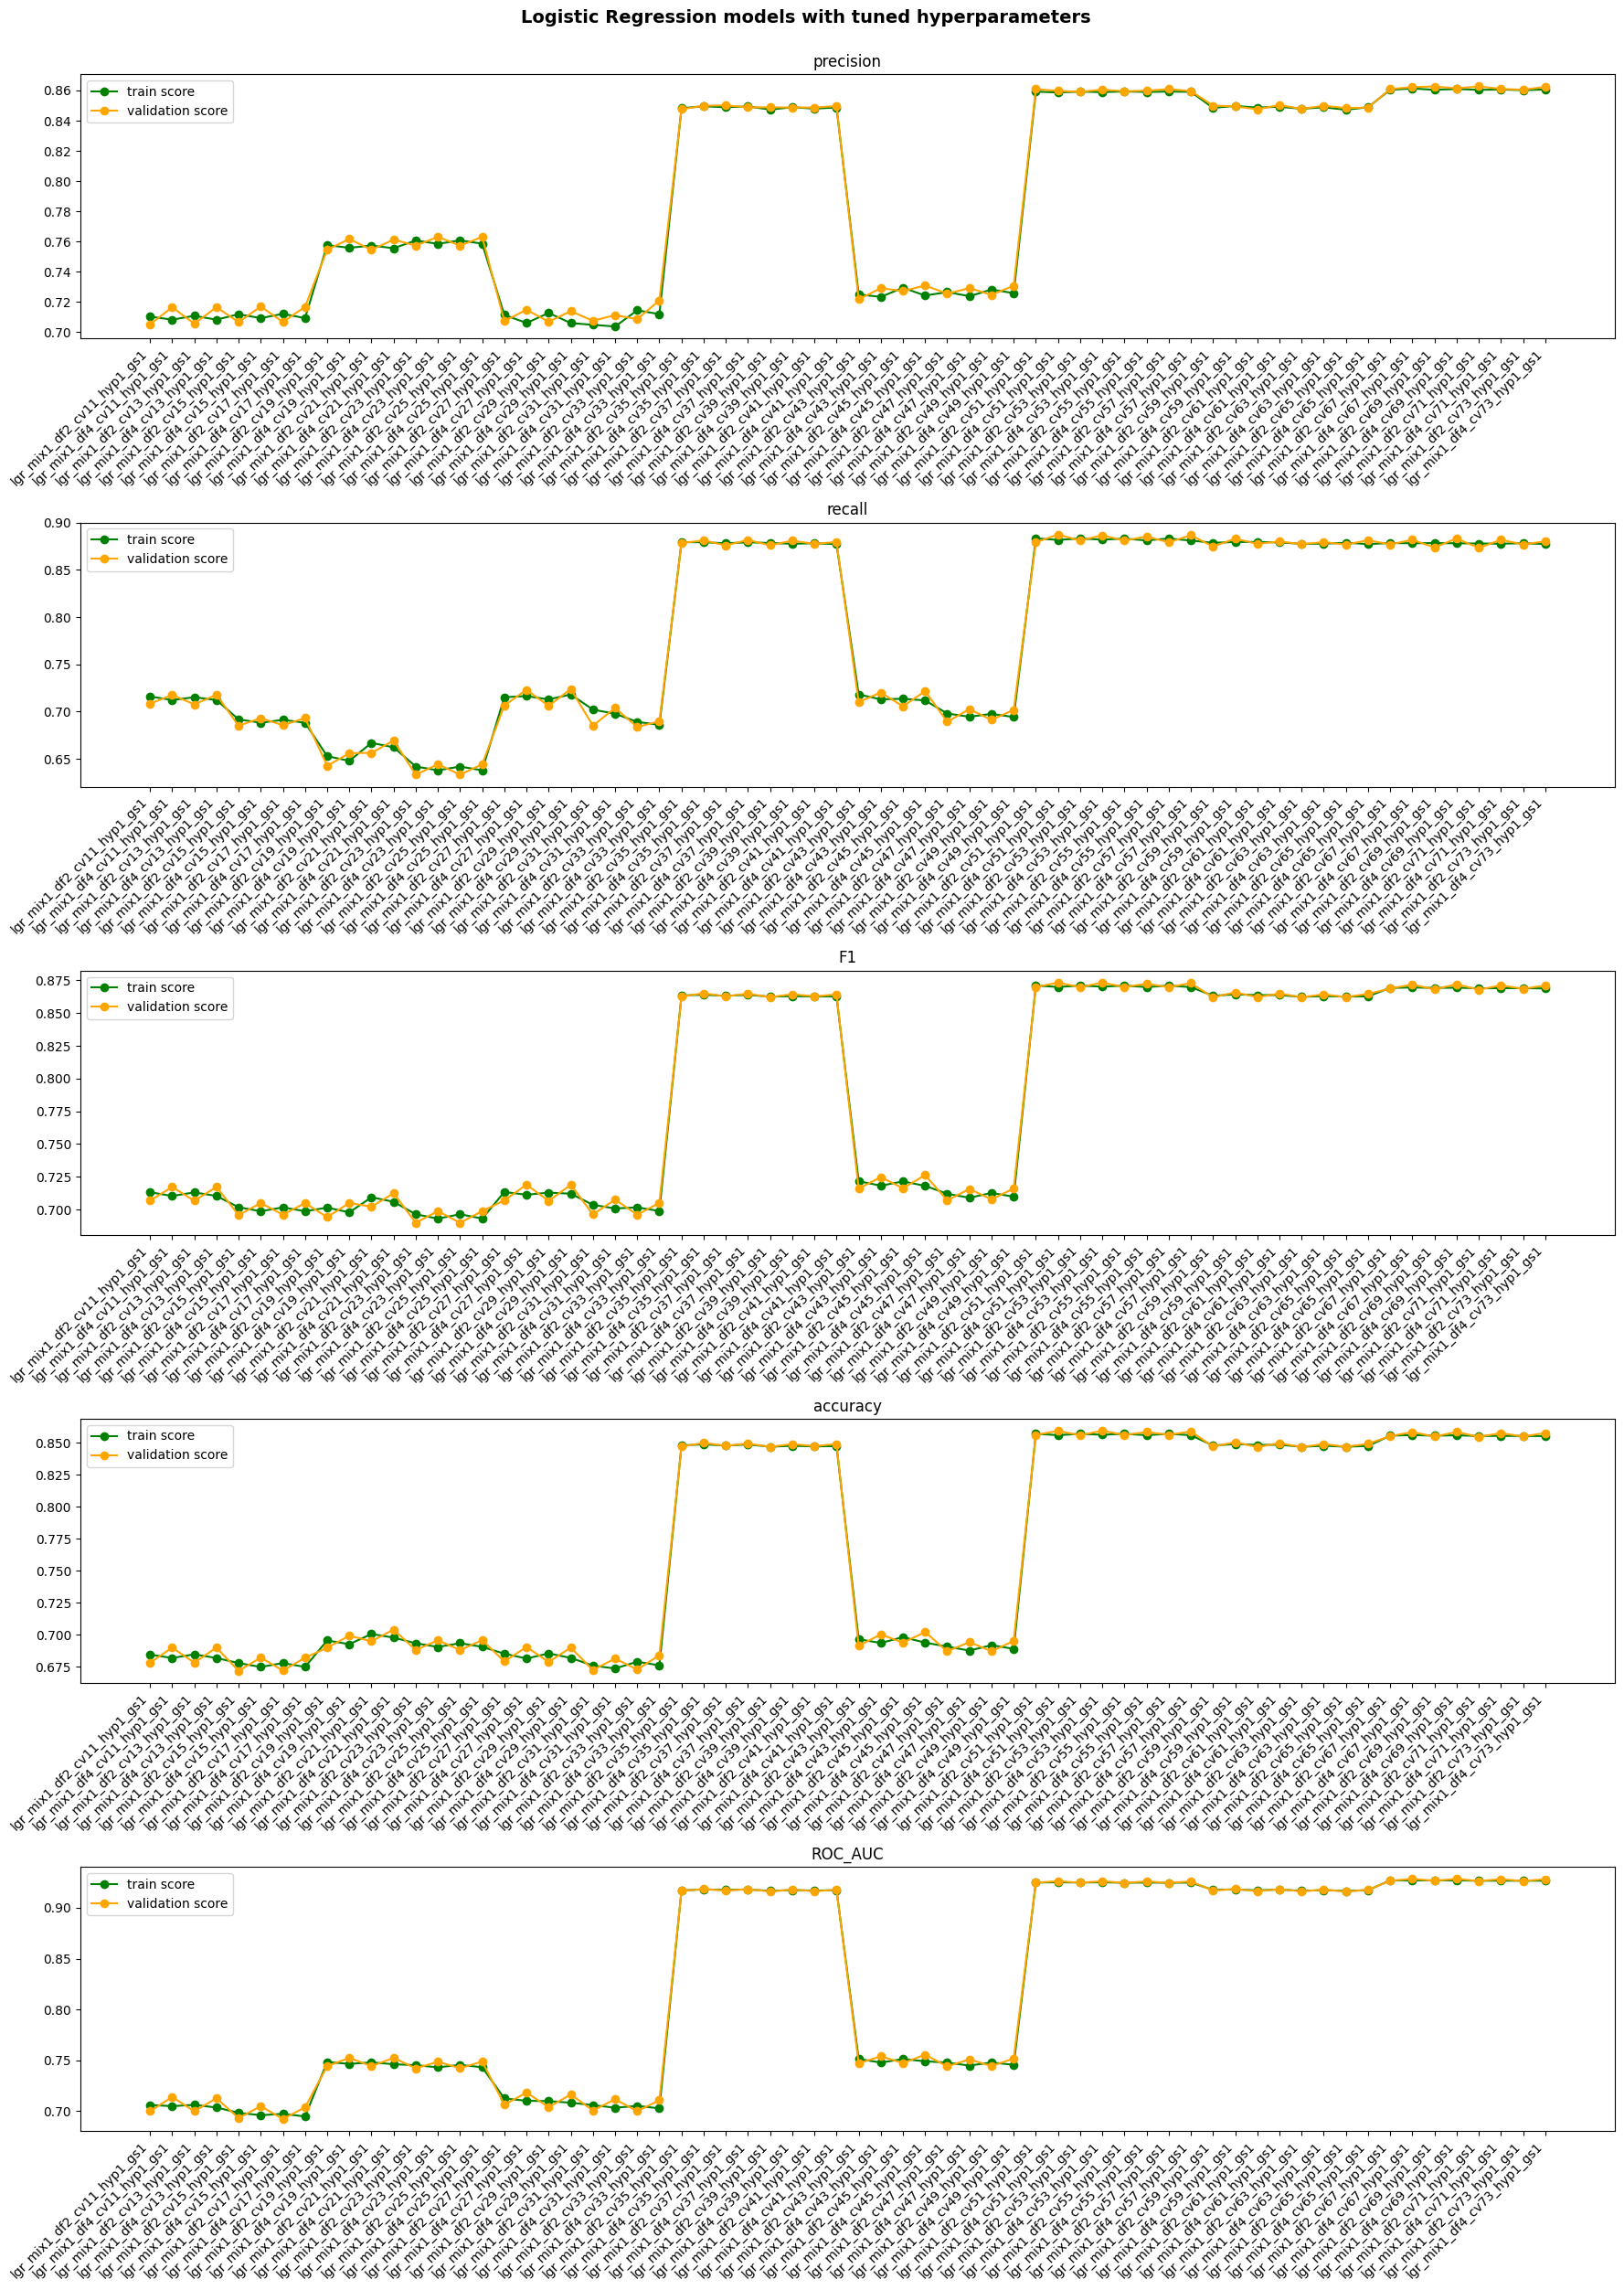

In [62]:
##############################################
#Show Trian and Validation Results
#Scaling
##############################################

fig, axs = plt.subplots(5, 1, figsize=(18,25))

metrics=['precision','recall', 'F1','accuracy','ROC_AUC']

for metric, ax in zip(metrics, axs.ravel()):
    #plot train scores
    ax.plot(lgr_train_score['model'], lgr_train_score[metric], color='green', label='train score',marker='o')
    #plot validation scores
    ax.plot(lgr_val_score['model'], lgr_val_score[metric], color='orange', label='validation score',marker='o')
    ax.set_title(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()

plt.suptitle('Logistic Regression models with tuned hyperparameters',y=1,fontsize=14,fontweight='bold')
plt.tight_layout()
plt.show()

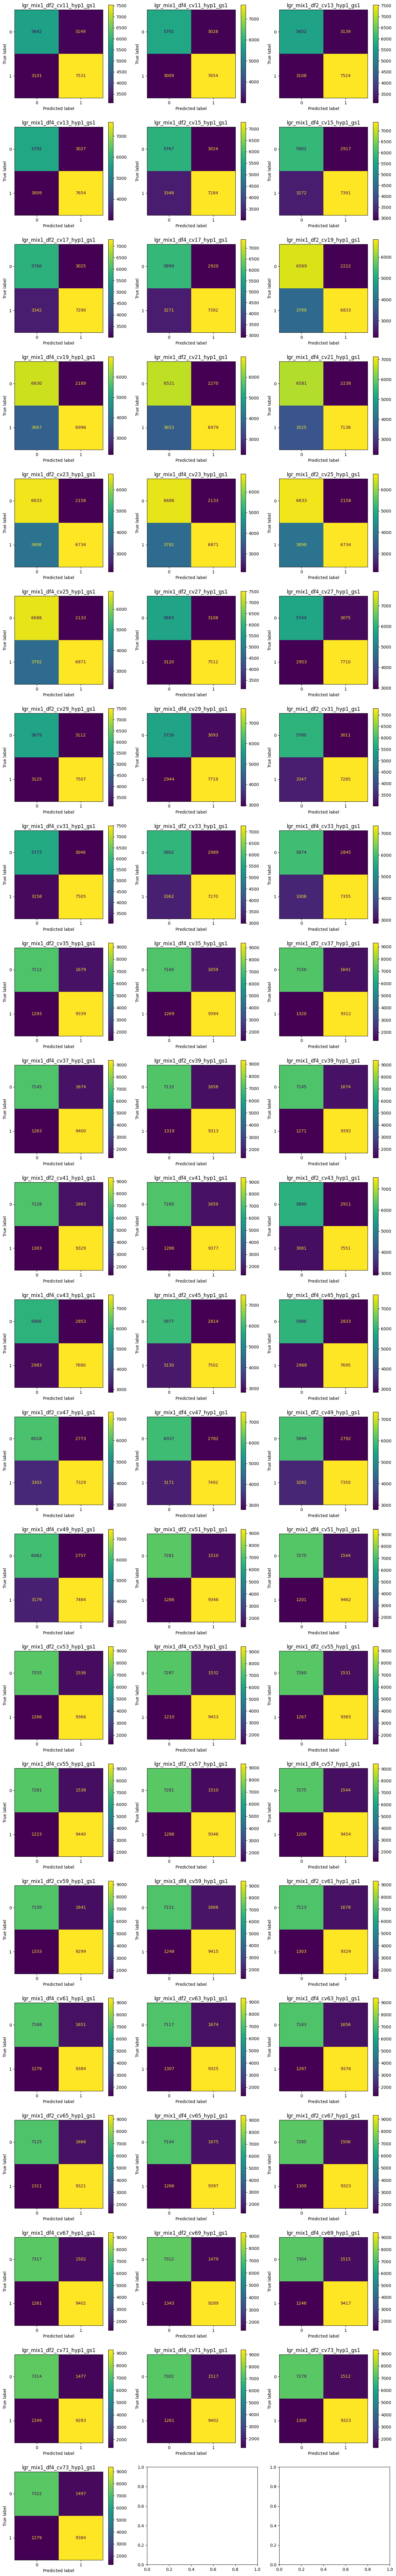

In [63]:
#################################################################################
#Display confusion on validation data
#################################################################################
rowCount=math.ceil(len(lgr_cv_list)/3)
fig, axes = plt.subplots(nrows=rowCount, ncols=3, figsize=(16,rowCount*5))

for lgr_cv,ax,model_index in zip(lgr_cv_list,axes.ravel(),range(len(lgr_cv_list))):
    model=lgr_cv.best_estimator_
    lgr_model_name=lgr_model_name_list[model_index]
    
    params_index=find_number(lgr_model_name, '_cv')[0]-1
    select_col=select_col_list[params_index].copy()
    df_index=find_number(lgr_model_name, '_df')[0]-1
    X_val=X_val_list[df_index]
    y_val=y_val_list[df_index]
    select_features=get_fit_features(select_col,X_val.columns)

    confusion_matrix_plot_ax(model, X_val[select_features], y_val,ax,lgr_model_name)

# Test model on test set

* Select champion model
* Fit all train and validation data
* Validate champion model on test set

### Logistic Regression

In [64]:
%%script True
#########################################################
#Potential Champion model
#########################################################
#get best params
best_model_name='lgr_mix1_df1_cv2_hyp1_gs1'
best_model_index=lgr_model_name_list.index(best_model_name)
best_model=lgr_cv_list[best_model_index]
best_params=best_model.best_params_
#remove classifier__ in resampled model
best_params = {k.replace('classifier__',''):v for k,v in best_params.items()}

#pickle file lgr_[dummy|label]xx_cvXX_hyp*_gs* XX is index
params_index=find_number(best_model_name, '_cv')[0]-1
select_col=select_col_list[params_index].copy()

print(f"best hyperpatameters: {best_params}")
print(f"best features: {select_col}")
print(f"best model name: {best_model_name}")

###################################################
#Fit model and get test score
###################################################
if 'lgr Model name' in best_params:
        best_params.pop('lgr Model name')
lgr_best = LogisticRegression(**best_params,
                                          random_state=RANDOM_STATE)
if 'lgr_mix' in best_model_name:
    target_index=find_number(best_model_name, 'lgr_mix')[0]-1
    df_index=find_number(best_model_name, '_df')[0]-1
    X_train_val=X_train_val_list[df_index]
    y_train_val=y_train_val_list[df_index]
    select_features=get_fit_features(select_col,X_train_val.columns)
    lgr_best.fit(X_train_val[select_features], y_train_val)

    #get test score
    X_test=X_test_list[df_index]
    y_test=y_test_list[df_index]
    lgr_y_preds=lgr_best.predict(X_test[select_features])
    lgr_y_proba= lgr_best.predict_proba(X_test[select_features])
    test_score=get_test_scores(best_model_name, lgr_y_preds, y_test,lgr_y_proba[:,1])
        

lgr_test_score=pd.concat([test_score]).reset_index(drop=True)
lgr_test_score.to_csv('lgr_test_score.csv', index=False, mode='w')
lgr_test_score

Couldn't find program: 'True'


In [65]:
%%script True
###################################################
#Just see all models
###################################################
lgr_all_test_score_list=[]
for lgr_cv, index in zip(lgr_cv_list, range(len(lgr_cv_list))):
    lgr_params=lgr_cv.best_params_
    lgr_model_name=lgr_model_name_list[index]
    #remove classifier__ in resampled model
    lgr_params = {k.replace('classifier__',''):v for k,v in lgr_params.items()}
    if 'lgr Model name' in lgr_params:
        lgr_params.pop('lgr Model name')
    lgr_classifier = LogisticRegression(**lgr_params,
                                          random_state=RANDOM_STATE)
    #pickle file lgr_[dummy|label]_cvXX_hyp*_gs* XX is index
    params_index=find_number(lgr_model_name, '_cv')[0]-1
    select_col=select_col_list[params_index].copy()

    if 'lgr_mix' in lgr_model_name:
        target_index=find_number(lgr_model_name, 'lgr_mix')[0]-1
        df_index=find_number(lgr_model_name, '_df')[0]-1
        X_train_val=X_train_val_list[df_index]
        y_train_val=y_train_val_list[df_index]
        select_features=get_fit_features(select_col,X_train_val.columns)
        lgr_classifier.fit(X_train_val[select_features], y_train_val)

        X_test=X_test_list[df_index]
        y_test=y_test_list[df_index]
        lgr_preds=lgr_classifier.predict(X_test[select_features])
        lgr_preds_proba=lgr_classifier.predict_proba(X_test[select_features])[:, 1]
        test_score=get_test_scores(lgr_model_name, lgr_preds, y_test,lgr_preds_proba)
        
    
    lgr_all_test_score_list.append(test_score)

lgr_all_test_score=pd.concat(lgr_all_test_score_list).reset_index(drop=True)
lgr_all_test_score.to_csv('lgr_all_test_score.csv', index=False)
lgr_all_test_score

Couldn't find program: 'True'


In [66]:
%%script True
#show df1:X_list[0]
lgr_all_test_score[lgr_all_test_score['model'].str.contains('df1')]

Couldn't find program: 'True'


In [67]:
%%script True
#show df2:X_list[1]
lgr_all_test_score[lgr_all_test_score['model'].str.contains('df2')]

Couldn't find program: 'True'


In [68]:
%%script True
#show df3:X_list[2]
lgr_all_test_score[lgr_all_test_score['model'].str.contains('df3')]

Couldn't find program: 'True'


In [69]:
%%script True
#show df3:X_list[3]
lgr_all_test_score[lgr_all_test_score['model'].str.contains('df4')]

Couldn't find program: 'True'


# Conclusion

* Potential Good Models

|Model Features Used|Feature Index|Potential Good Model|
|:-|:-|:-|
|customer_type+age+type_of_travel+class+flight_distance+rating items+departure_delay_in_minutes|No.2<BR/>No.66-No.73|lgr_mix1_df4_cv67_hyp1_gs1|
|age+type_of_travel+class+flight_distance+rating items+departure_delay_in_minutes|No.3<BR/>No.58-No.65|lgr_mix1_df4_cv59_hyp1_gs1|
|customer_type+age+class+flight_distance+rating items+departure_delay_in_minutes|No.4<BR/>No.50-No.57|lgr_mix1_df4_cv51_hyp1_gs1|
|customer_type+age+type_of_travel+class+flight_distance+departure_delay_in_minutes|No.5<BR/>No.42-No.49|lgr_mix1_df4_cv45_hyp1_gs1|
|age+class+flight_distance+rating items+departure_delay_in_minutes|No.6<BR/>No.34-No.41|lgr_mix1_df4_cv35_hyp1_gs1|
|age+type_of_travel+class+flight_distance+departure_delay_in_minutes|No.7<BR/>No.26-No.33|lgr_mix1_df4_cv27_hyp1_gs1|
|customer_type+age+class+flight_distance+departure_delay_in_minutes|No.8<BR/>No.18-No.25|lgr_mix1_df4_cv21_hyp1_gs1|
|age+class+flight_distance+departure_delay_in_minutes|No.9<BR/>No.10-No.17|lgr_mix1_df4_cv11_hyp1_gs1|


* Potential Good Model Scores

|model	|dataset|precision	|recall	|F1	|accuracy	|ROC_AUC|
|:-|:-|-:|-:|-:|-:|-:|
|lgr_mix1_df4_cv11_hyp1_gs1|train|	0.708304|	0.712323|	0.710308|	0.681989|	0.704954|
|lgr_mix1_df4_cv11_hyp1_gs1|validation|	0.708304|	0.712323|	0.710308|	0.681989|	0.704954|
|lgr_mix1_df4_cv21_hyp1_gs1|train|	0.755577|	0.662290|	0.705865|	0.697901|	0.746207|
|lgr_mix1_df4_cv21_hyp1_gs1|validation|	0.755577|	0.662290|	0.705865|	0.697901|	0.746207|
|lgr_mix1_df4_cv27_hyp1_gs1|train|	0.706103|	0.716449|	0.711238|	0.681591|	0.710268|
|lgr_mix1_df4_cv27_hyp1_gs1|validation|	0.706103|	0.716449|	0.711238|	0.681591|	0.710268|
|lgr_mix1_df4_cv35_hyp1_gs1|train|	0.849524|	0.879162|	0.864089|	0.848630|	0.918166|
|lgr_mix1_df4_cv35_hyp1_gs1|validation|	0.849524|	0.879162|	0.864089|	0.848630|	0.918166|
|lgr_mix1_df4_cv45_hyp1_gs1|train|	0.724280|	0.711901|	0.718037|	0.693987|	0.749086|
|lgr_mix1_df4_cv45_hyp1_gs1|validation|	0.724280|	0.711901|	0.718037|	0.693987|	0.749086|
|lgr_mix1_df4_cv53_hyp1_gs1|train|	0.858953|	0.881952|	0.870301|	0.856124|	0.925177|
|lgr_mix1_df4_cv53_hyp1_gs1|validation|	0.860537|	0.886523|	0.873337|	0.859255|	0.926167|
|lgr_mix1_df4_cv59_hyp1_gs1|train|	0.849754|	0.879419|	0.864332|	0.848899|	0.918160|
|lgr_mix1_df4_cv59_hyp1_gs1|validation|	0.849754|	0.879419|	0.864332|	0.848899|	0.918160|
|lgr_mix1_df4_cv67_hyp1_gs1|train|	0.861362|	0.878083|	0.869642|	0.855918|	0.927057|
|lgr_mix1_df4_cv67_hyp1_gs1|validation|	0.861362|	0.878083|	0.869642|	0.855918|	0.927057|






In [70]:
potential_models=['lgr_mix1_df4_cv67_hyp1_gs1','lgr_mix1_df4_cv59_hyp1_gs1',
                 'lgr_mix1_df4_cv53_hyp1_gs1','lgr_mix1_df4_cv45_hyp1_gs1',
                 'lgr_mix1_df4_cv35_hyp1_gs1','lgr_mix1_df4_cv27_hyp1_gs1',
                 'lgr_mix1_df4_cv21_hyp1_gs1','lgr_mix1_df4_cv11_hyp1_gs1']
display(lgr_train_score[lgr_train_score['model'].isin(potential_models)])
display(lgr_val_score[lgr_val_score['model'].isin(potential_models)])


model  precision    recall        F1  accuracy  \
1   lgr_mix1_df4_cv11_hyp1_gs1   0.708304  0.712323  0.710308  0.681989   
11  lgr_mix1_df4_cv21_hyp1_gs1   0.755577  0.662290  0.705865  0.697901   
17  lgr_mix1_df4_cv27_hyp1_gs1   0.706103  0.716449  0.711238  0.681591   
25  lgr_mix1_df4_cv35_hyp1_gs1   0.849524  0.879162  0.864089  0.848630   
35  lgr_mix1_df4_cv45_hyp1_gs1   0.724280  0.711901  0.718037  0.693987   
43  lgr_mix1_df4_cv53_hyp1_gs1   0.858953  0.881952  0.870301  0.856124   
49  lgr_mix1_df4_cv59_hyp1_gs1   0.849754  0.879419  0.864332  0.848899   
57  lgr_mix1_df4_cv67_hyp1_gs1   0.861362  0.878083  0.869642  0.855918   

     ROC_AUC  
1   0.704954  
11  0.746207  
17  0.710268  
25  0.918166  
35  0.749086  
43  0.925177  
49  0.918160  
57  0.927057

model  precision    recall        F1  accuracy  \
1   lgr_mix1_df4_cv11_hyp1_gs1   0.716532  0.717809  0.717170  0.690124   
11  lgr_mix1_df4_cv21_hyp1_gs1   0.761305  0.669418  0.712411  0.704188   
17  lgr_mix1_df4_cv27_hyp1_gs1   0.714882  0.723061  0.718948  0.690586   
25  lgr_mix1_df4_cv35_hyp1_gs1   0.849905  0.880990  0.865169  0.849707   
35  lgr_mix1_df4_cv45_hyp1_gs1   0.730908  0.721654  0.726252  0.702238   
43  lgr_mix1_df4_cv53_hyp1_gs1   0.860537  0.886523  0.873337  0.859255   
49  lgr_mix1_df4_cv59_hyp1_gs1   0.849499  0.882960  0.865906  0.850323   
57  lgr_mix1_df4_cv67_hyp1_gs1   0.862252  0.881741  0.871888  0.858177   

     ROC_AUC  
1   0.714004  
11  0.752415  
17  0.718296  
25  0.918523  
35  0.755580  
43  0.926167  
49  0.918533  
57  0.928508

In [71]:
feature_index_map={
    "customer_type+age+type_of_travel+class+flight_distance+rating items+departure_delay_in_minutes":
    [2,66,67,68,69,70,71,72,73],
    "age+type_of_travel+class+flight_distance+rating items+departure_delay_in_minutes":
    [3,58,59,60,61,62,63,64,65],
    "customer_type+age+class+flight_distance+rating items+departure_delay_in_minutes":
    [4,50,51,52,53,54,55,56,57],
    "customer_type+age+type_of_travel+class+flight_distance+departure_delay_in_minutes":
    [5,42,43,44,45,46,47,48,49],
    "age+class+flight_distance+rating items+departure_delay_in_minutes":
    [6,34,35,36,37,38,39,40,41],
    "age+type_of_travel+class+flight_distance+departure_delay_in_minutes":
    [7,26,27,28,29,30,31,32,33],
    "customer_type+age+class+flight_distance+departure_delay_in_minutes":
    [8,18,19,20,21,22,23,24,25],
    "age+class+flight_distance+departure_delay_in_minutes":
    [9,10,11,12,13,14,15,16,17]
    
}

lgr_potential_good_models_train=lgr_train_score[lgr_train_score['model'].isin(potential_models)]
lgr_potential_good_models_train['dataset']='train'
lgr_potential_good_models_val=lgr_val_score[lgr_val_score['model'].isin(potential_models)]
lgr_potential_good_models_val['dataset']='validation'
lgr_potential_good_models=pd.concat([lgr_potential_good_models_train,lgr_potential_good_models_val]).reset_index(drop=True)


lgr_potential_good_models['features']=''
lgr_potential_good_models['type']='Logistic Regression'
for features,feature_index in zip(feature_index_map.keys(),feature_index_map.values()):
    lgr_potential_good_models['feature_index']=lgr_potential_good_models['model'].str.extract(r'_cv(\d+)_').astype(int)
    mask=lgr_potential_good_models['feature_index'].isin(feature_index)
    lgr_potential_good_models.loc[mask,'features']=features

new_order = ['type', 'features','feature_index','model','dataset', 'precision', 'recall', 'F1', 'accuracy','ROC_AUC']
lgr_potential_good_models = lgr_potential_good_models[new_order]

# Sorting using the custom order
lgr_potential_good_models['features'] = pd.Categorical(lgr_potential_good_models['features'], categories=feature_index_map.keys(), ordered=True)
lgr_potential_good_models=lgr_potential_good_models.sort_values('features')
lgr_potential_good_models.to_csv('lgr_potential_good_models.csv', index=False)
lgr_potential_good_models

type                                           features  \
7   Logistic Regression  customer_type+age+type_of_travel+class+flight_...   
15  Logistic Regression  customer_type+age+type_of_travel+class+flight_...   
6   Logistic Regression  age+type_of_travel+class+flight_distance+ratin...   
14  Logistic Regression  age+type_of_travel+class+flight_distance+ratin...   
5   Logistic Regression  customer_type+age+class+flight_distance+rating...   
13  Logistic Regression  customer_type+age+class+flight_distance+rating...   
4   Logistic Regression  customer_type+age+type_of_travel+class+flight_...   
12  Logistic Regression  customer_type+age+type_of_travel+class+flight_...   
3   Logistic Regression  age+class+flight_distance+rating items+departu...   
11  Logistic Regression  age+class+flight_distance+rating items+departu...   
2   Logistic Regression  age+type_of_travel+class+flight_distance+depar...   
10  Logistic Regression  age+type_of_travel+class+flight_distance+depar...   
1   Logistic Regression  customer_type+age+class+flight_distance+depart...   
9   Logistic Regression  customer_type+age+class+flight_distance+depart...   
0   Logistic Regression  age+class+flight_distance+departure_delay_in_m...   
8   Logistic Regression  age+class+flight_distance+departure_delay_in_m...   

    feature_index                       model     dataset  precision  \
7              67  lgr_mix1_df4_cv67_hyp1_gs1       train   0.861362   
15             67  lgr_mix1_df4_cv67_hyp1_gs1  validation   0.862252   
6              59  lgr_mix1_df4_cv59_hyp1_gs1       train   0.849754   
14             59  lgr_mix1_df4_cv59_hyp1_gs1  validation   0.849499   
5              53  lgr_mix1_df4_cv53_hyp1_gs1       train   0.858953   
13             53  lgr_mix1_df4_cv53_hyp1_gs1  validation   0.860537   
4              45  lgr_mix1_df4_cv45_hyp1_gs1       train   0.724280   
12             45  lgr_mix1_df4_cv45_hyp1_gs1  validation   0.730908   
3              35  lgr_mix1_df4_cv35_hyp1_gs1       train   0.849524   
11             35  lgr_mix1_df4_cv35_hyp1_gs1  validation   0.849905   
2              27  lgr_mix1_df4_cv27_hyp1_gs1       train   0.706103   
10             27  lgr_mix1_df4_cv27_hyp1_gs1  validation   0.714882   
1              21  lgr_mix1_df4_cv21_hyp1_gs1       train   0.755577   
9              21  lgr_mix1_df4_cv21_hyp1_gs1  validation   0.761305   
0              11  lgr_mix1_df4_cv11_hyp1_gs1       train   0.708304   
8              11  lgr_mix1_df4_cv11_hyp1_gs1  validation   0.716532   

      recall        F1  accuracy   ROC_AUC  
7   0.878083  0.869642  0.855918  0.927057  
15  0.881741  0.871888  0.858177  0.928508  
6   0.879419  0.864332  0.848899  0.918160  
14  0.882960  0.865906  0.850323  0.918533  
5   0.881952  0.870301  0.856124  0.925177  
13  0.886523  0.873337  0.859255  0.926167  
4   0.711901  0.718037  0.693987  0.749086  
12  0.721654  0.726252  0.702238  0.755580  
3   0.879162  0.864089  0.848630  0.918166  
11  0.880990  0.865169  0.849707  0.918523  
2   0.716449  0.711238  0.681591  0.710268  
10  0.723061  0.718948  0.690586  0.718296  
1   0.662290  0.705865  0.697901  0.746207  
9   0.669418  0.712411  0.704188  0.752415  
0   0.712323  0.710308  0.681989  0.704954  
8   0.717809  0.717170  0.690124  0.714004

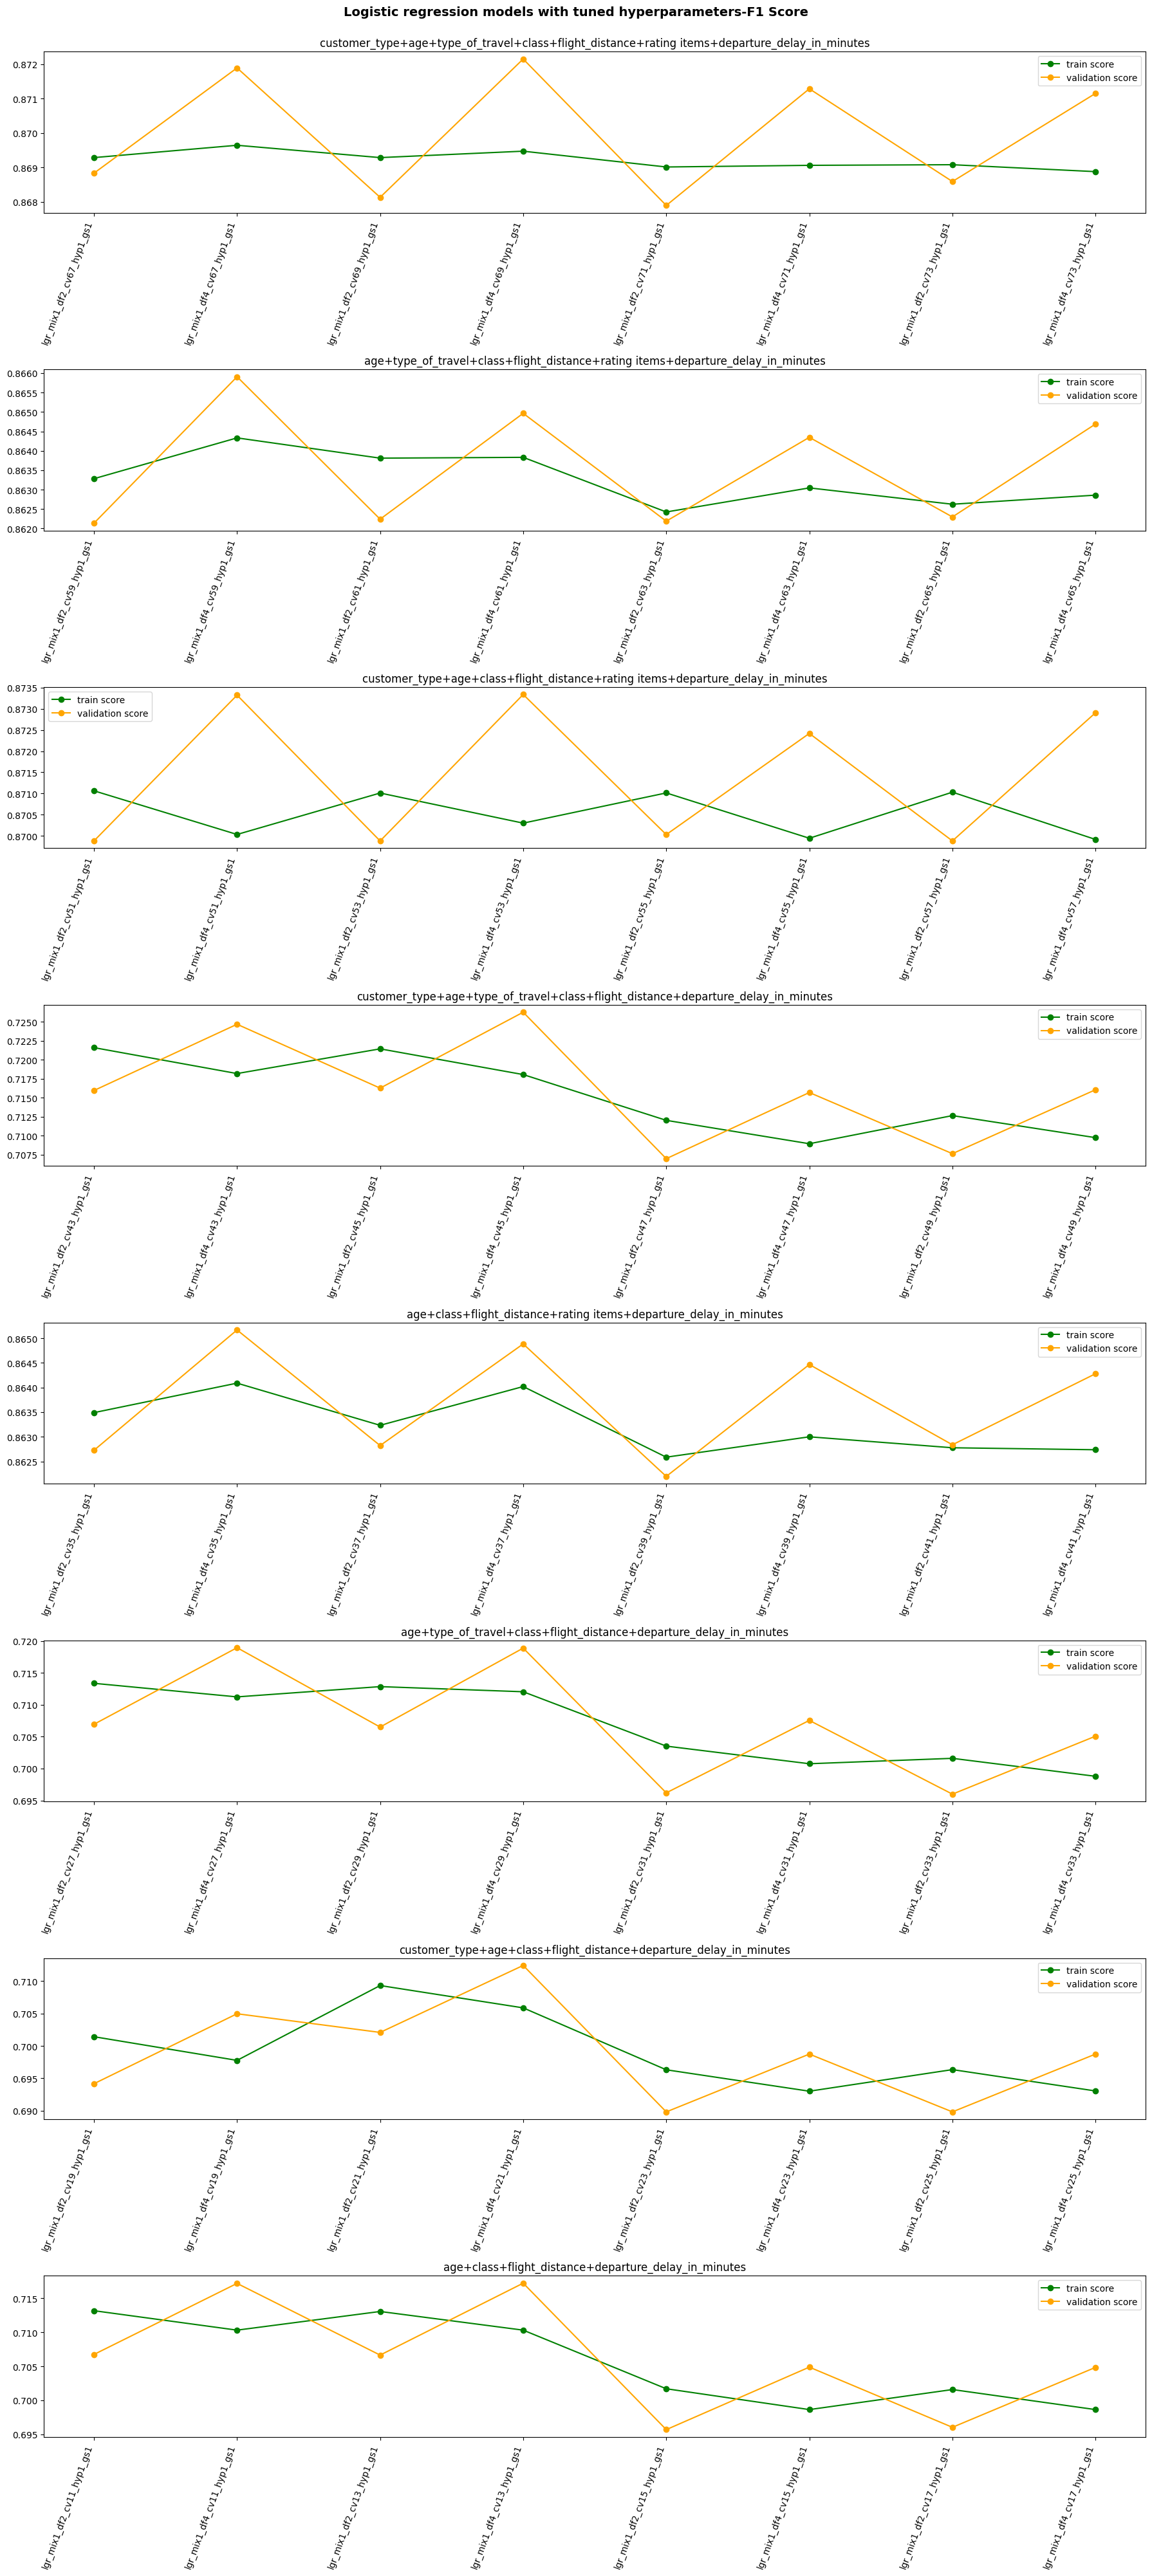

In [72]:
##############################################
#Show Trian and Validation Results
#F1 score
##############################################

fig, axs = plt.subplots(8, 1, figsize=(18,40))

metrics=['precision','recall', 'F1','accuracy','ROC_AUC']


for features,feature_index, ax in zip(feature_index_map.keys(),feature_index_map.values(), axs.ravel()):
    lgr_train_score['feature_index']=lgr_train_score['model'].str.extract(r'_cv(\d+)_').astype(int)
    lgr_val_score['feature_index']=lgr_val_score['model'].str.extract(r'_cv(\d+)_').astype(int)
    mask_train=lgr_train_score['feature_index'].isin(feature_index)
    mask_val=lgr_val_score['feature_index'].isin(feature_index)
    #plot train scores
    ax.plot(lgr_train_score[mask_train]['model'], lgr_train_score[mask_train]['F1'], color='green', label='train score',marker='o')
    #plot validation scores
    ax.plot(lgr_val_score[mask_val]['model'], lgr_val_score[mask_val]['F1'], color='orange', label='validation score',marker='o')
    ax.set_title(features)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
    ax.legend()

plt.suptitle('Logistic regression models with tuned hyperparameters-F1 Score',y=1,fontsize=14,fontweight='bold')
plt.tight_layout()
plt.show()

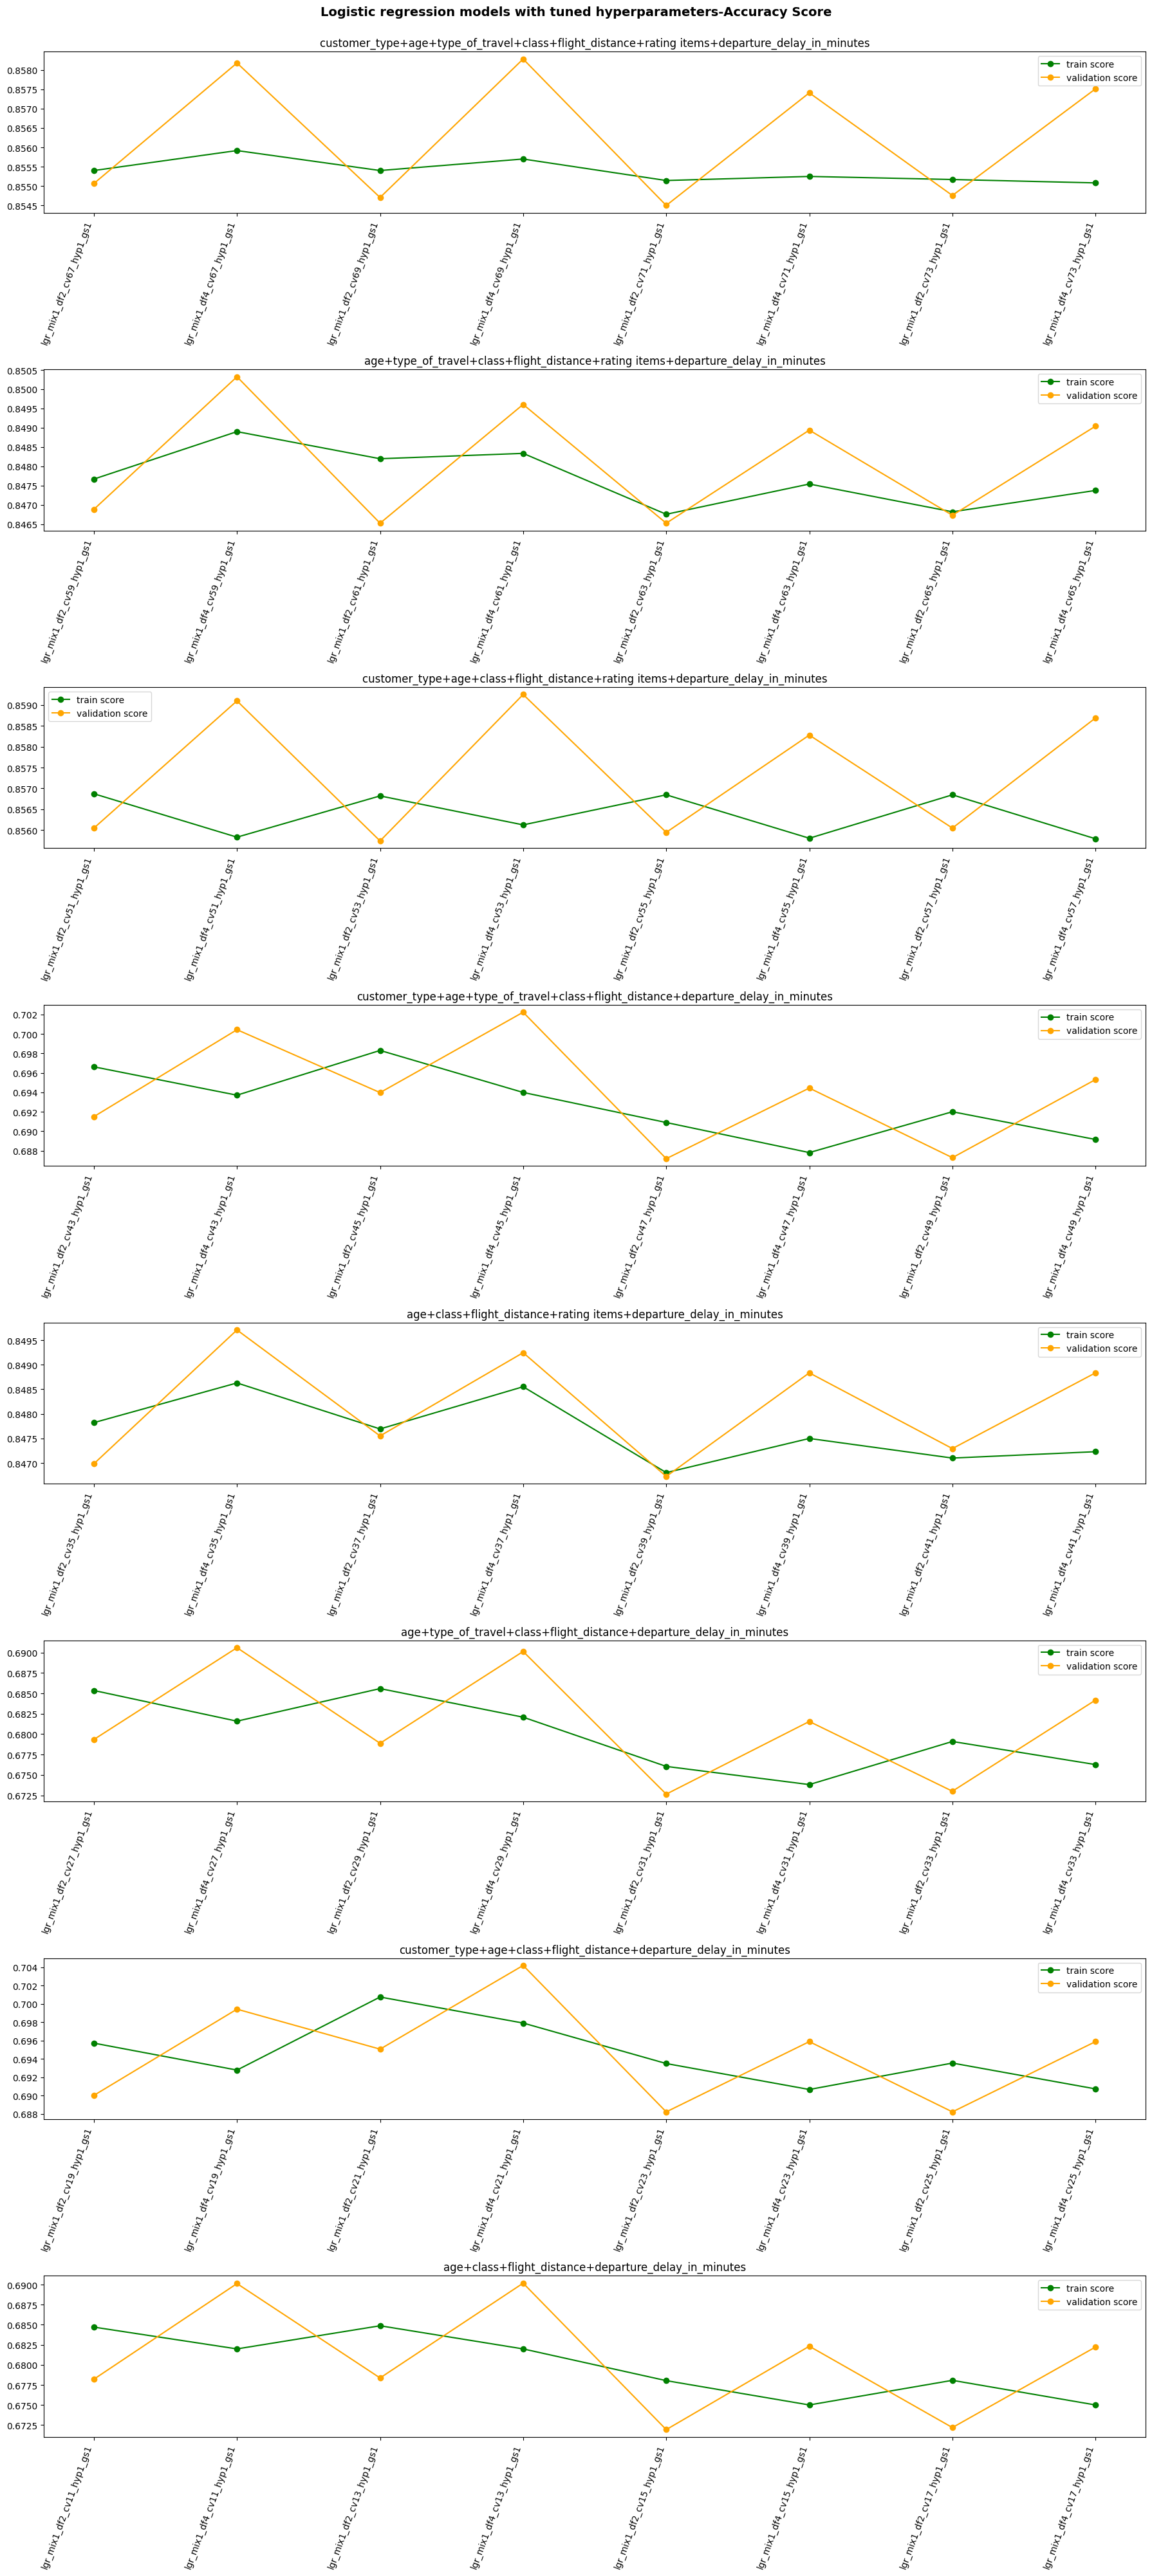

In [73]:
##############################################
#Show Trian and Validation Results
#accuracy score
##############################################

fig, axs = plt.subplots(8, 1, figsize=(18,40))

metrics=['precision','recall', 'F1','accuracy','ROC_AUC']


for features,feature_index, ax in zip(feature_index_map.keys(),feature_index_map.values(), axs.ravel()):
    lgr_train_score['feature_index']=lgr_train_score['model'].str.extract(r'_cv(\d+)_').astype(int)
    lgr_val_score['feature_index']=lgr_val_score['model'].str.extract(r'_cv(\d+)_').astype(int)
    mask_train=lgr_train_score['feature_index'].isin(feature_index)
    mask_val=lgr_val_score['feature_index'].isin(feature_index)
    #plot train scores
    ax.plot(lgr_train_score[mask_train]['model'], lgr_train_score[mask_train]['accuracy'], color='green', label='train score',marker='o')
    #plot validation scores
    ax.plot(lgr_val_score[mask_val]['model'], lgr_val_score[mask_val]['accuracy'], color='orange', label='validation score',marker='o')
    ax.set_title(features)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
    ax.legend()

plt.suptitle('Logistic regression models with tuned hyperparameters-Accuracy Score',y=1,fontsize=14,fontweight='bold')
plt.tight_layout()
plt.show()

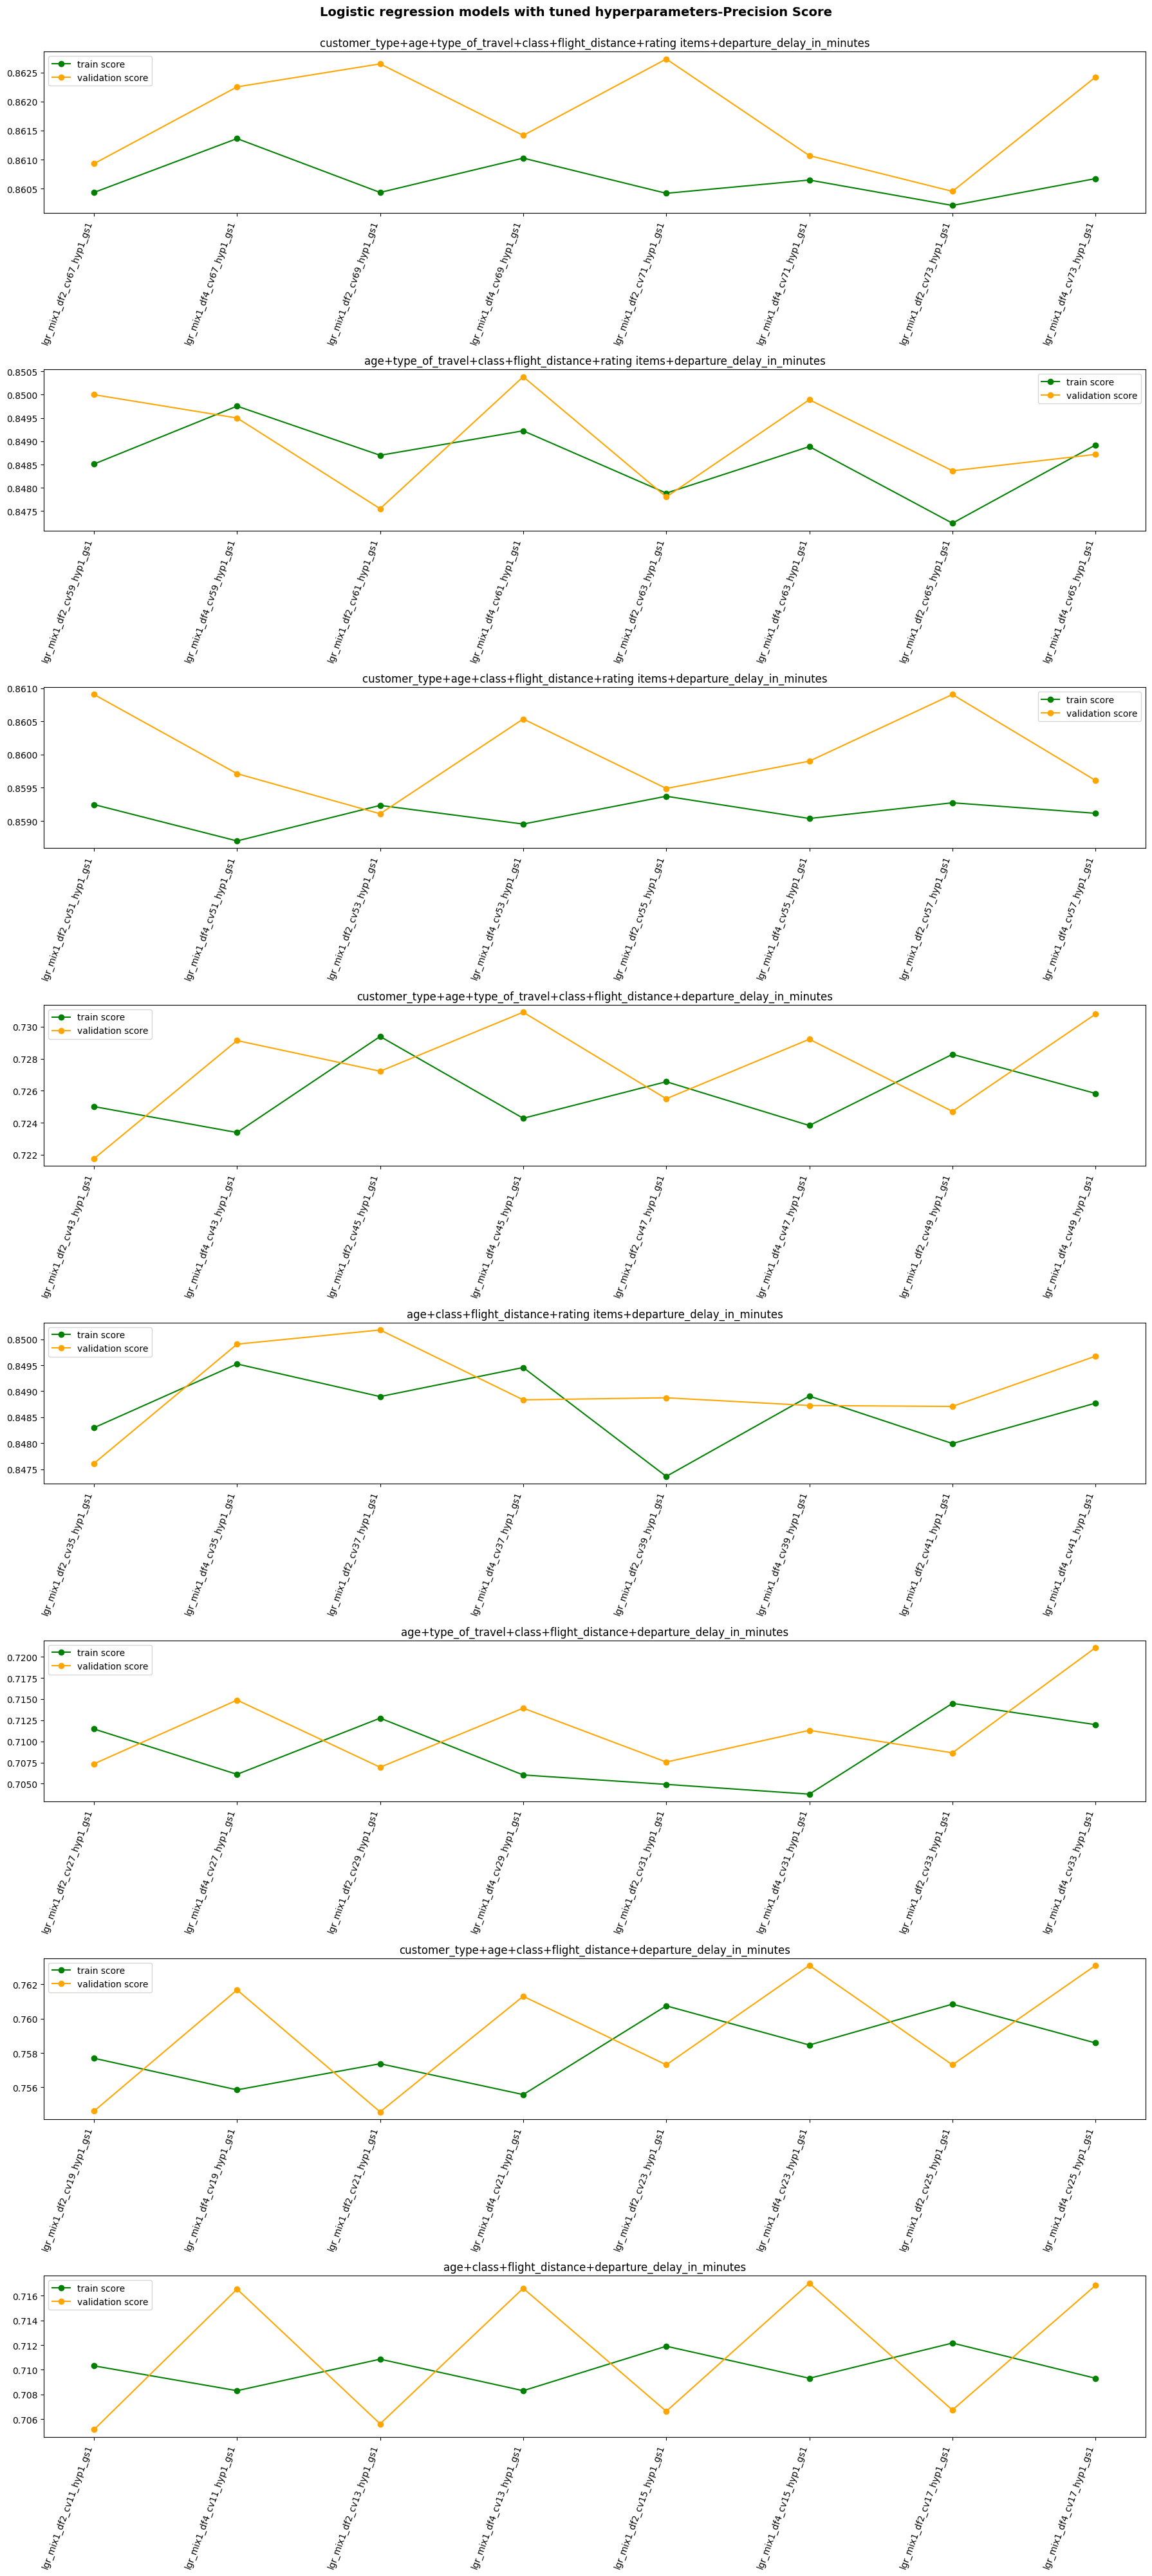

In [74]:
##############################################
#Show Trian and Validation Results
#Precision score
##############################################

fig, axs = plt.subplots(8, 1, figsize=(18,40))

metrics=['precision','recall', 'F1','accuracy','ROC_AUC']


for features,feature_index, ax in zip(feature_index_map.keys(),feature_index_map.values(), axs.ravel()):
    lgr_train_score['feature_index']=lgr_train_score['model'].str.extract(r'_cv(\d+)_').astype(int)
    lgr_val_score['feature_index']=lgr_val_score['model'].str.extract(r'_cv(\d+)_').astype(int)
    mask_train=lgr_train_score['feature_index'].isin(feature_index)
    mask_val=lgr_val_score['feature_index'].isin(feature_index)
    #plot train scores
    ax.plot(lgr_train_score[mask_train]['model'], lgr_train_score[mask_train]['precision'], color='green', label='train score',marker='o')
    #plot validation scores
    ax.plot(lgr_val_score[mask_val]['model'], lgr_val_score[mask_val]['precision'], color='orange', label='validation score',marker='o')
    ax.set_title(features)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
    ax.legend()

plt.suptitle('Logistic regression models with tuned hyperparameters-Precision Score',y=1,fontsize=14,fontweight='bold')
plt.tight_layout()
plt.show()